### Introduction

A list of the resources I used:
- Good reference to understand the terms used in RL: https://towardsdatascience.com/the-complete-reinforcement-learning-dictionary-e16230b7d24e
- Article useful for building a custom environment based off an example that isn't a game: https://towardsdatascience.com/creating-a-custom-openai-gym-environment-for-stock-trading-be532be3910e 
- OpenAI Gym Documentation: https://www.gymlibrary.ml 
- Stable Baselines 3 Documentation (Page is the chosen model): https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html#stable_baselines3.dqn.CnnPolicy 
- A good two part tutorial: https://towardsdatascience.com/ultimate-guide-for-reinforced-learning-part-1-creating-a-game-956f1f2b0a91  
- All about DQN: https://avandekleut.github.io/dqn/ 



In [213]:
import numpy as np
import gym
from gym import spaces
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common import env_checker
import seaborn as sns
import cv2
import os
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches
from shapely.geometry import Polygon, LineString, Point
import random
import time
from rasterio.features import rasterize
from IPython import display
import geopandas as gpd
import pandas as pd
from skimage.feature import match_template
%matplotlib inline

font = cv2.FONT_ITALIC
os.chdir('/Users/jmccarty/GitHub/22spring_templatematching_carto/rl_method')


path_sample_image = './data/tif_files/LKg_1092_1990.tif'
path_sample_template_1 = './data/templates/temp_1.tif'
path_sample_template_2 = './data/templates/temp_2.tif'

path_testing_image = './data/testing/testing_board.tif'
path_testing_image_red = './data/testing/testing_board_red.tif'
path_testing_image_red_grid = './data/testing/testing_board_red_grid.tif'

path_testing_template_1 = './data/testing/testing_template.tif'


### General Functions


In [170]:
def crop_image(image,y_start,x_start,height,width):
    return image[y_start:y_start+height,x_start:x_start+width]

def rect_out_rast(y,x,height,width):
    p = Polygon([[x, y], [x+width, y+0], [x+width, y+height], [x+0, y+height]])
    return rasterize([p],out_shape=(width,height)).T

def Sum_of_squared_differences(roi,temp):
    ssd = np.sum((np.array(roi, dtype=np.float32) - np.array(temp, dtype=np.float32))**2)
    return ssd

def Normalized_cross_correlation(roi,temp):
    cc = np.sum(roi*temp)
    nor = np.sqrt(np.sum(roi**2)) * np.sqrt(np.sum(temp**2))
    return cc/nor

def ssd(A,B):
  dif = A.ravel() - B.ravel()
  return np.dot( dif, dif )

def action_rules(action):
    if action==None:
        return action
    elif action<4:
        return action+4
    else:
        return action-4

def tuple_addition(a,b):
    return tuple(map(sum, zip(a, b)))

def get_action_meanings():
        return {0: "South", 1: "Southwest", 2: "West", 3: "Northwest",
                4: "North", 5: "Northeast", 6: "East", 7: "Southeast",
                -1: "No Moves"}
        
def calc_termination_point(point,multipliers,dimensions):
            termination_y = point[0] + multipliers[0] * dimensions[0]
            termination_x = point[1] + multipliers[1] * dimensions[1]
            return (termination_y,termination_x)
        

def calc_increment_space(image_size,template_size):
    actual_increments = image_size/template_size
    possible_increments = int(np.floor(actual_increments))
    return np.arange(0,template_size*(possible_increments+1),template_size)

### Testing SSD Scores

113.33333333333333


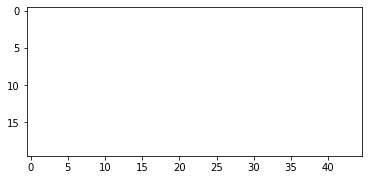

In [204]:
path = './data/testing/testing_board_red.tif'
red = cv2.cvtColor(cv2.imread(os.path.join(os.getcwd(),path)), cv2.COLOR_BGR2RGB)
t_y = 5
t_h = 20
t_x = 5
t_w = 45
template = red[t_y:t_y+t_h,t_x:t_x+t_w]
sample = crop_image(red,100,10,20,45)

res_list = []
for i in [0,1,2]:
    res_list.append(ssd(sample[:,:,i],
                        template[:,:,i]))
res_mean = sum(res_list) / len(res_list)
print(res_mean)
plt.imshow(sample)



### General Classes

In [3]:
class Point2(object):
    def __init__(self, name, y_max, x_max, y_min, x_min):
        self.y = 0
        self.x = 0
        self.y_max = y_max
        self.x_max = x_max
        self.y_min = y_min
        self.x_min = x_min
        self.name = name
    
    def set_position(self, y, x):
        self.y = self.clamp(y, self.y_min, self.y_max)
        self.x = self.clamp(x, self.x_min, self.x_max)
    
    def get_position(self):
        return (self.y, self.x)
    
    def move(self, del_y, del_x):
        self.y += del_y
        self.x += del_x
        
        self.y = self.clamp(self.y, self.y_min, self.y_max)
        self.x = self.clamp(self.x, self.x_min, self.x_max)

    def clamp(self, n, minn, maxn):
        return max(min(maxn, n), minn)
    
class Frame(Point2):
    def __init__(self,name,y_max, x_max, y_min, x_min, T_HEIGHT, T_WIDTH):
        super(Frame, self).__init__(name, y_max, x_max, y_min, x_min)
        self.icon = cv2.cvtColor(rect_out_rast(y_min,x_min,T_HEIGHT,T_WIDTH), cv2.COLOR_GRAY2RGB)
        self.T_WIDTH = T_WIDTH
        self.T_HEIGHT = T_HEIGHT
        # self.icon = cv2.imread(os.path.join(os.getcwd(),"notebooks","chopper.png")) / 255
        self.icon = cv2.resize(self.icon, (self.T_WIDTH, self.T_HEIGHT)) #cv2 resize method is width then height



### Sandbox

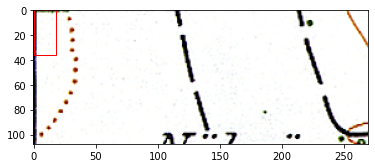

In [32]:
p = patches.Rectangle((0,
                        0), #origin
                        18, #x-dimension
                        36, #y-dimension
                        linewidth=1, 
                        edgecolor='r', 
                        facecolor='None',
                        rasterized=True)


fig, ax = plt.subplots()
x = 0
y = 0
ax.imshow(image_norm[y:y+T_HEIGHT*6, x:x+T_WIDTH*6])
# ax.imshow(cv2.rectangle(, (0,255,0), 1))
# plt.imshow(cv2.rectangle(image_color[y:y+T_HEIGHT*6, x:x+T_WIDTH*6], (x,y), (x+T_WIDTH, y+T_HEIGHT), (0,125,255), 1))
# plt.imshow(cv2.rectangle(image_color[y:y+T_HEIGHT*6, x:x+T_WIDTH*6], )

# Create a Rectangle patch
ax.add_patch(p)

### Load Data

In [31]:

image = cv2.imread(path_sample_image)
image_color = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_grey = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)
image_norm = (image_color/255).astype(float)

template =cv2.imread(path_sample_template_1)
template_color = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)
template_grey = cv2.cvtColor(template_color, cv2.COLOR_BGR2GRAY)
template_norm = (template_color/255).astype(float)

test_image = cv2.imread(path_testing_image)
test_image_color = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image_grey = cv2.cvtColor(test_image_color, cv2.COLOR_BGR2GRAY)
test_image_norm = (test_image_color/255).astype(float)

test_template =cv2.imread(path_testing_template_1)
test_template_color = cv2.cvtColor(test_template, cv2.COLOR_BGR2RGB)
test_template_grey = cv2.cvtColor(test_template_color, cv2.COLOR_BGR2GRAY)
test_template_norm = (test_template_color/255).astype(float)




I_HEIGHT, I_WIDTH, I_DEPTH = image.shape
T_HEIGHT, T_WIDTH, T_DEPTH = template.shape

print('Data Type: %s' % image_norm.dtype)
print('Min: %.3f, Max: %.3f' % (image_norm.min(), image_norm.max()))


Data Type: float64
Min: 0.000, Max: 1.000


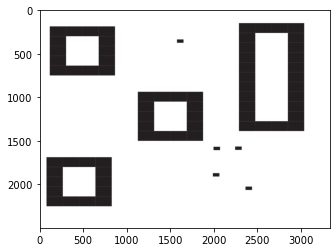

In [169]:
plt.imshow(test_image_norm)

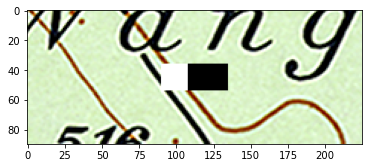

In [137]:
cropped = crop_image(image_norm,1000,2000,template_norm.shape[0]*5,template_norm.shape[1]*5)
# roi_R = cropped[:,:,0]
# roi_G = cropped[:,:,1]
# roi_B = cropped[:,:,2]

# res_list = []

# for i in [0,1,2]:
#     res_list.append(Sum_of_squared_differences(cropped[:,:,i],template_norm[:,:,i]))
    
# res_mean = sum(res_list) / len(res_list)
window_y = int(np.floor(5/2)) * 18
window_x = int(np.floor(5/2)) * 45
# # an optional window to draw on the frame during debugging centered in the frame
test_polygon = cv2.cvtColor(rect_out_rast(0,
                             0,
                             45,
                             18),cv2.COLOR_GRAY2BGR)

cropped[window_y:window_y + 18,window_x:window_x + 45] = test_polygon
plt.imshow(cropped)

Original was (114, 188, 3)
New is (119, 158, 3)
Image is (2500, 3334, 3)


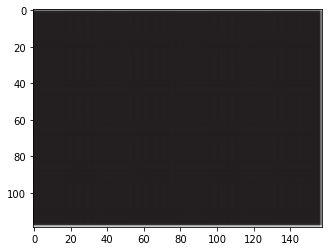

In [45]:
def resize_template()
n_height_intervals = int(np.floor(test_image_norm.shape[0] / test_template_norm.shape[0]))
height = int(np.floor(test_image_norm.shape[0] / n_height_intervals))

n_width_intervals = int(np.floor(test_image_norm.shape[1] / test_template_norm.shape[1]))
width = int(np.floor(test_image_norm.shape[1] / n_height_intervals))

dim = (width,height)

# resize image
resized = cv2.resize(test_template_norm, dim, interpolation = cv2.INTER_AREA)
print(f"Original was {test_template_norm.shape}")
print(f"New is {resized.shape}")
print(f"Image is {test_image_norm.shape}")

plt.imshow(resized)

In [5]:
fig,ax = plt.subplots(figsize=(12,12))
ax.imshow(test_image_norm)#crop_image(test_image_norm,0,0,400,800)) #y,x,h,w

NameError: name 'plt' is not defined

### Inspect Map

In [36]:
x,y = 0,0
print(y,y+T_HEIGHT)
print(x,x+T_WIDTH)
print("----------")
print(y+T_HEIGHT,y+T_HEIGHT+T_HEIGHT)
print(x-T_WIDTH,x-T_WIDTH+T_WIDTH)
print("----------")
print(y,y+T_HEIGHT)
print(x-T_WIDTH,x-T_WIDTH+T_WIDTH)
print("----------")
print(y-T_HEIGHT,y-T_HEIGHT+T_HEIGHT)
print(x-T_WIDTH,x-T_WIDTH+T_WIDTH)
print("----------")
print(y-T_HEIGHT,y-T_HEIGHT+T_HEIGHT)
print(x,x+T_WIDTH)
print("----------")
print(y-T_HEIGHT,y-T_HEIGHT+T_HEIGHT)
print(x+T_WIDTH,x+T_WIDTH+T_WIDTH)
print("----------")
print(y,y+T_HEIGHT)
print(x+T_WIDTH,x+T_WIDTH+T_WIDTH)
print("----------")
print(y+T_HEIGHT,y+T_HEIGHT+T_HEIGHT)
print(x+T_WIDTH,x+T_WIDTH+T_WIDTH)
print("----------")
print(y+T_HEIGHT,y+T_HEIGHT+T_HEIGHT)
print(x,x+T_WIDTH)

0 18
0 45
----------
18 36
-45 0
----------
0 18
-45 0
----------
-18 0
-45 0
----------
-18 0
0 45
----------
-18 0
45 90
----------
0 18
45 90
----------
18 36
45 90
----------
18 36
0 45


In [37]:
x,y = int(0),int(0)

def calc_surround_origins(x,y,T_WIDTH,T_HEIGHT):
    origins = [(x,y),
            (x-T_WIDTH,y+T_HEIGHT),
            (x-T_WIDTH,y),
            (x-T_WIDTH,y-T_HEIGHT),
            (x,y-T_HEIGHT),
            (x+T_WIDTH,y-T_HEIGHT),
            (x+T_WIDTH,y),
            (x+T_WIDTH,y+T_HEIGHT),
            (x,y+T_HEIGHT)]
    return origins

def calc_surround_arrs(image,x,y,T_WIDTH,T_HEIGHT):
    all_surround = [image[y:y+T_HEIGHT,
                        x:x+T_WIDTH],
                    image[y+T_HEIGHT:y+T_HEIGHT+T_HEIGHT,
                        x-T_WIDTH:x-T_WIDTH+T_WIDTH],
                    image[y:y+T_HEIGHT,
                        x-T_WIDTH:x-T_WIDTH+T_WIDTH],
                    image[y-T_HEIGHT:y-T_HEIGHT+T_HEIGHT,
                        x-T_WIDTH:x-T_WIDTH+T_WIDTH],
                    image[y-T_HEIGHT:y-T_HEIGHT+T_HEIGHT,
                        x:x+T_WIDTH],
                    image[y-T_HEIGHT:y-T_HEIGHT+T_HEIGHT,
                        x+T_WIDTH:x+T_WIDTH+T_WIDTH],
                    image[y:y+T_HEIGHT,
                        x+T_WIDTH:x+T_WIDTH+T_WIDTH],
                    image[y+T_HEIGHT:y+T_HEIGHT+T_HEIGHT,
                        x+T_WIDTH:x+T_WIDTH+T_WIDTH],
                    image[y+T_HEIGHT:y+T_HEIGHT+T_HEIGHT,
                        x:x+T_WIDTH]]
    return all_surround[1:]
    

def find_regions_interest(image,x,y,T_WIDTH,T_HEIGHT):
    mask = []
    for n,t in enumerate(calc_surround_origins(x,y,T_WIDTH,T_HEIGHT)):
        if t[0] < 0 or t[1] < 0:
            pass
        else:
            mask.append(n)
    all_surround = calc_surround_arrs(image,x,y,T_WIDTH,T_HEIGHT)
    
    return [all_surround[i] for i in mask]


find_regions_interest(image,x,y,T_WIDTH,T_HEIGHT)

IndexError: list index out of range

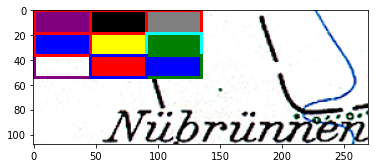

In [ ]:
colos = []
fig, ax = plt.subplots()

ax.imshow(image_color[y:y+T_HEIGHT*6, x:x+T_WIDTH*6])
# ax.imshow(cv2.rectangle(, (0,255,0), 1))
# plt.imshow(cv2.rectangle(image_color[y:y+T_HEIGHT*6, x:x+T_WIDTH*6], (x,y), (x+T_WIDTH, y+T_HEIGHT), (0,125,255), 1))
# plt.imshow(cv2.rectangle(image_color[y:y+T_HEIGHT*6, x:x+T_WIDTH*6], )

x,y = 45,18
# Create a Rectangle patch
ax.add_patch(patches.Rectangle((x,y), #origin
                         T_WIDTH, #x-dimension
                         T_HEIGHT, #y-dimension
                         linewidth=3, 
                         edgecolor='y', 
                         facecolor='yellow'))

ax.add_patch(patches.Rectangle((x-T_WIDTH,y+T_HEIGHT), #origin
                         T_WIDTH, #x-dimension
                         T_HEIGHT, #y-dimension
                         linewidth=3, 
                         edgecolor='purple', 
                         facecolor='none'))

ax.add_patch(patches.Rectangle((x-T_WIDTH,y), #origin
                         T_WIDTH, #x-dimension
                         T_HEIGHT, #y-dimension
                         linewidth=3, 
                         edgecolor='r', 
                         facecolor='blue'))

ax.add_patch(patches.Rectangle((x-T_WIDTH,y-T_HEIGHT), #origin
                         T_WIDTH, #x-dimension
                         T_HEIGHT, #y-dimension
                         linewidth=3, 
                         edgecolor='r', 
                         facecolor='purple'))

ax.add_patch(patches.Rectangle((x,y-T_HEIGHT), #origin
                         T_WIDTH, #x-dimension
                         T_HEIGHT, #y-dimension
                         linewidth=3, 
                         edgecolor='r', 
                         facecolor='black'))

ax.add_patch(patches.Rectangle((x+T_WIDTH,y-T_HEIGHT), #origin
                         T_WIDTH, #x-dimension
                         T_HEIGHT, #y-dimension
                         linewidth=3, 
                         edgecolor='r', 
                         facecolor='grey'))

ax.add_patch(patches.Rectangle((x+T_WIDTH,y), #origin
                         T_WIDTH, #x-dimension
                         T_HEIGHT, #y-dimension
                         linewidth=3, 
                         edgecolor='cyan', 
                         facecolor='green'))

ax.add_patch(patches.Rectangle((x+T_WIDTH,y+T_HEIGHT), #origin
                         T_WIDTH, #x-dimension
                         T_HEIGHT, #y-dimension
                         linewidth=3, 
                         edgecolor='g', 
                         facecolor='blue'))

ax.add_patch(patches.Rectangle((x,y+T_HEIGHT), #origin
                         T_WIDTH, #x-dimension
                         T_HEIGHT, #y-dimension
                         linewidth=3, 
                         edgecolor='b', 
                         facecolor='red'))

In [ ]:
template = cv2.imread(path_temp,0)

height, width = template.shape
loc, res = template_matching(image,template,default_threshold, method)

for (x,y) in zip(loc[0], loc[1]):
    cv2.rectangle(image_color, (x,y), (x+width, y+height), (0,0,255), 2)

### Building Environment

Built off the boilerplate in: 

https://blog.paperspace.com/creating-custom-environments-openai-gym/


In [257]:
class TemplateMatchingEnv(gym.Env):
    def __init__(self, image_path, temp_loc, obs_shape_mult=(3,3),compare_method='SSD',sim_threshold=1000,print_st=False):
        super(TemplateMatchingEnv, self).__init__()

        self.print_st = print_st
        self.compare_method = compare_method
        self.sim_threshold = sim_threshold
        
        # load image
        self.image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        # self.image = self.image_color # (self.image_color/255).astype(float).copy()
        self.image_array = self.image.copy()
        self.image_shape = self.image_array.shape
        self.I_HEIGHT, self.I_WIDTH, self.I_DEPTH = self.image_shape

        # load template 
        # self.template = cv2.cvtColor(cv2.imread(template_path), cv2.COLOR_BGR2RGB)
        self.template = self.image_array[temp_loc[0]:temp_loc[0]+temp_loc[2],temp_loc[1]:temp_loc[1]+temp_loc[3]]
        self.template_array = self.template.copy()
        # self.template_array = np.ones(self.template_array.shape)
        self.T_HEIGHT, self.T_WIDTH, self.T_DEPTH = self.template_array.shape
        
        self.obs_shape_mult_height = obs_shape_mult[0]
        self.obs_shape_mult_width = obs_shape_mult[1]
        self.obs_space_height = self.T_HEIGHT * self.obs_shape_mult_height
        self.obs_space_width = self.T_WIDTH * self.obs_shape_mult_width
        
        # Define a 2-D observation space
        self.observation_shape = (self.obs_space_height,
                                  self.obs_space_width,
                                  3)
        self.observation_space = spaces.Box(low = 0,#np.zeros(self.observation_shape), 
                                            high = 255,#np.ones(self.observation_shape),
                                            shape = self.observation_shape,
                                            dtype = np.uint8)
        
        # Action to choose the next agent location 
        # 0 -> 8 corresponds to the list of neighbor frames 
        self.action_space = spaces.Discrete(8)
        
        # # Create a canvas to render the environment images upon 
        # self.canvas = np.ones(self.observation_shape) * 1
        
        # Define elements present inside the environment
        self.elements = []
        
        # Maximum moves the frame can make before resetting the episode
        self.max_moves = 8
        
        # store window origin, dependent on observation multipliers and tempalte size
        self.window_y =  int(np.floor(self.obs_shape_mult_height/2)) * self.T_HEIGHT
        self.window_x = int(np.floor(self.obs_shape_mult_width/2)) * self.T_WIDTH
        
    def reset(self):
        if self.print_st==True:
            print("Setting new episode.")
        self.canvas = np.ones(self.observation_shape)
        self.actions = np.arange(0,self.action_space.n)
        
        # reset the image
        self.image_array = self.image.copy()
        self.I_HEIGHT, self.I_WIDTH, self.I_DEPTH = self.image_shape
        
        # set action and movement tracking variables back to nulls
        self.previous_action = None
        self.moves_taken = 0
        self.moves_left = self.max_moves
        self.log_points = []
        self.log_moves = []
        self.log_res = []
        self.log_closed = False
        self.log_actions = np.arange(0,self.action_space.n)
        self.ep_return  = 0
        
        # intialise the frame
        # set some buffers to make sure the frame doesn't eventually extend past image
        self.height_buffer = self.T_HEIGHT*(self.obs_shape_mult_height+1)
        self.width_buffer = self.T_WIDTH*(self.obs_shape_mult_width+1)
        self.y_max = self.I_HEIGHT-(self.height_buffer)
        self.x_max = self.I_WIDTH-(self.width_buffer)
        
        # create y and x lists for possible point locations of points (this is a grid)
        # self.lin_y = np.linspace(0,self.y_max,int(np.floor(
        #     self.y_max/self.T_HEIGHT)),dtype="int")
        self.lin_y = calc_increment_space(self.I_HEIGHT,self.T_HEIGHT)
        self.lin_x = calc_increment_space(self.I_WIDTH,self.T_WIDTH)
        # self.lin_x = np.linspace(0,self.x_max,int(np.floor(
        #     self.x_max/self.T_WIDTH)),dtype="int")
        
        # create an origin for the frame for the episode
        self.random_y_origin = random.choice(self.lin_y[self.lin_y<self.y_max]) # random.randint(0, self.y_max)
        self.random_x_origin = random.choice(self.lin_x[self.lin_x<self.x_max]) # random.randint(0, self.x_max)
        self.episode_origin = (self.random_y_origin,self.random_x_origin)
        self.previous_point = self.episode_origin
        
        # append origin point to the points log
        self.log_points.append(self.episode_origin)
        self.log_moves.append("Origin")
        
        # subset the image array to create the observation frame
        self.frame_array = crop_image(self.image_array,
                                      self.random_y_origin,
                                      self.random_x_origin,
                                      self.obs_space_height,
                                      self.obs_space_width)

        # Intialise the elements (for now this only includes the array)
        self.elements = [self.frame_array]#,self.window]
        
        # Draw elements on the canvas
        self.draw_elements_on_canvas()
        
        # return the observation
        return self.canvas 
        
    def draw_elements_on_canvas(self):
        self.canvas = self.frame_array
    
    def render(self, mode = "human"):
        assert mode in ["human", "rgb_array"], "Invalid mode, must be either \"human\" or \"rgb_array\""
        if mode == "human":
            plt.imshow(self.canvas)
        
        elif mode == "rgb_array":
            return self.canvas
        
    def close(self):
        cv2.destroyAllWindows()
    
    
    def gen_possible_actions(self):
        # log the previous point
        if self.moves_taken < 1:
            self.previous_point = self.episode_origin
        else:
            self.previous_point = self.updated_point
        
        # get possible actions and point
        self.possible_actions = self.actions
        self.possible_points = self.generate_possible_pts()
                
        # self.termination_points = calc_termination_point(self.previous_point,
        #                                                  (env.obs_shape_mult_height,env.obs_shape_mult_width),
        #                                                  (env.T_HEIGHT,env.T_WIDTH))
        
        remove_actions = []
        # evaluate possible points 
        for n,pt in enumerate(self.possible_points):
            t_pt = calc_termination_point(pt,
                                          (self.obs_shape_mult_height,self.obs_shape_mult_width),
                                          (self.T_HEIGHT,self.T_WIDTH))
            if pt==self.episode_origin:
                if self.moves_taken < 2:
                    if self.print_st==True:
                        print('Early close attempt possible. Remove.')
                    remove_actions.append(n)
                else:
                    pass
            elif pt in self.log_points:
                if self.print_st==True:
                    print('Point already used')
                remove_actions.append(n)
            elif pt[0] < 0 or pt[0]  > self.y_max:
                if self.print_st==True:
                    print('Point is not on image')
                remove_actions.append(n)
            elif pt[1] < 0 or pt[1] > self.x_max:
                if self.print_st==True:
                    print('Point is not on image')
                remove_actions.append(n)
            elif pt[0] < 0+(2*self.T_HEIGHT) or pt[0]  > self.y_max-(2*self.T_HEIGHT):
                if self.print_st==True:
                    print("Point is within buffer edge of border")
                remove_actions.append(n)
            elif pt[1] < 0+(2*self.T_WIDTH) or pt[1]  > self.x_max-(2*self.T_WIDTH):
                if self.print_st==True:
                    print("Point is within buffer edge of border")
                remove_actions.append(n)
            elif t_pt[0] < 0 or t_pt[0]  > self.y_max:
                if self.print_st==True:
                    print("Termination point is outside of the border")
                remove_actions.append(n)
            elif t_pt[1] < 0 or t_pt[1]  > self.x_max:
                if self.print_st==True:
                    print("Termination point is outside of the border")
                remove_actions.append(n)
            else:
                if self.print_st==True:
                    print("Point never used")
                else:
                    pass
        
        self.possible_actions = np.delete(self.possible_actions,remove_actions)
        
        
    
    # def choose_action(self):
    #     self.gen_possible_actions()
    #     if len(self.possible_actions)>0:
    #         return random.choice(self.possible_actions)
    #     else:
    #         if self.print_st==True:
    #             print('No actions possible, next epsiode')
    #         return -1
            
    def step(self,action):
        info = {}
        # make sure episode is continuing
        done = False
        self.action = action
        self.gen_possible_actions()
        if self.action not in self.possible_actions:
            reward = self.ep_return
            if self.print_st==True:
                print("Action Not Possible")
            done = True
        else:
            # apply the action to the frame
            if self.print_st==True:
                print(f"Action is {self.action}, {get_action_meanings()[self.action]}")
            if self.action == 0: # south
                self.movement = (self.T_HEIGHT,0)
            elif self.action == 1: # southwest
                self.movement = (self.T_HEIGHT,self.T_WIDTH*-1)
            elif self.action == 2: # west
                self.movement = (0,self.T_WIDTH*-1)
            elif self.action == 3: # northwest
                self.movement = (self.T_HEIGHT*-1,self.T_WIDTH*-1)
            elif self.action == 4: # north
                self.movement = (self.T_HEIGHT*-1,0)
            elif self.action == 5: # northeast
                self.movement = (self.T_HEIGHT*-1,self.T_WIDTH)
            elif self.action == 6: # east
                self.movement = (0,self.T_WIDTH)
            elif self.action == 7: # southeast
                self.movement = (self.T_HEIGHT,self.T_WIDTH)
            elif self.action == -1: # no moves
                done = True
                reward = self.ep_return
                return self.canvas, reward, done, info 
                
            
            # update canvas and logs
            # store some data
            self.previous_action = self.action
            self.updated_point = tuple_addition(self.previous_point,self.movement)
            self.log_points.append(self.updated_point)
            self.log_moves.append(get_action_meanings()[self.action])
            # move the frame by the action movements (this is really a recropping)
            # if self.moves_taken==0:
            #     pass
            # else:
            self.frame_array = crop_image(self.image_array,
                                        self.updated_point[1],#-self.window_y,#
                                        self.updated_point[0],#-self.window_x,#
                                        #   self.random_y_origin + self.movement[0],#self.frame_y
                                        #   self.random_x_origin + self.movement[1],#self.frame_x
                                        self.obs_space_height,
                                        self.obs_space_width)
                
            # Decrease the moves remaining 
            self.moves_left -= 1 
            self.moves_taken += 1 
            if self.print_st==True:
                print(f"Moves remaining, {self.moves_left}")
            
            # test the window and template
            if self.test_match() is True:
                if self.print_st==True:
                    print("Match")
                # Reward for a match.
                reward_a = 1
                # Reward for contiguous matches.
                reward_b = 1 * self.moves_taken
                reward = reward_a+reward_b
                
                if self.log_points[0] == self.log_points[-1]:
                    if self.print_st==True:
                        print('Episode origin point visited. Loop created. Next Episode')
                    self.log_closed = True
                    reward += self.moves_taken**2
                    
                    # Increment the episodic return
                    self.ep_return += reward

                    # Draw elements on the canvas
                    self.draw_elements_on_canvas()
                    self.moves_left = 0
                    done = True
                else:
                    # Reset the moves allowed
                    self.moves_left = self.max_moves
            else:
                if self.print_st==True:
                    print('No match, next epsiode')
                reward = 0
                done = True
            
            # Increment the episodic return
            self.ep_return += reward

            # Draw elements on the canvas
            self.draw_elements_on_canvas()

            # If out of moves, end the episode.
            if self.moves_left == 0:
                done = True
            
        return self.canvas, reward, done, info
    
    def generate_possible_pts(self):
        all_moves = [(self.T_HEIGHT,0),
                        (self.T_HEIGHT,self.T_WIDTH*-1),
                        (0,self.T_WIDTH*-1),
                        (self.T_HEIGHT*-1,self.T_WIDTH*-1),
                        (self.T_HEIGHT*-1,0),
                        (self.T_HEIGHT*-1,self.T_WIDTH),
                        (0,self.T_WIDTH),
                        (self.T_HEIGHT,self.T_WIDTH)]
        return [tuple_addition(self.previous_point,pt) for pt in all_moves]
    
        
        
    def test_match(self):
        self.window_array = crop_image(self.frame_array,
                                        self.window_y,
                                        self.window_x,
                                        self.T_HEIGHT,
                                        self.T_WIDTH)
        if self.compare_method == 'SSD':            
            res_list = []
            for i in [0,1,2]:
                res_list.append(ssd(self.window_array[:,:,i],
                                    self.template_array[:,:,i]))
            res_mean = sum(res_list) / len(res_list)
            # result_.append(ssd_) # log results
            if self.print_st==True:
                print(f"{self.compare_method} result is {res_mean}")
            self.log_res.append(res_mean)
            if res_mean<self.sim_threshold:
                return True
            else:
                return False
            
        elif self.compare_method == 'NCC':
            res_list = []
            for i in [0,1,2]: 
                res_list.append(Normalized_cross_correlation(self.window_array[:,:,i],
                                                             self.template_array[:,:,i]))
            res_mean = sum(res_list) / len(res_list)
            # result_.append(ssd_) # log results
            if self.print_st==True:
                print(f"{self.compare_method} result is {res_mean}")
            self.log_res.append(res_mean)
            if res_mean>0.8:
                return True
            else:
                return False

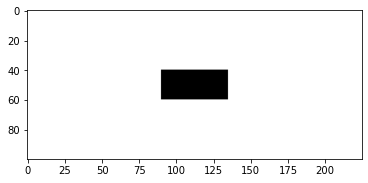

In [210]:
fig,ax = plt.subplots()
arr = env.frame_array.copy()
win = cv2.cvtColor(rect_out_rast(env.window_y,env.window_x,env.T_HEIGHT,env.T_WIDTH), cv2.COLOR_GRAY2RGB)
arr[env.window_y:env.window_y+env.T_HEIGHT,env.window_x:env.window_x+env.T_WIDTH] = win
ax.imshow(arr)

In [205]:
# global variables
SIMILARTY_THRESHOLD = 113
MAX_STEPS = 100
TOTAL_EPISODES = 2000

EPISODE 0
Setting new episode.
Previous action was None
Point is (280, 90)


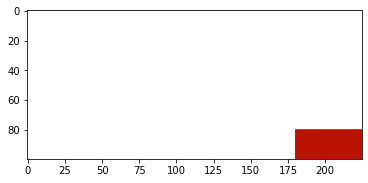

5
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Point never used
Action is 5, Northeast
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 1
Setting new episode.
Previous action was None
Point is (60, 180)


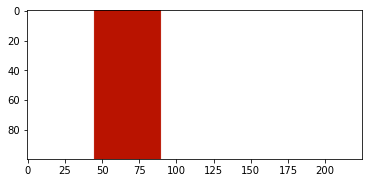

7
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 7, Southeast
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 2
Setting new episode.
Previous action was None
Point is (60, 360)


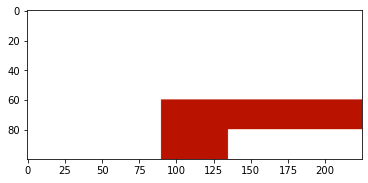

1
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 3
Setting new episode.
Previous action was None
Point is (240, 0)


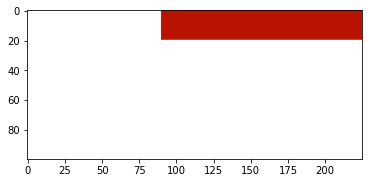

5
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 4
Setting new episode.
Previous action was None
Point is (40, 225)


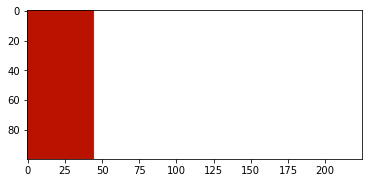

0
Point never used
Point never used
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Action is 0, South
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 5
Setting new episode.
Previous action was None
Point is (340, 405)


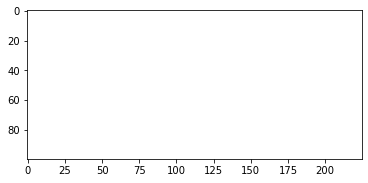

6
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 6
Setting new episode.
Previous action was None
Point is (0, 180)


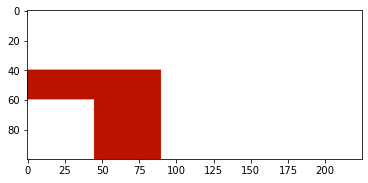

6
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 7
Setting new episode.
Previous action was None
Point is (320, 450)


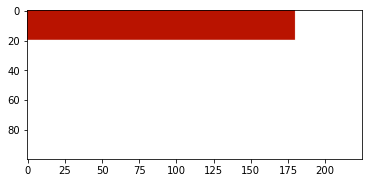

3
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 8
Setting new episode.
Previous action was None
Point is (460, 450)


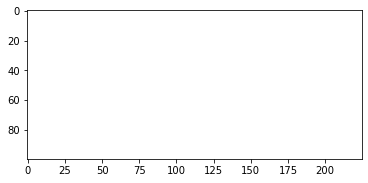

4
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 9
Setting new episode.
Previous action was None
Point is (380, 360)


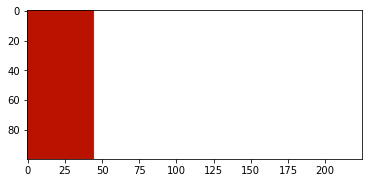

7
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 10
Setting new episode.
Previous action was None
Point is (260, 225)


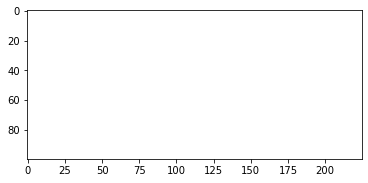

3
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 3, Northwest
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 11
Setting new episode.
Previous action was None
Point is (40, 45)


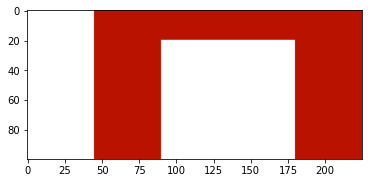

4
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Action Not Possible
Clearing
EPISODE 12
Setting new episode.
Previous action was None
Point is (100, 450)


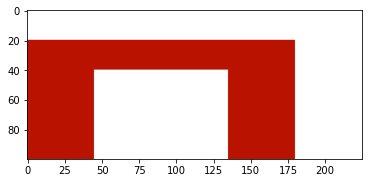

5
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 13
Setting new episode.
Previous action was None
Point is (240, 495)


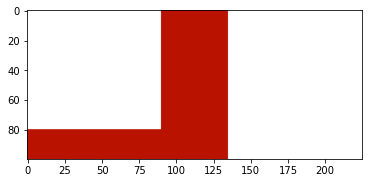

5
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Action Not Possible
Clearing
EPISODE 14
Setting new episode.
Previous action was None
Point is (120, 495)


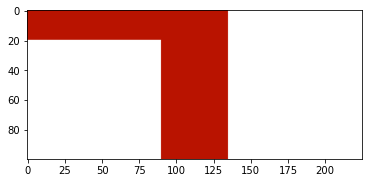

3
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Action Not Possible
Clearing
EPISODE 15
Setting new episode.
Previous action was None
Point is (60, 360)


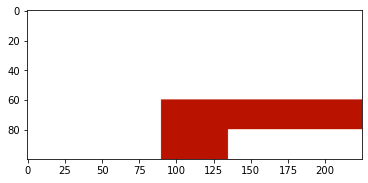

3
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 16
Setting new episode.
Previous action was None
Point is (420, 270)


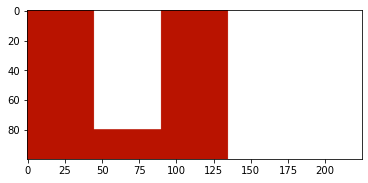

7
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 17
Setting new episode.
Previous action was None
Point is (280, 225)


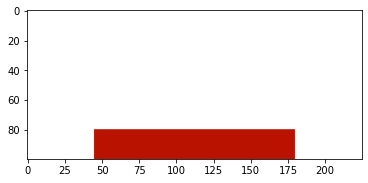

6
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 6, East
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 18
Setting new episode.
Previous action was None
Point is (60, 495)


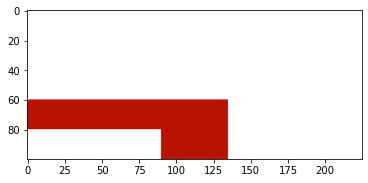

4
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Action Not Possible
Clearing
EPISODE 19
Setting new episode.
Previous action was None
Point is (180, 405)


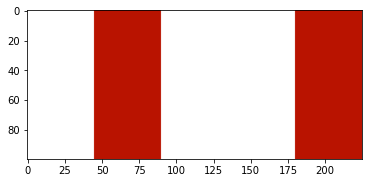

4
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 20
Setting new episode.
Previous action was None
Point is (200, 315)


/var/folders/ww/12z6q0wj4c527ftkk7sxqb680000gp/T/ipykernel_42225/2697068939.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots()


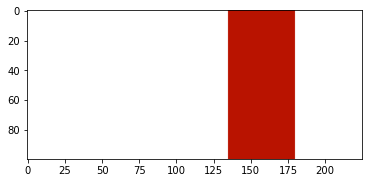

1
Termination point is outside of the border
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action is 1, Southwest
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 21
Setting new episode.
Previous action was None
Point is (100, 450)


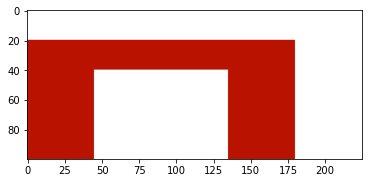

1
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 22
Setting new episode.
Previous action was None
Point is (360, 450)


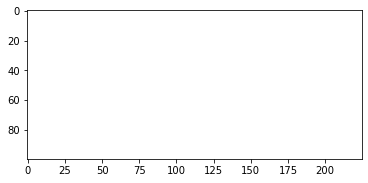

1
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 23
Setting new episode.
Previous action was None
Point is (140, 405)


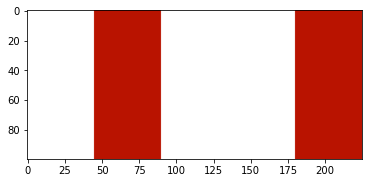

2
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 24
Setting new episode.
Previous action was None
Point is (380, 315)


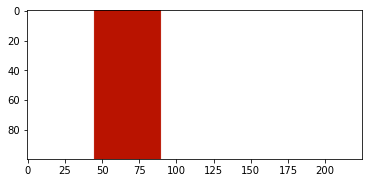

2
Termination point is outside of the border
Termination point is outside of the border
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action is 2, West
Moves remaining, 7
SSD result is 120.0
No match, next epsiode
Clearing
EPISODE 25
Setting new episode.
Previous action was None
Point is (40, 315)


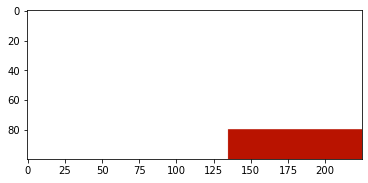

1
Termination point is outside of the border
Point never used
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Action is 1, Southwest
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 26
Setting new episode.
Previous action was None
Point is (100, 225)


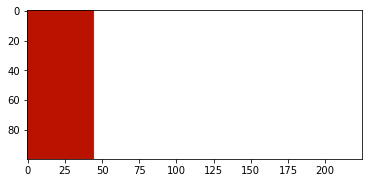

0
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 0, South
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 27
Setting new episode.
Previous action was None
Point is (0, 90)


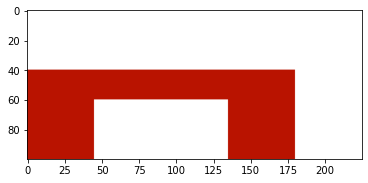

2
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 28
Setting new episode.
Previous action was None
Point is (240, 180)


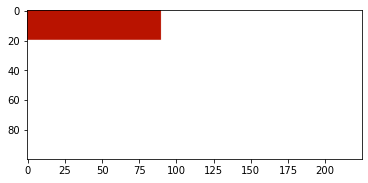

6
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 6, East
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 29
Setting new episode.
Previous action was None
Point is (240, 180)


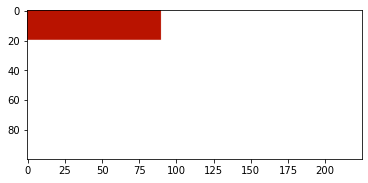

4
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 4, North
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 30
Setting new episode.
Previous action was None
Point is (420, 45)


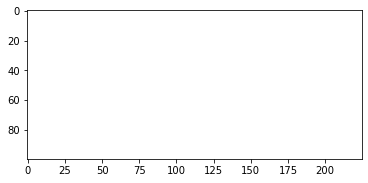

6
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 31
Setting new episode.
Previous action was None
Point is (240, 225)


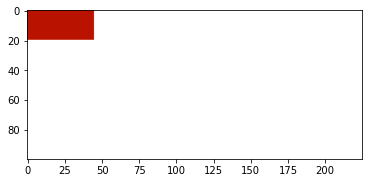

4
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 4, North
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 32
Setting new episode.
Previous action was None
Point is (220, 45)


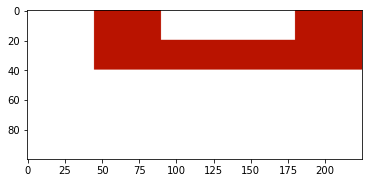

7
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Action is 7, Southeast
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 33
Setting new episode.
Previous action was None
Point is (280, 360)


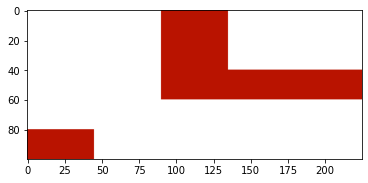

2
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 34
Setting new episode.
Previous action was None
Point is (280, 495)


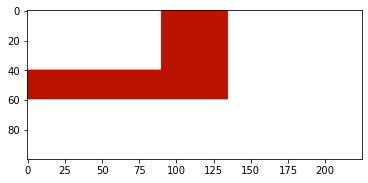

3
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Action Not Possible
Clearing
EPISODE 35
Setting new episode.
Previous action was None
Point is (280, 90)


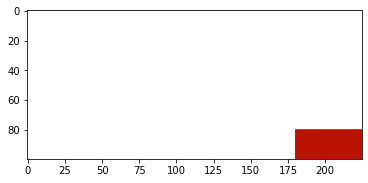

0
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Point never used
Action is 0, South
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 36
Setting new episode.
Previous action was None
Point is (340, 180)


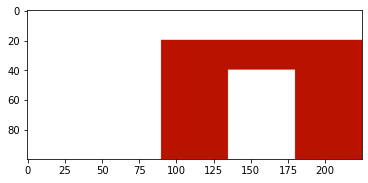

7
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 7, Southeast
Moves remaining, 7
SSD result is 0.0
Match
Previous action was 7
Point is (340, 180)


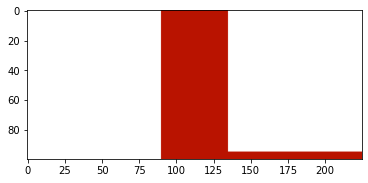

5
Point never used
Point never used
Point never used
Early close attempt possible. Remove.
Point never used
Point never used
Point never used
Point never used
Action is 5, Northeast
Moves remaining, 7
SSD result is 69.33333333333333
Match
Previous action was 5
Point is (360, 225)


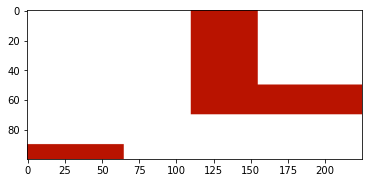

6
Point never used
Point already used
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 37
Setting new episode.
Previous action was None
Point is (180, 270)


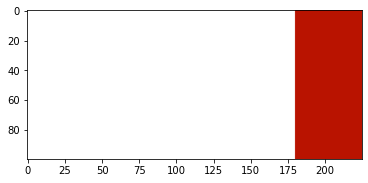

4
Point never used
Point never used
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action is 4, North
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 38
Setting new episode.
Previous action was None
Point is (260, 225)


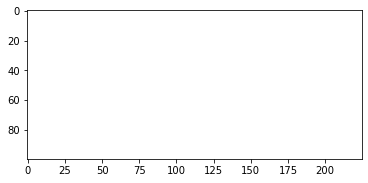

3
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 3, Northwest
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 39
Setting new episode.
Previous action was None
Point is (460, 0)


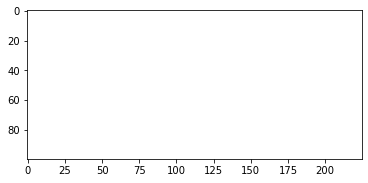

1
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 40
Setting new episode.
Previous action was None
Point is (20, 0)


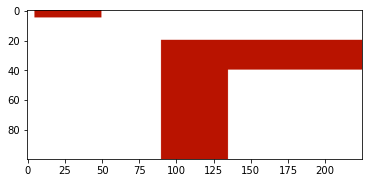

0
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 41
Setting new episode.
Previous action was None
Point is (140, 315)


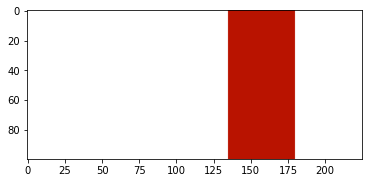

5
Termination point is outside of the border
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 42
Setting new episode.
Previous action was None
Point is (400, 315)


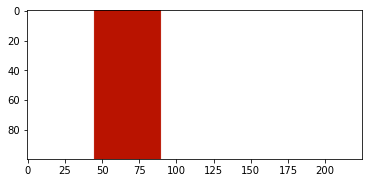

7
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 43
Setting new episode.
Previous action was None
Point is (400, 180)


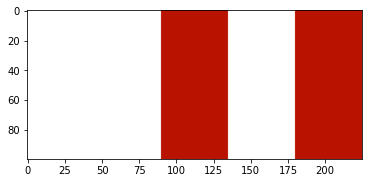

3
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Action is 3, Northwest
Moves remaining, 7
SSD result is 69.33333333333333
Match
Previous action was 3
Point is (400, 180)


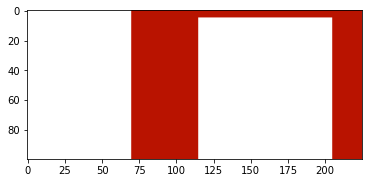

4
Termination point is outside of the border
Termination point is outside of the border
Point never used
Point never used
Point never used
Point never used
Point never used
Early close attempt possible. Remove.
Action is 4, North
Moves remaining, 7
SSD result is 0.0
Match
Previous action was 4
Point is (380, 135)


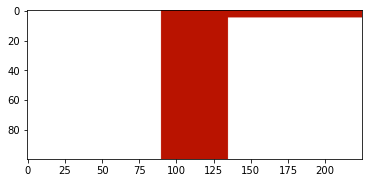

7
Point already used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 7, Southeast
Moves remaining, 7
SSD result is 69.33333333333333
Match
Previous action was 7
Point is (360, 135)


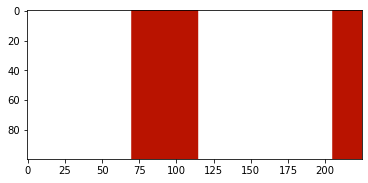

1
Termination point is outside of the border
Point already used
Point already used
Point never used
Point never used
Point never used
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 44
Setting new episode.
Previous action was None
Point is (140, 270)


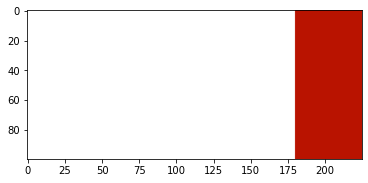

6
Point never used
Point never used
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 45
Setting new episode.
Previous action was None
Point is (320, 0)


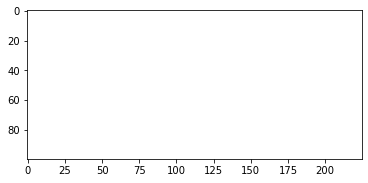

1
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 46
Setting new episode.
Previous action was None
Point is (340, 360)


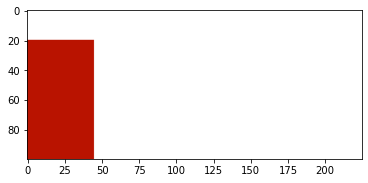

2
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 47
Setting new episode.
Previous action was None
Point is (100, 225)


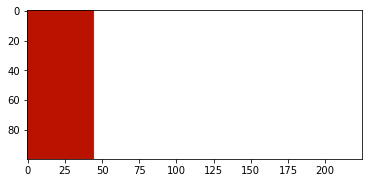

4
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 4, North
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 48
Setting new episode.
Previous action was None
Point is (320, 135)


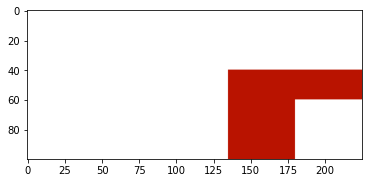

2
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 2, West
Moves remaining, 7
SSD result is 53.333333333333336
Match
Previous action was 2
Point is (320, 135)


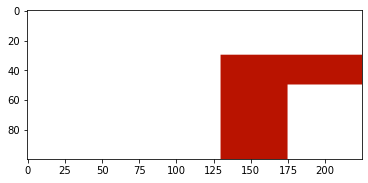

6
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Early close attempt possible. Remove.
Point never used
Action Not Possible
Clearing
EPISODE 49
Setting new episode.
Previous action was None
Point is (440, 0)


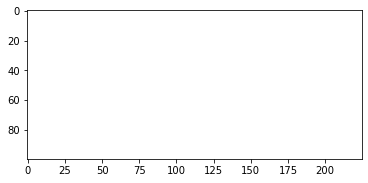

1
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 50
Setting new episode.
Previous action was None
Point is (60, 495)


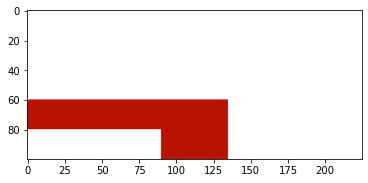

3
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Action Not Possible
Clearing
EPISODE 51
Setting new episode.
Previous action was None
Point is (120, 270)


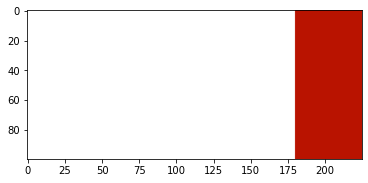

6
Point never used
Point never used
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 52
Setting new episode.
Previous action was None
Point is (300, 225)


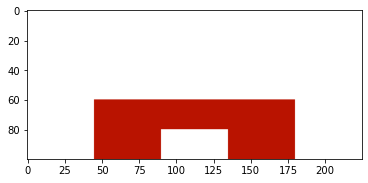

4
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 4, North
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 53
Setting new episode.
Previous action was None
Point is (460, 270)


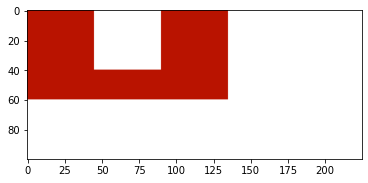

7
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 54
Setting new episode.
Previous action was None
Point is (180, 0)


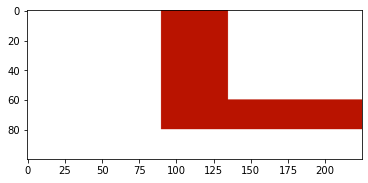

7
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 55
Setting new episode.
Previous action was None
Point is (180, 315)


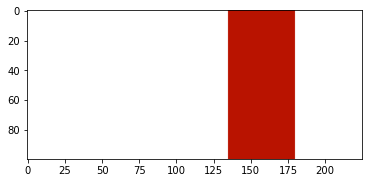

6
Termination point is outside of the border
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 56
Setting new episode.
Previous action was None
Point is (40, 225)


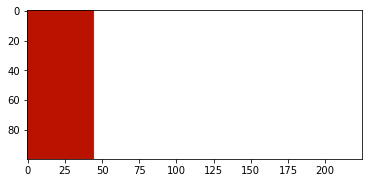

0
Point never used
Point never used
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Action is 0, South
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 57
Setting new episode.
Previous action was None
Point is (400, 90)


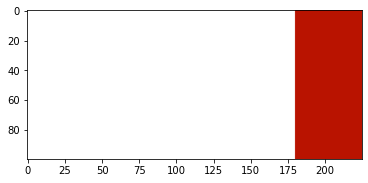

0
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 58
Setting new episode.
Previous action was None
Point is (220, 360)


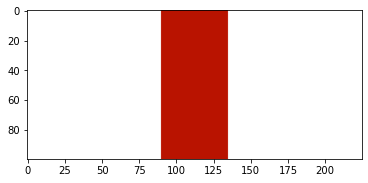

5
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 59
Setting new episode.
Previous action was None
Point is (260, 450)


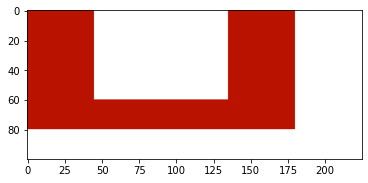

5
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 60
Setting new episode.
Previous action was None
Point is (120, 270)


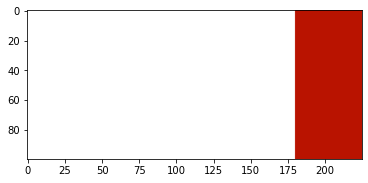

2
Point never used
Point never used
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action is 2, West
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 61
Setting new episode.
Previous action was None
Point is (360, 360)


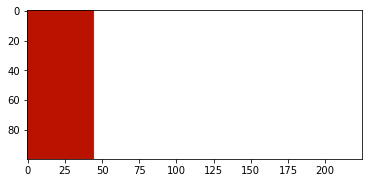

3
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 62
Setting new episode.
Previous action was None
Point is (340, 0)


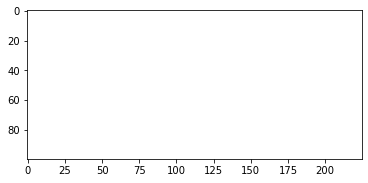

0
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 63
Setting new episode.
Previous action was None
Point is (240, 45)


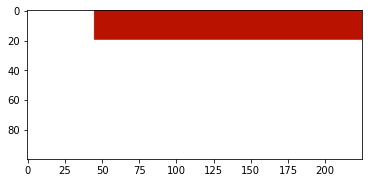

7
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Action is 7, Southeast
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 64
Setting new episode.
Previous action was None
Point is (300, 45)


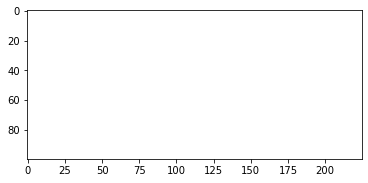

2
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Action Not Possible
Clearing
EPISODE 65
Setting new episode.
Previous action was None
Point is (240, 270)


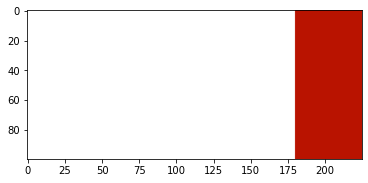

0
Point never used
Point never used
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action is 0, South
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 66
Setting new episode.
Previous action was None
Point is (460, 495)


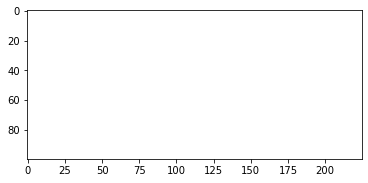

5
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Action Not Possible
Clearing
EPISODE 67
Setting new episode.
Previous action was None
Point is (80, 270)


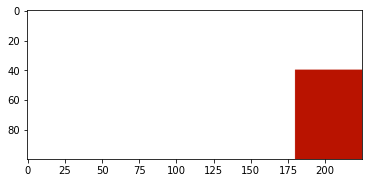

4
Point never used
Point never used
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action is 4, North
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 68
Setting new episode.
Previous action was None
Point is (200, 225)


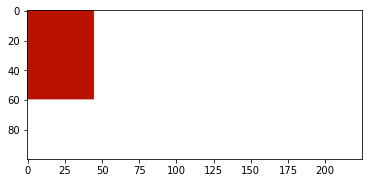

4
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 4, North
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 69
Setting new episode.
Previous action was None
Point is (360, 45)


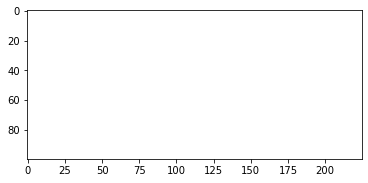

7
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Action is 7, Southeast
Moves remaining, 7
SSD result is 120.0
No match, next epsiode
Clearing
EPISODE 70
Setting new episode.
Previous action was None
Point is (260, 90)


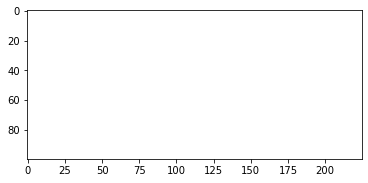

3
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Point never used
Action Not Possible
Clearing
EPISODE 71
Setting new episode.
Previous action was None
Point is (40, 495)


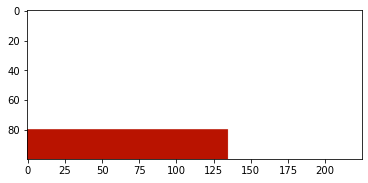

1
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Action Not Possible
Clearing
EPISODE 72
Setting new episode.
Previous action was None
Point is (460, 360)


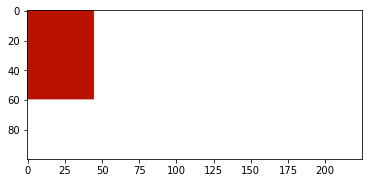

2
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 73
Setting new episode.
Previous action was None
Point is (20, 270)


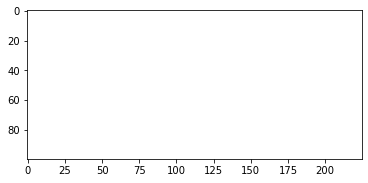

1
Point never used
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Termination point is outside of the border
Action is 1, Southwest
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 74
Setting new episode.
Previous action was None
Point is (400, 90)


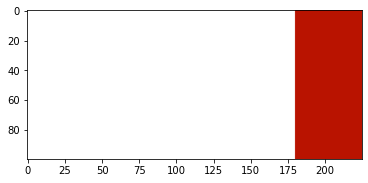

6
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 75
Setting new episode.
Previous action was None
Point is (280, 135)


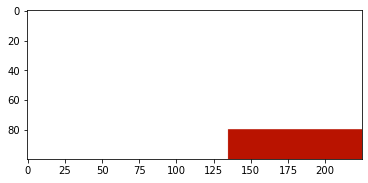

6
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 6, East
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 76
Setting new episode.
Previous action was None
Point is (460, 0)


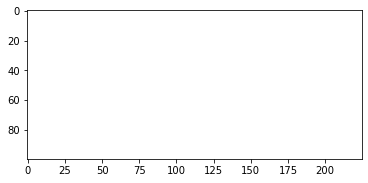

1
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 77
Setting new episode.
Previous action was None
Point is (200, 405)


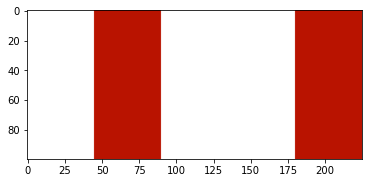

5
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 78
Setting new episode.
Previous action was None
Point is (260, 315)


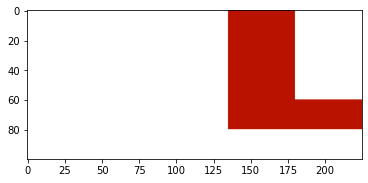

7
Termination point is outside of the border
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 79
Setting new episode.
Previous action was None
Point is (400, 0)


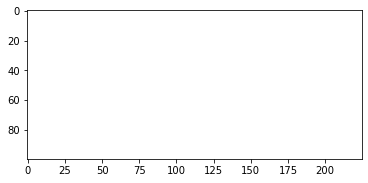

4
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 80
Setting new episode.
Previous action was None
Point is (20, 495)


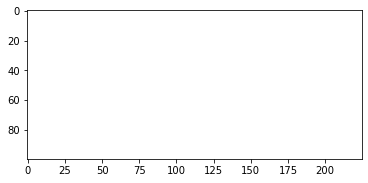

0
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Action Not Possible
Clearing
EPISODE 81
Setting new episode.
Previous action was None
Point is (320, 315)


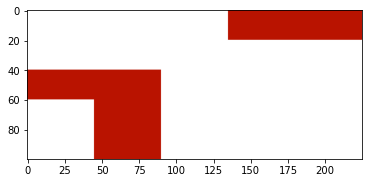

0
Termination point is outside of the border
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 82
Setting new episode.
Previous action was None
Point is (300, 405)


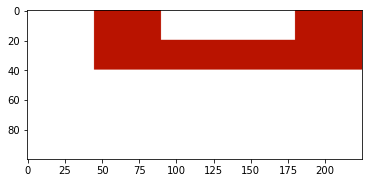

2
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 83
Setting new episode.
Previous action was None
Point is (40, 405)


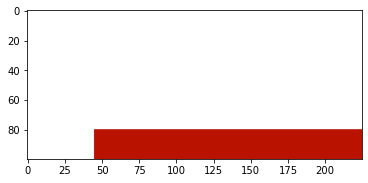

2
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 84
Setting new episode.
Previous action was None
Point is (360, 0)


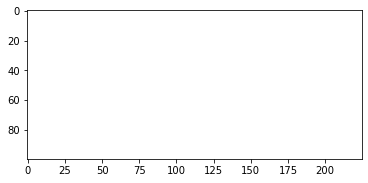

3
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 85
Setting new episode.
Previous action was None
Point is (220, 360)


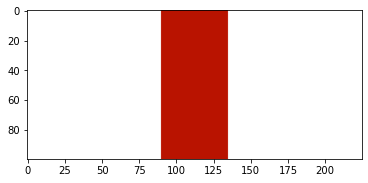

0
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 86
Setting new episode.
Previous action was None
Point is (0, 450)


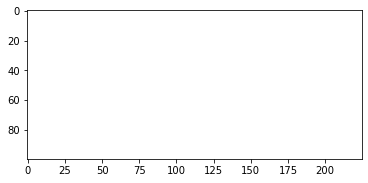

7
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 87
Setting new episode.
Previous action was None
Point is (0, 270)


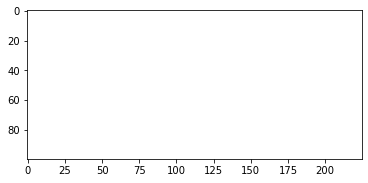

3
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 88
Setting new episode.
Previous action was None
Point is (120, 495)


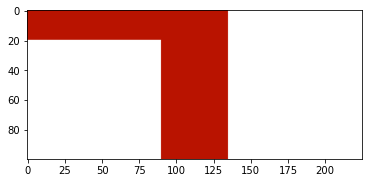

3
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Action Not Possible
Clearing
EPISODE 89
Setting new episode.
Previous action was None
Point is (300, 450)


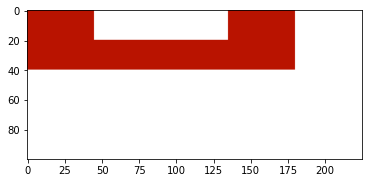

0
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 90
Setting new episode.
Previous action was None
Point is (460, 45)


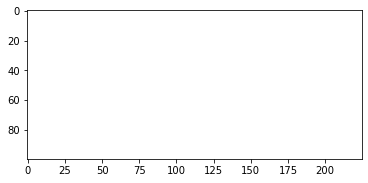

0
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 91
Setting new episode.
Previous action was None
Point is (340, 45)


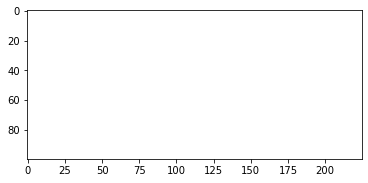

5
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Action is 5, Northeast
Moves remaining, 7
SSD result is 53.333333333333336
Match
Previous action was 5
Point is (340, 45)


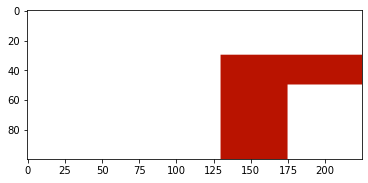

5
Point never used
Early close attempt possible. Remove.
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Point never used
Action is 5, Northeast
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 92
Setting new episode.
Previous action was None
Point is (220, 315)


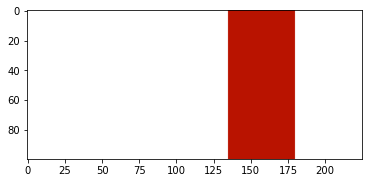

5
Termination point is outside of the border
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 93
Setting new episode.
Previous action was None
Point is (40, 360)


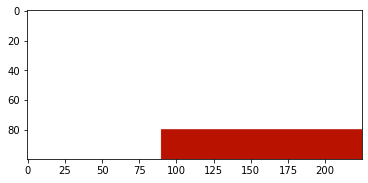

3
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 94
Setting new episode.
Previous action was None
Point is (400, 180)


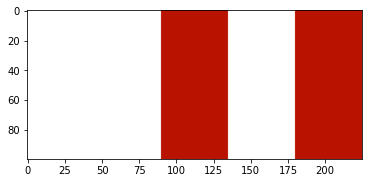

1
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 95
Setting new episode.
Previous action was None
Point is (380, 90)


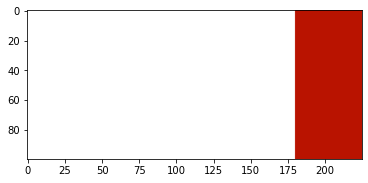

5
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Termination point is outside of the border
Action is 5, Northeast
Moves remaining, 7
SSD result is 0.0
Match
Previous action was 5
Point is (380, 90)


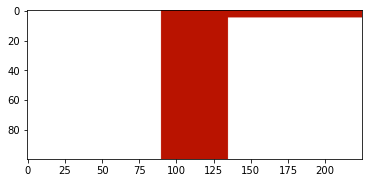

0
Point never used
Early close attempt possible. Remove.
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 0, South
Moves remaining, 7
SSD result is 69.33333333333333
Match
Previous action was 0
Point is (360, 135)


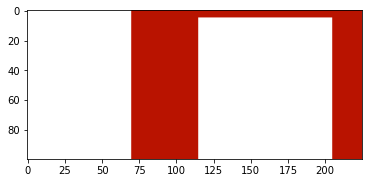

3
Termination point is outside of the border
Termination point is outside of the border
Point never used
Point already used
Point never used
Point never used
Termination point is outside of the border
Action is 3, Northwest
Moves remaining, 7
SSD result is 0.0
Match
Previous action was 3
Point is (380, 135)


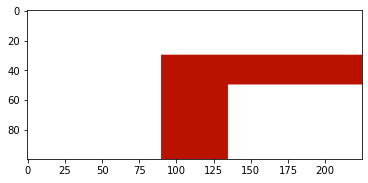

7
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point already used
Point already used
Action Not Possible
Clearing
EPISODE 96
Setting new episode.
Previous action was None
Point is (340, 360)


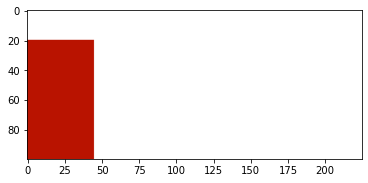

6
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 97
Setting new episode.
Previous action was None
Point is (440, 270)


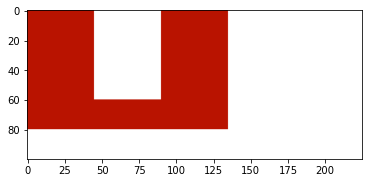

3
Point is within buffer edge of border
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 98
Setting new episode.
Previous action was None
Point is (80, 0)


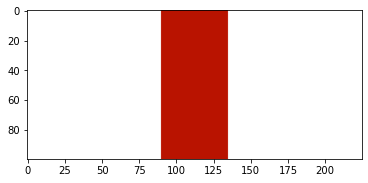

7
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 99
Setting new episode.
Previous action was None
Point is (100, 225)


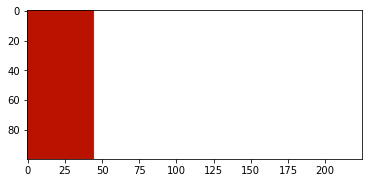

6
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 6, East
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 100
Setting new episode.
Previous action was None
Point is (260, 180)


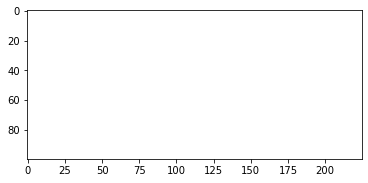

2
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 2, West
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 101
Setting new episode.
Previous action was None
Point is (20, 180)


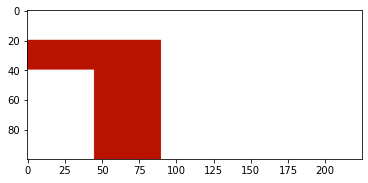

5
Point never used
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Action Not Possible
Clearing
EPISODE 102
Setting new episode.
Previous action was None
Point is (120, 135)


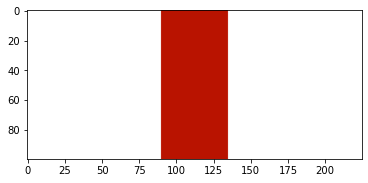

7
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 7, Southeast
Moves remaining, 7
SSD result is 60.0
Match
Previous action was 7
Point is (120, 135)


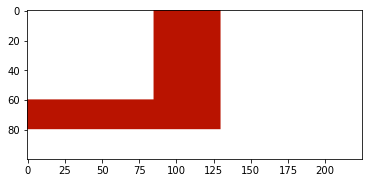

5
Point never used
Point never used
Point never used
Early close attempt possible. Remove.
Point never used
Point never used
Point never used
Point never used
Action is 5, Northeast
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 103
Setting new episode.
Previous action was None
Point is (0, 90)


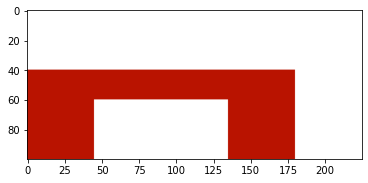

4
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 104
Setting new episode.
Previous action was None
Point is (200, 225)


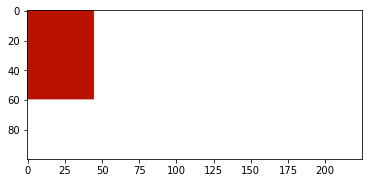

5
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 5, Northeast
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 105
Setting new episode.
Previous action was None
Point is (320, 90)


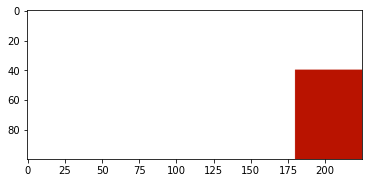

2
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Point never used
Action Not Possible
Clearing
EPISODE 106
Setting new episode.
Previous action was None
Point is (180, 405)


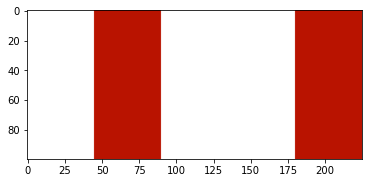

0
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 107
Setting new episode.
Previous action was None
Point is (460, 450)


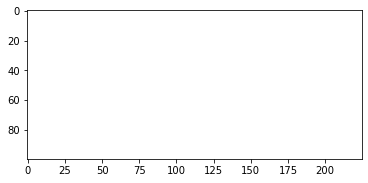

6
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 108
Setting new episode.
Previous action was None
Point is (280, 360)


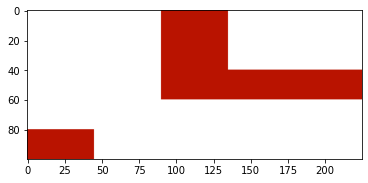

4
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 109
Setting new episode.
Previous action was None
Point is (340, 405)


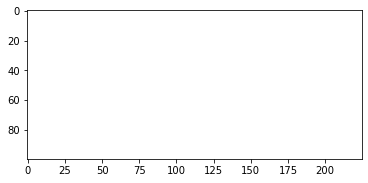

2
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 110
Setting new episode.
Previous action was None
Point is (80, 450)


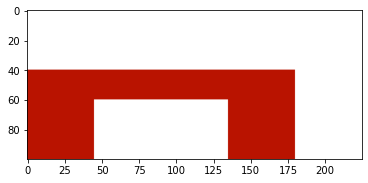

6
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 111
Setting new episode.
Previous action was None
Point is (160, 90)


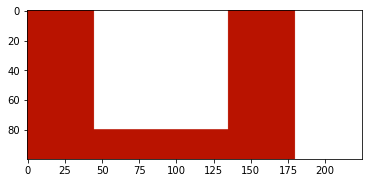

5
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Point never used
Action is 5, Northeast
Moves remaining, 7
SSD result is 60.0
Match
Previous action was 5
Point is (160, 90)


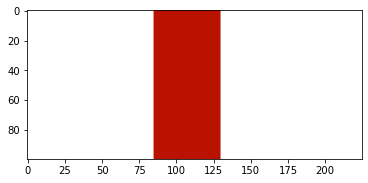

2
Point never used
Early close attempt possible. Remove.
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 2, West
Moves remaining, 7
SSD result is 60.0
Match
Previous action was 2
Point is (140, 135)


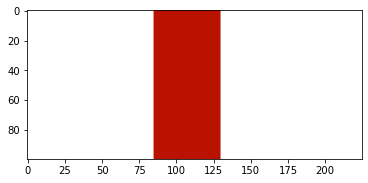

0
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point already used
Point never used
Action is 0, South
Moves remaining, 7
SSD result is 129.33333333333334
No match, next epsiode
Clearing
EPISODE 112
Setting new episode.
Previous action was None
Point is (0, 0)


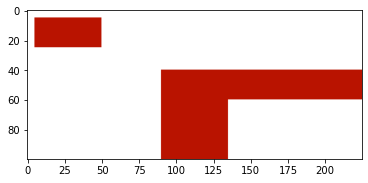

7
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 113
Setting new episode.
Previous action was None
Point is (20, 45)


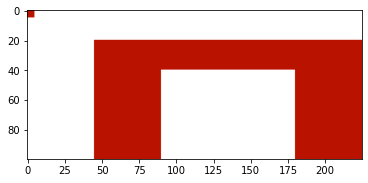

1
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Action Not Possible
Clearing
EPISODE 114
Setting new episode.
Previous action was None
Point is (220, 0)


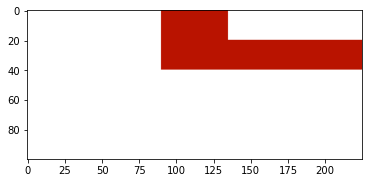

0
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 115
Setting new episode.
Previous action was None
Point is (460, 315)


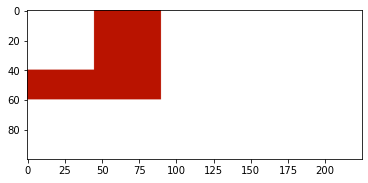

1
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 116
Setting new episode.
Previous action was None
Point is (160, 315)


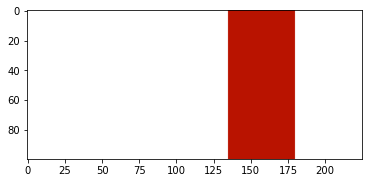

0
Termination point is outside of the border
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 117
Setting new episode.
Previous action was None
Point is (240, 225)


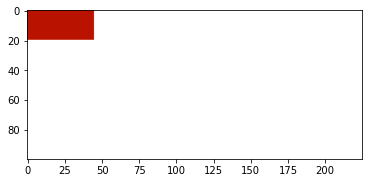

6
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 6, East
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 118
Setting new episode.
Previous action was None
Point is (240, 405)


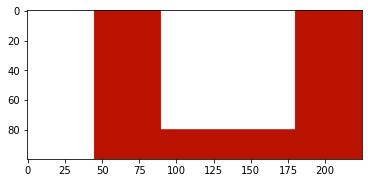

7
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 119
Setting new episode.
Previous action was None
Point is (160, 45)


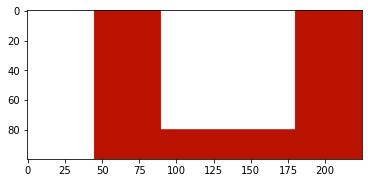

3
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Action Not Possible
Clearing
EPISODE 120
Setting new episode.
Previous action was None
Point is (300, 450)


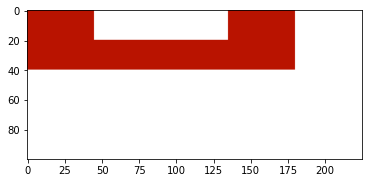

0
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 121
Setting new episode.
Previous action was None
Point is (400, 495)


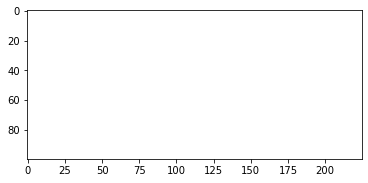

6
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Action Not Possible
Clearing
EPISODE 122
Setting new episode.
Previous action was None
Point is (360, 405)


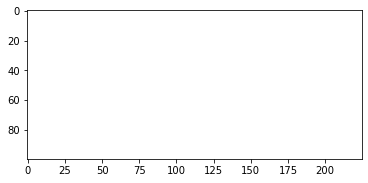

3
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 123
Setting new episode.
Previous action was None
Point is (0, 450)


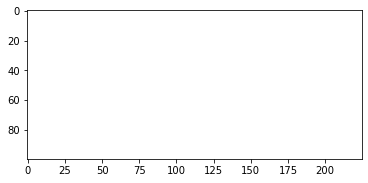

5
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 124
Setting new episode.
Previous action was None
Point is (420, 495)


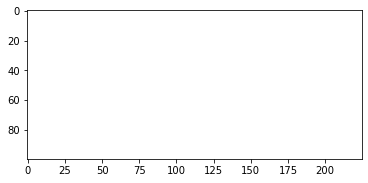

0
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Action Not Possible
Clearing
EPISODE 125
Setting new episode.
Previous action was None
Point is (460, 450)


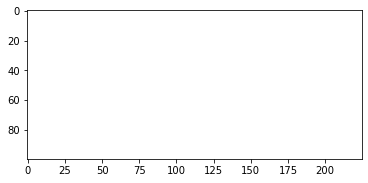

4
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 126
Setting new episode.
Previous action was None
Point is (400, 405)


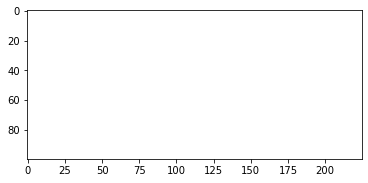

6
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 127
Setting new episode.
Previous action was None
Point is (0, 495)


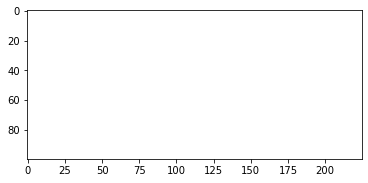

0
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is not on image
Point is not on image
Action Not Possible
Clearing
EPISODE 128
Setting new episode.
Previous action was None
Point is (280, 495)


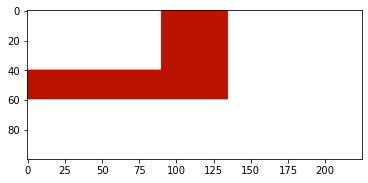

6
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Action Not Possible
Clearing
EPISODE 129
Setting new episode.
Previous action was None
Point is (0, 90)


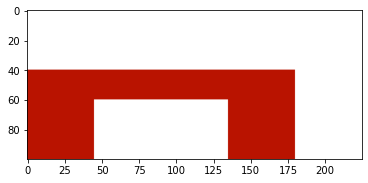

5
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 130
Setting new episode.
Previous action was None
Point is (400, 315)


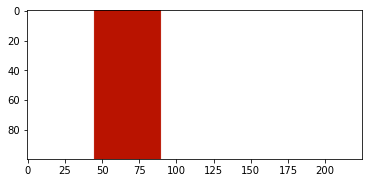

6
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 131
Setting new episode.
Previous action was None
Point is (100, 45)


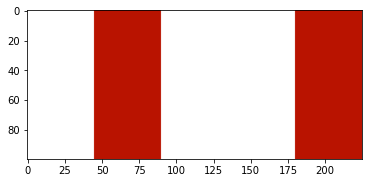

6
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Action is 6, East
Moves remaining, 7
SSD result is 164.0
No match, next epsiode
Clearing
EPISODE 132
Setting new episode.
Previous action was None
Point is (300, 450)


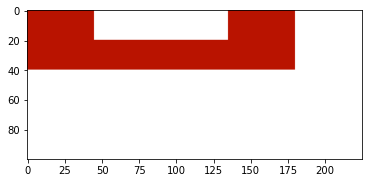

5
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 133
Setting new episode.
Previous action was None
Point is (240, 405)


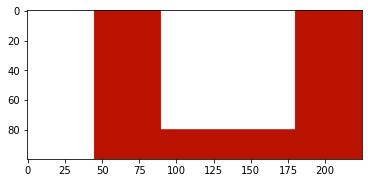

6
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 134
Setting new episode.
Previous action was None
Point is (40, 90)


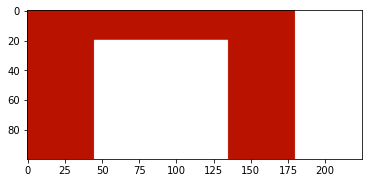

0
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Action is 0, South
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 135
Setting new episode.
Previous action was None
Point is (300, 180)


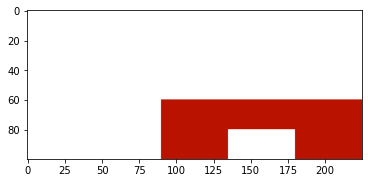

4
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 4, North
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 136
Setting new episode.
Previous action was None
Point is (380, 360)


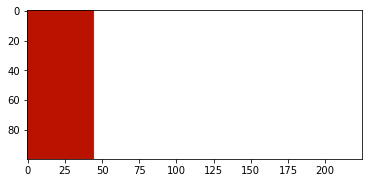

3
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 137
Setting new episode.
Previous action was None
Point is (140, 270)


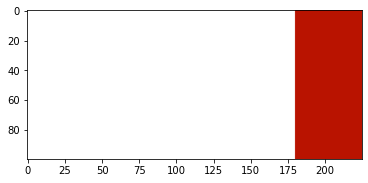

5
Point never used
Point never used
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 138
Setting new episode.
Previous action was None
Point is (340, 45)


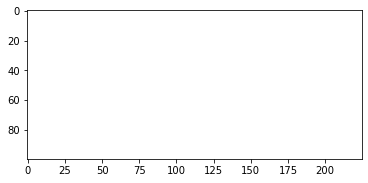

7
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Action is 7, Southeast
Moves remaining, 7
SSD result is 0.0
Match
Previous action was 7
Point is (340, 45)


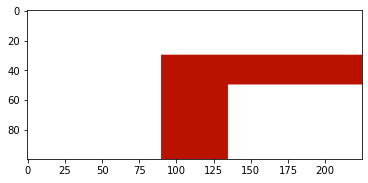

6
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Early close attempt possible. Remove.
Point never used
Point never used
Point never used
Point never used
Action is 6, East
Moves remaining, 7
SSD result is 0.0
Match
Previous action was 6
Point is (360, 90)


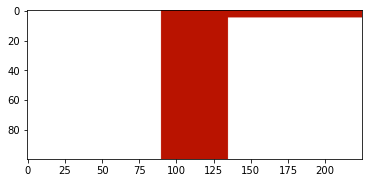

6
Point never used
Point never used
Point already used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 6, East
Moves remaining, 7
SSD result is 0.0
Match
Previous action was 6
Point is (360, 135)


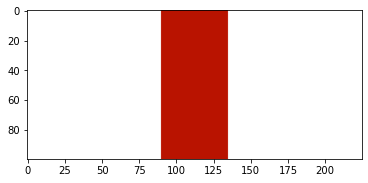

7
Point never used
Point never used
Point already used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 7, Southeast
Moves remaining, 7
SSD result is 69.33333333333333
Match
Previous action was 7
Point is (360, 180)


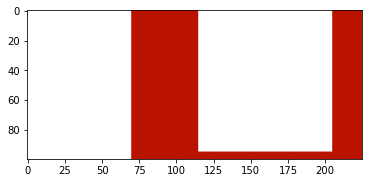

4
Termination point is outside of the border
Termination point is outside of the border
Point never used
Point already used
Point never used
Point never used
Point never used
Termination point is outside of the border
Action is 4, North
Moves remaining, 7
SSD result is 0.0
Match
Previous action was 4
Point is (380, 225)


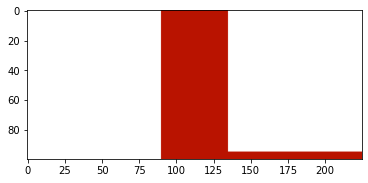

4
Point already used
Point never used
Point already used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 4, North
Moves remaining, 7
SSD result is 69.33333333333333
Match
Previous action was 4
Point is (360, 225)


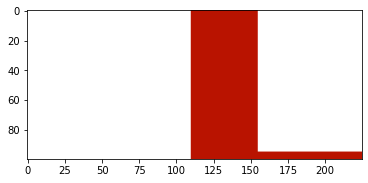

0
Point already used
Point already used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action Not Possible
Clearing
EPISODE 139
Setting new episode.
Previous action was None
Point is (160, 450)


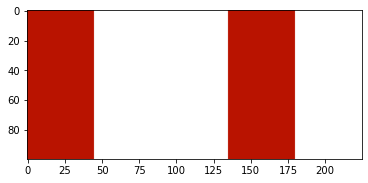

6
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 140
Setting new episode.
Previous action was None
Point is (400, 360)


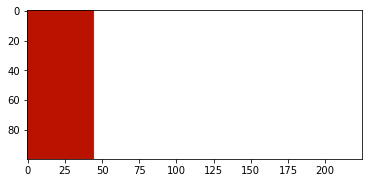

4
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 141
Setting new episode.
Previous action was None
Point is (300, 405)


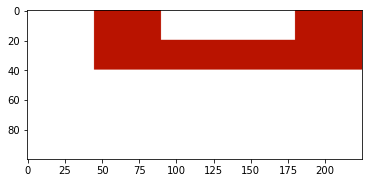

3
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 142
Setting new episode.
Previous action was None
Point is (420, 495)


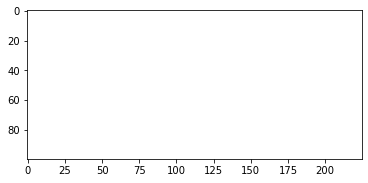

0
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Action Not Possible
Clearing
EPISODE 143
Setting new episode.
Previous action was None
Point is (420, 270)


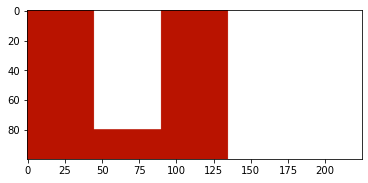

4
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 144
Setting new episode.
Previous action was None
Point is (100, 180)


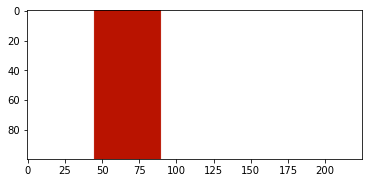

0
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 0, South
Moves remaining, 7
SSD result is 94.66666666666667
Match
Previous action was 0
Point is (100, 180)


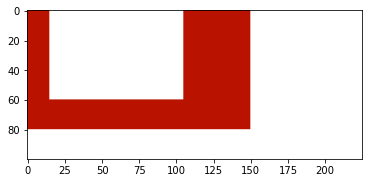

2
Point never used
Point never used
Point never used
Point never used
Early close attempt possible. Remove.
Point never used
Point never used
Point never used
Action is 2, West
Moves remaining, 7
SSD result is 94.66666666666667
Match
Previous action was 2
Point is (120, 180)


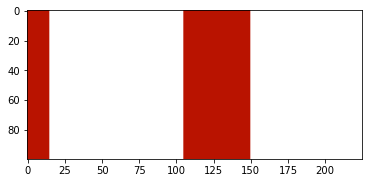

0
Point never used
Point never used
Point never used
Point never used
Point never used
Point already used
Point never used
Action is 0, South
Moves remaining, 7
SSD result is 60.0
Match
Previous action was 0
Point is (120, 135)


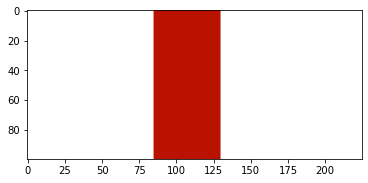

5
Point never used
Point never used
Point never used
Point never used
Point already used
Point already used
Point never used
Point never used
Action Not Possible
Clearing
EPISODE 145
Setting new episode.
Previous action was None
Point is (460, 270)


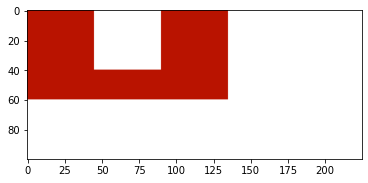

7
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 146
Setting new episode.
Previous action was None
Point is (440, 0)


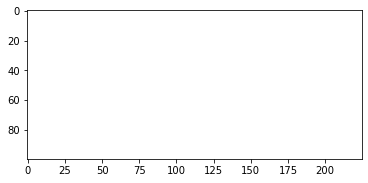

2
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 147
Setting new episode.
Previous action was None
Point is (20, 135)


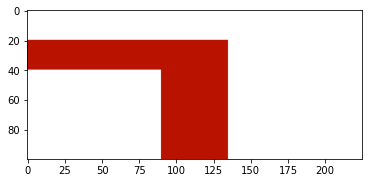

2
Point never used
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Action Not Possible
Clearing
EPISODE 148
Setting new episode.
Previous action was None
Point is (340, 90)


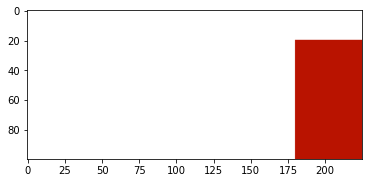

5
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Point never used
Action is 5, Northeast
Moves remaining, 7
SSD result is 53.333333333333336
Match
Previous action was 5
Point is (340, 90)


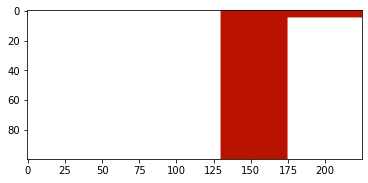

7
Point never used
Early close attempt possible. Remove.
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 7, Southeast
Moves remaining, 7
SSD result is 69.33333333333333
Match
Previous action was 7
Point is (320, 135)


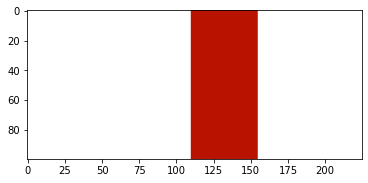

7
Point never used
Point never used
Point never used
Point already used
Point never used
Point never used
Point never used
Point never used
Action is 7, Southeast
Moves remaining, 7
SSD result is 0.0
Match
Previous action was 7
Point is (340, 180)


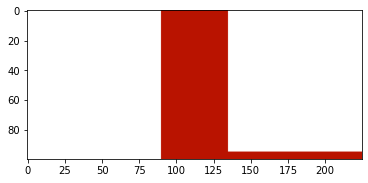

4
Point never used
Point never used
Point never used
Point already used
Point never used
Point never used
Point never used
Point never used
Action is 4, North
Moves remaining, 7
SSD result is 69.33333333333333
Match
Previous action was 4
Point is (360, 225)


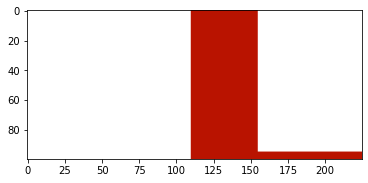

4
Point already used
Point never used
Point already used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 4, North
Moves remaining, 7
SSD result is 53.333333333333336
Match
Previous action was 4
Point is (340, 225)


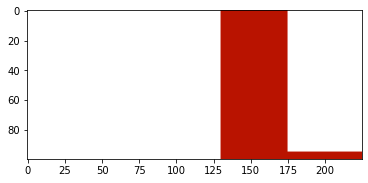

2
Point already used
Point already used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 2, West
Moves remaining, 7
SSD result is 53.333333333333336
Match
Previous action was 2
Point is (320, 225)


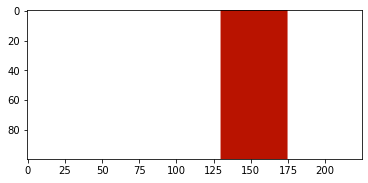

1
Point already used
Point never used
Point already used
Point never used
Point never used
Point never used
Point already used
Point already used
Action is 1, Southwest
Moves remaining, 7
SSD result is 69.33333333333333
Match
Previous action was 1
Point is (320, 180)


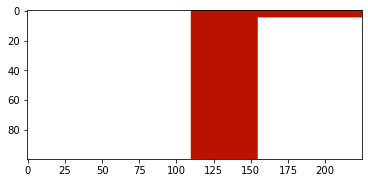

5
Point never used
Point never used
Point never used
Point already used
Point already used
Point already used
Point never used
Action Not Possible
Clearing
EPISODE 149
Setting new episode.
Previous action was None
Point is (100, 270)


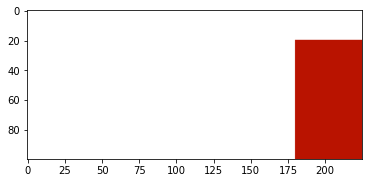

1
Point never used
Point never used
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action is 1, Southwest
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 150
Setting new episode.
Previous action was None
Point is (360, 180)


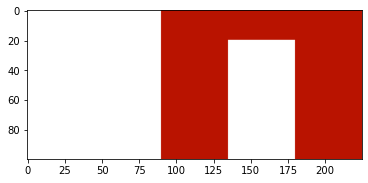

5
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 5, Northeast
Moves remaining, 7
SSD result is 69.33333333333333
Match
Previous action was 5
Point is (360, 180)


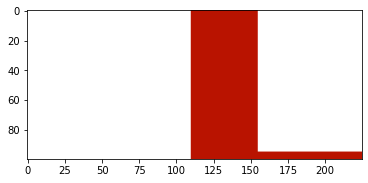

0
Point never used
Early close attempt possible. Remove.
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 0, South
Moves remaining, 7
SSD result is 0.0
Match
Previous action was 0
Point is (340, 225)


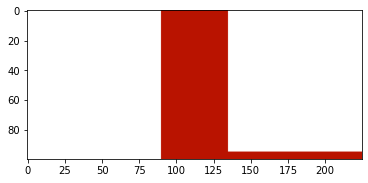

2
Point never used
Point never used
Point never used
Point already used
Point never used
Point never used
Point never used
Action is 2, West
Moves remaining, 7
SSD result is 0.0
Match
Episode origin point visited. Loop created. Next Episode
Clearing
EPISODE 151
Setting new episode.
Previous action was None
Point is (20, 90)


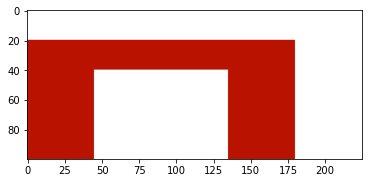

3
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Action Not Possible
Clearing
EPISODE 152
Setting new episode.
Previous action was None
Point is (120, 315)


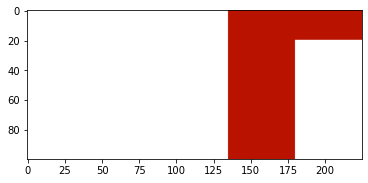

5
Termination point is outside of the border
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 153
Setting new episode.
Previous action was None
Point is (240, 225)


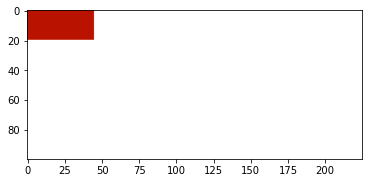

2
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 2, West
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 154
Setting new episode.
Previous action was None
Point is (60, 45)


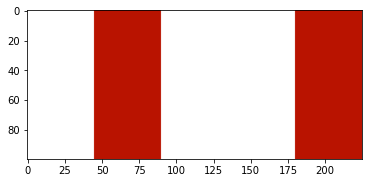

1
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Action Not Possible
Clearing
EPISODE 155
Setting new episode.
Previous action was None
Point is (400, 450)


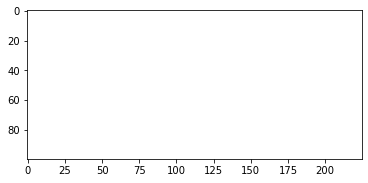

5
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 156
Setting new episode.
Previous action was None
Point is (440, 360)


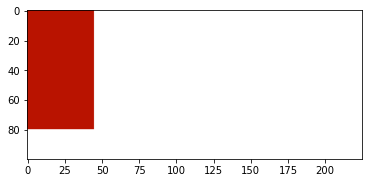

5
Point is within buffer edge of border
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 157
Setting new episode.
Previous action was None
Point is (320, 270)


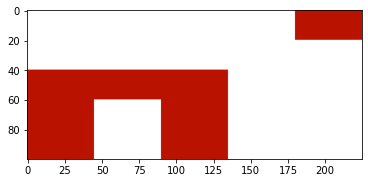

5
Point never used
Point never used
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 158
Setting new episode.
Previous action was None
Point is (100, 135)


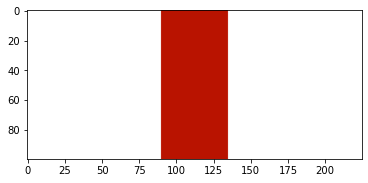

7
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 7, Southeast
Moves remaining, 7
SSD result is 94.66666666666667
Match
Previous action was 7
Point is (100, 135)


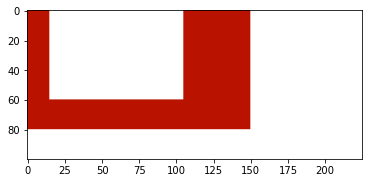

0
Point never used
Point never used
Point never used
Early close attempt possible. Remove.
Point never used
Point never used
Point never used
Point never used
Action is 0, South
Moves remaining, 7
SSD result is 60.0
Match
Previous action was 0
Point is (120, 180)


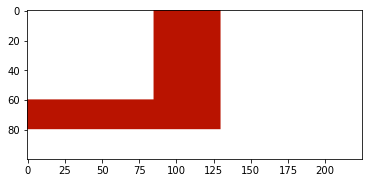

6
Point never used
Point never used
Point never used
Point never used
Point already used
Point never used
Point never used
Point never used
Action is 6, East
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 159
Setting new episode.
Previous action was None
Point is (320, 495)


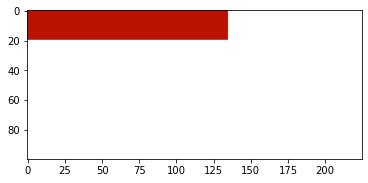

7
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Action Not Possible
Clearing
EPISODE 160
Setting new episode.
Previous action was None
Point is (240, 180)


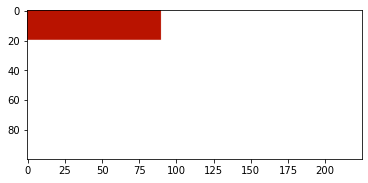

7
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 7, Southeast
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 161
Setting new episode.
Previous action was None
Point is (60, 450)


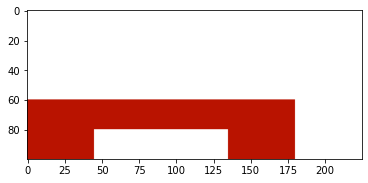

6
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 162
Setting new episode.
Previous action was None
Point is (420, 135)


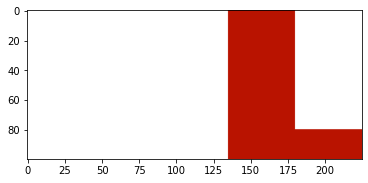

5
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 163
Setting new episode.
Previous action was None
Point is (200, 135)


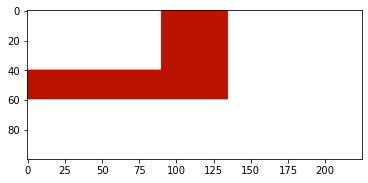

3
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 3, Northwest
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 164
Setting new episode.
Previous action was None
Point is (0, 90)


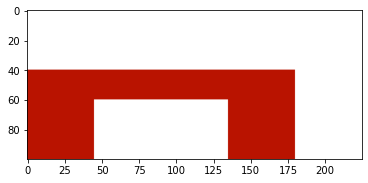

4
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 165
Setting new episode.
Previous action was None
Point is (300, 180)


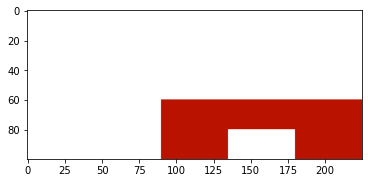

7
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 7, Southeast
Moves remaining, 7
SSD result is 53.333333333333336
Match
Previous action was 7
Point is (300, 180)


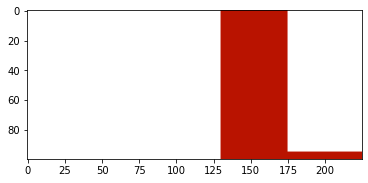

3
Point never used
Point never used
Point never used
Early close attempt possible. Remove.
Point never used
Point never used
Point never used
Point never used
Action Not Possible
Clearing
EPISODE 166
Setting new episode.
Previous action was None
Point is (320, 225)


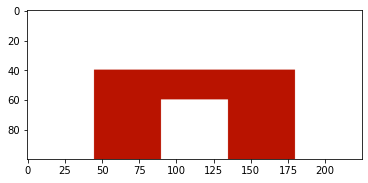

1
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 1, Southwest
Moves remaining, 7
SSD result is 69.33333333333333
Match
Previous action was 1
Point is (320, 225)


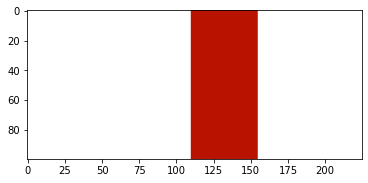

2
Point never used
Point never used
Point never used
Point never used
Point never used
Early close attempt possible. Remove.
Point never used
Point never used
Action is 2, West
Moves remaining, 7
SSD result is 69.33333333333333
Match
Previous action was 2
Point is (340, 180)


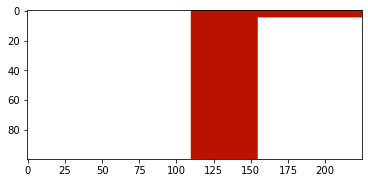

0
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point already used
Point never used
Action is 0, South
Moves remaining, 7
SSD result is 0.0
Match
Previous action was 0
Point is (340, 135)


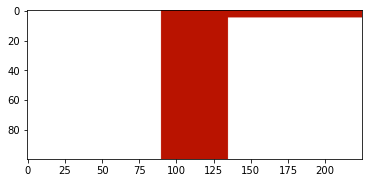

3
Point never used
Point never used
Point never used
Point never used
Point already used
Point already used
Point never used
Point never used
Action is 3, Northwest
Moves remaining, 7
SSD result is 69.33333333333333
Match
Previous action was 3
Point is (360, 135)


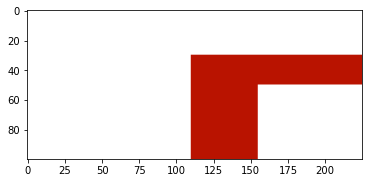

3
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point already used
Point already used
Action Not Possible
Clearing
EPISODE 167
Setting new episode.
Previous action was None
Point is (420, 270)


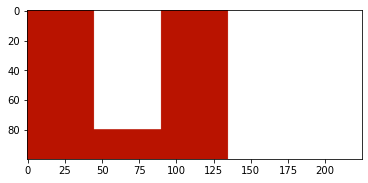

3
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 168
Setting new episode.
Previous action was None
Point is (80, 180)


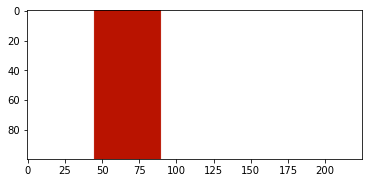

5
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 5, Northeast
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 169
Setting new episode.
Previous action was None
Point is (100, 225)


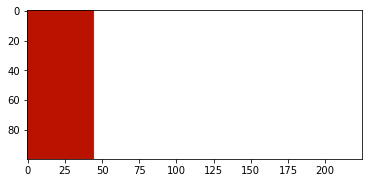

3
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 3, Northwest
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 170
Setting new episode.
Previous action was None
Point is (300, 0)


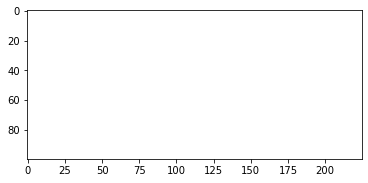

5
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 171
Setting new episode.
Previous action was None
Point is (240, 90)


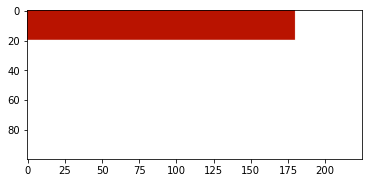

0
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Point never used
Action is 0, South
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 172
Setting new episode.
Previous action was None
Point is (80, 180)


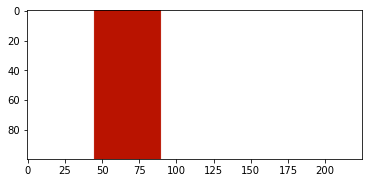

1
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 1, Southwest
Moves remaining, 7
SSD result is 164.0
No match, next epsiode
Clearing
EPISODE 173
Setting new episode.
Previous action was None
Point is (0, 495)


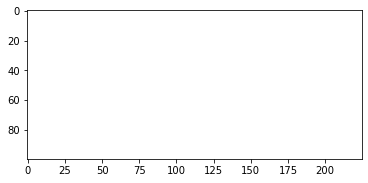

7
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is not on image
Point is not on image
Action Not Possible
Clearing
EPISODE 174
Setting new episode.
Previous action was None
Point is (180, 360)


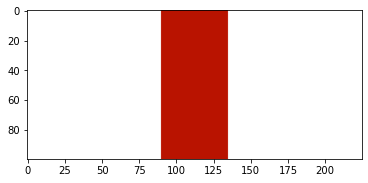

0
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 175
Setting new episode.
Previous action was None
Point is (400, 270)


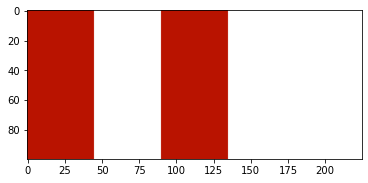

4
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action is 4, North
Moves remaining, 7
SSD result is 120.0
No match, next epsiode
Clearing
EPISODE 176
Setting new episode.
Previous action was None
Point is (60, 450)


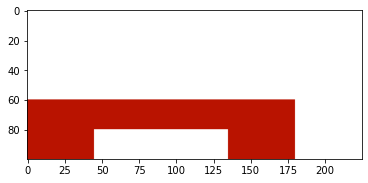

1
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 177
Setting new episode.
Previous action was None
Point is (380, 0)


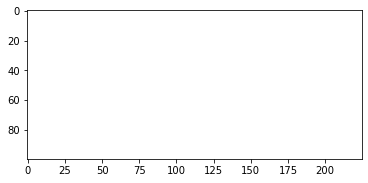

3
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 178
Setting new episode.
Previous action was None
Point is (40, 495)


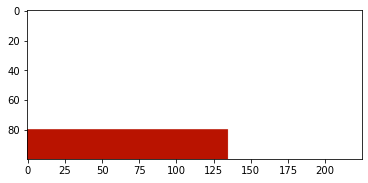

5
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Action Not Possible
Clearing
EPISODE 179
Setting new episode.
Previous action was None
Point is (240, 90)


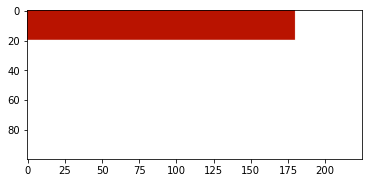

7
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Point never used
Action is 7, Southeast
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 180
Setting new episode.
Previous action was None
Point is (120, 360)


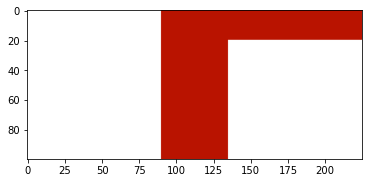

6
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 181
Setting new episode.
Previous action was None
Point is (400, 450)


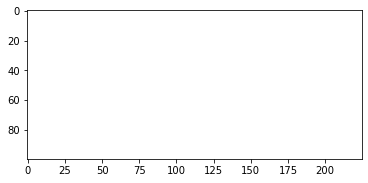

7
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 182
Setting new episode.
Previous action was None
Point is (380, 90)


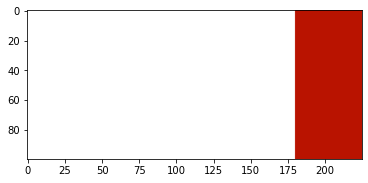

5
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Termination point is outside of the border
Action is 5, Northeast
Moves remaining, 7
SSD result is 0.0
Match
Previous action was 5
Point is (380, 90)


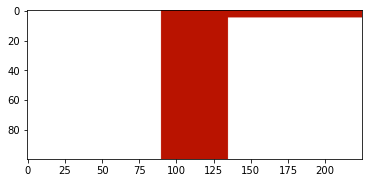

3
Point never used
Early close attempt possible. Remove.
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 3, Northwest
Moves remaining, 7
SSD result is 69.33333333333333
Match
Previous action was 3
Point is (360, 135)


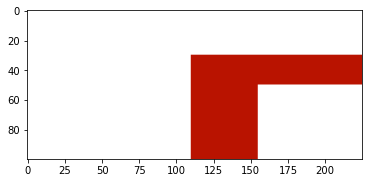

1
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Point already used
Action Not Possible
Clearing
EPISODE 183
Setting new episode.
Previous action was None
Point is (360, 135)


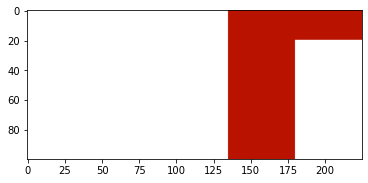

4
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 4, North
Moves remaining, 7
SSD result is 69.33333333333333
Match
Previous action was 4
Point is (360, 135)


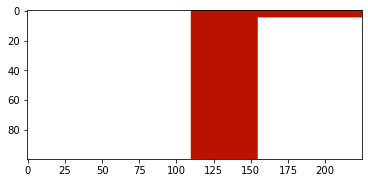

5
Early close attempt possible. Remove.
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 5, Northeast
Moves remaining, 7
SSD result is 53.333333333333336
Match
Previous action was 5
Point is (340, 135)


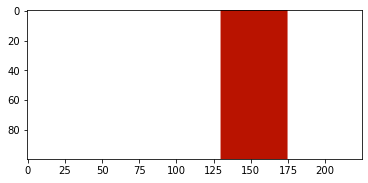

5
Point never used
Point already used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 5, Northeast
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 184
Setting new episode.
Previous action was None
Point is (140, 270)


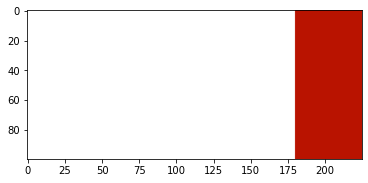

1
Point never used
Point never used
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action is 1, Southwest
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 185
Setting new episode.
Previous action was None
Point is (100, 90)


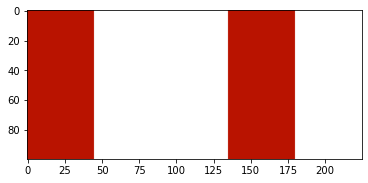

7
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Point never used
Action is 7, Southeast
Moves remaining, 7
SSD result is 94.66666666666667
Match
Previous action was 7
Point is (100, 90)


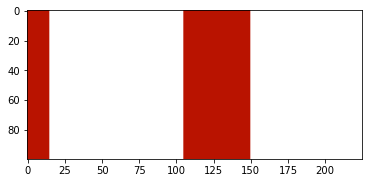

5
Point never used
Point never used
Point never used
Early close attempt possible. Remove.
Point never used
Point never used
Point never used
Point never used
Action is 5, Northeast
Moves remaining, 7
SSD result is 164.0
No match, next epsiode
Clearing
EPISODE 186
Setting new episode.
Previous action was None
Point is (240, 225)


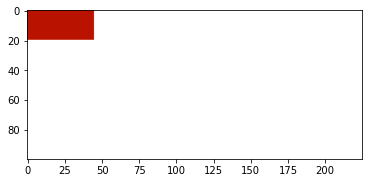

1
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 1, Southwest
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 187
Setting new episode.
Previous action was None
Point is (260, 180)


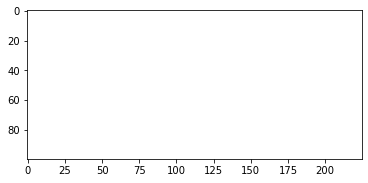

6
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 6, East
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 188
Setting new episode.
Previous action was None
Point is (360, 495)


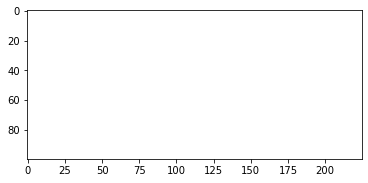

4
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Action Not Possible
Clearing
EPISODE 189
Setting new episode.
Previous action was None
Point is (220, 315)


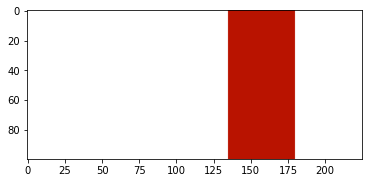

6
Termination point is outside of the border
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 190
Setting new episode.
Previous action was None
Point is (220, 405)


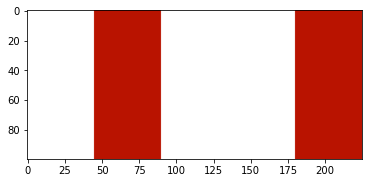

0
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 191
Setting new episode.
Previous action was None
Point is (80, 135)


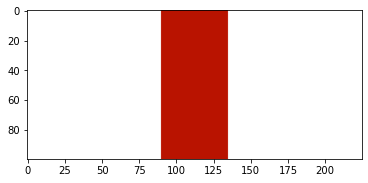

3
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 3, Northwest
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 192
Setting new episode.
Previous action was None
Point is (20, 315)


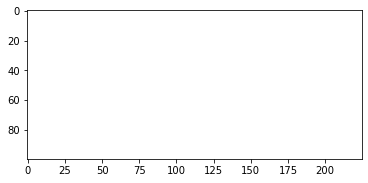

7
Termination point is outside of the border
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 193
Setting new episode.
Previous action was None
Point is (460, 135)


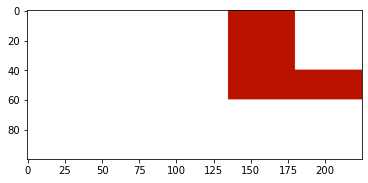

0
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 194
Setting new episode.
Previous action was None
Point is (300, 45)


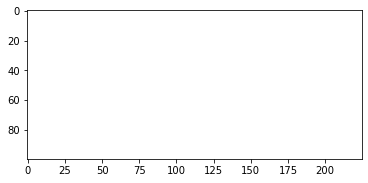

1
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Action Not Possible
Clearing
EPISODE 195
Setting new episode.
Previous action was None
Point is (300, 135)


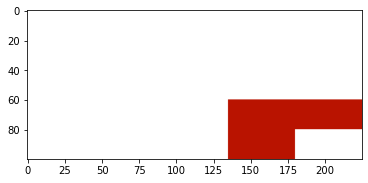

1
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 1, Southwest
Moves remaining, 7
SSD result is 53.333333333333336
Match
Previous action was 1
Point is (300, 135)


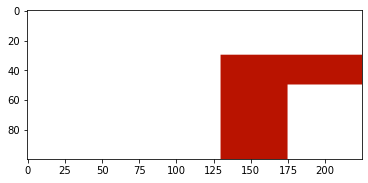

5
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Early close attempt possible. Remove.
Point never used
Point never used
Action Not Possible
Clearing
EPISODE 196
Setting new episode.
Previous action was None
Point is (0, 135)


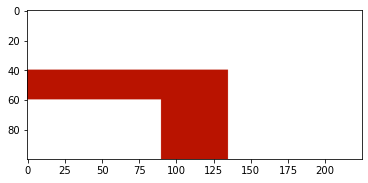

7
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 197
Setting new episode.
Previous action was None
Point is (280, 495)


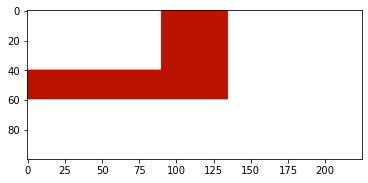

0
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Action Not Possible
Clearing
EPISODE 198
Setting new episode.
Previous action was None
Point is (280, 450)


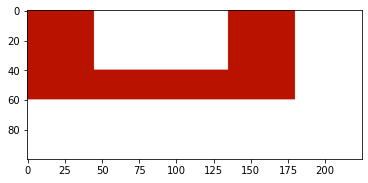

7
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 199
Setting new episode.
Previous action was None
Point is (140, 450)


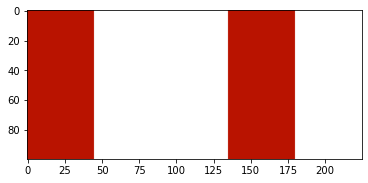

3
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 200
Setting new episode.
Previous action was None
Point is (220, 225)


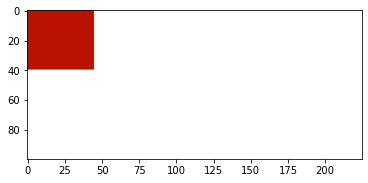

5
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 5, Northeast
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 201
Setting new episode.
Previous action was None
Point is (200, 495)


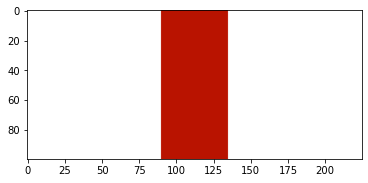

6
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Action Not Possible
Clearing
EPISODE 202
Setting new episode.
Previous action was None
Point is (400, 495)


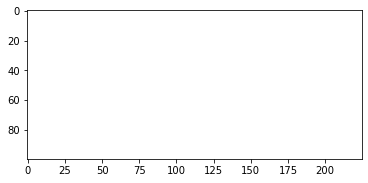

3
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Action Not Possible
Clearing
EPISODE 203
Setting new episode.
Previous action was None
Point is (20, 135)


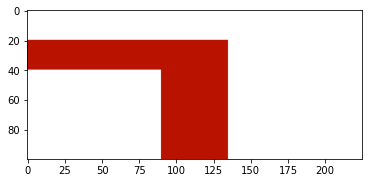

7
Point never used
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Action is 7, Southeast
Moves remaining, 7
SSD result is 53.333333333333336
Match
Previous action was 7
Point is (20, 135)


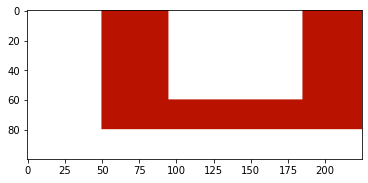

1
Point never used
Point never used
Point never used
Early close attempt possible. Remove.
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Action is 1, Southwest
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 204
Setting new episode.
Previous action was None
Point is (220, 405)


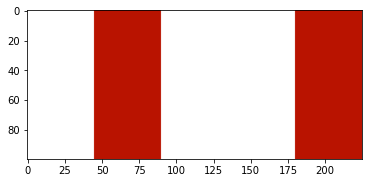

3
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 205
Setting new episode.
Previous action was None
Point is (60, 315)


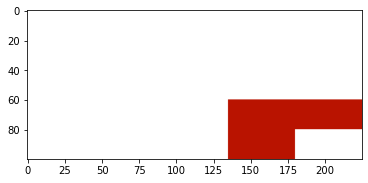

4
Termination point is outside of the border
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 206
Setting new episode.
Previous action was None
Point is (180, 180)


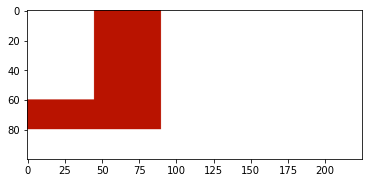

2
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 2, West
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 207
Setting new episode.
Previous action was None
Point is (260, 45)


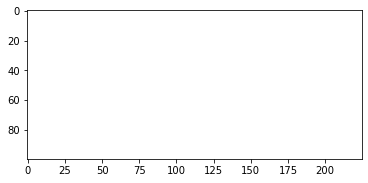

4
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Action Not Possible
Clearing
EPISODE 208
Setting new episode.
Previous action was None
Point is (360, 495)


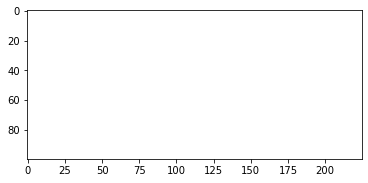

3
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Action Not Possible
Clearing
EPISODE 209
Setting new episode.
Previous action was None
Point is (380, 495)


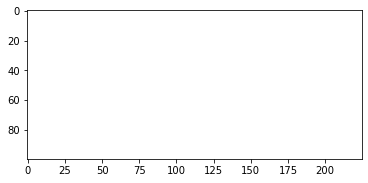

2
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Action Not Possible
Clearing
EPISODE 210
Setting new episode.
Previous action was None
Point is (160, 135)


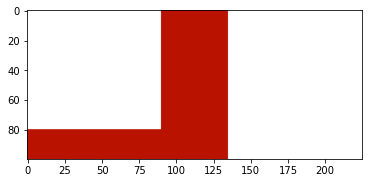

5
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 5, Northeast
Moves remaining, 7
SSD result is 60.0
Match
Previous action was 5
Point is (160, 135)


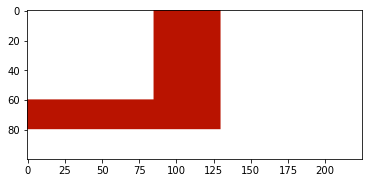

7
Point never used
Early close attempt possible. Remove.
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 7, Southeast
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 211
Setting new episode.
Previous action was None
Point is (80, 360)


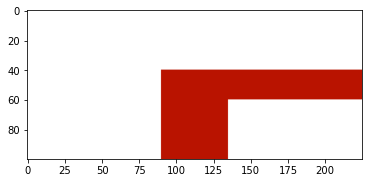

4
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 212
Setting new episode.
Previous action was None
Point is (200, 270)


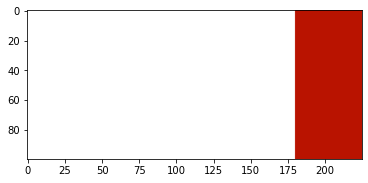

2
Point never used
Point never used
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action is 2, West
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 213
Setting new episode.
Previous action was None
Point is (20, 90)


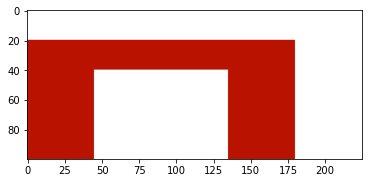

3
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Action Not Possible
Clearing
EPISODE 214
Setting new episode.
Previous action was None
Point is (380, 225)


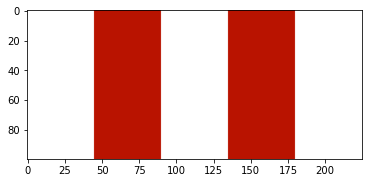

0
Termination point is outside of the border
Termination point is outside of the border
Point never used
Point never used
Point never used
Point never used
Point never used
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 215
Setting new episode.
Previous action was None
Point is (40, 0)


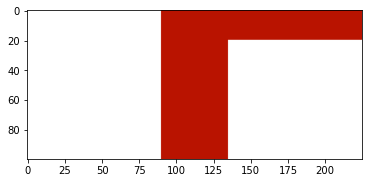

6
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 216
Setting new episode.
Previous action was None
Point is (120, 360)


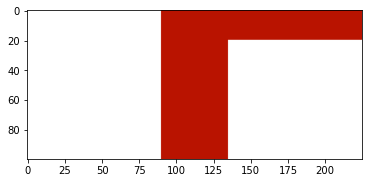

7
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 217
Setting new episode.
Previous action was None
Point is (420, 270)


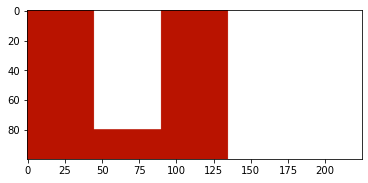

5
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 218
Setting new episode.
Previous action was None
Point is (180, 405)


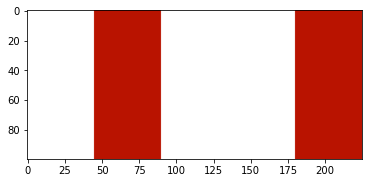

7
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 219
Setting new episode.
Previous action was None
Point is (460, 90)


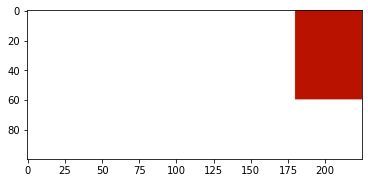

4
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 220
Setting new episode.
Previous action was None
Point is (100, 405)


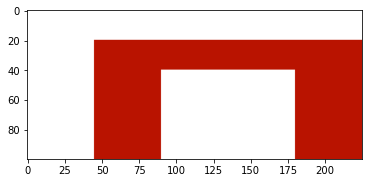

5
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 221
Setting new episode.
Previous action was None
Point is (100, 315)


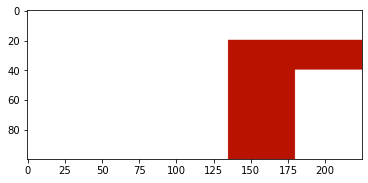

6
Termination point is outside of the border
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 222
Setting new episode.
Previous action was None
Point is (200, 135)


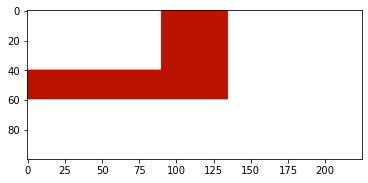

1
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 1, Southwest
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 223
Setting new episode.
Previous action was None
Point is (460, 90)


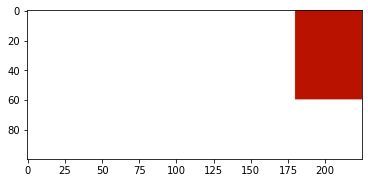

0
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 224
Setting new episode.
Previous action was None
Point is (420, 135)


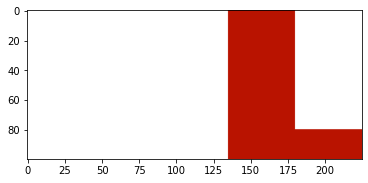

4
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 225
Setting new episode.
Previous action was None
Point is (20, 45)


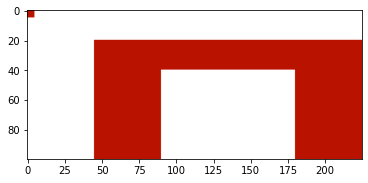

6
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Action Not Possible
Clearing
EPISODE 226
Setting new episode.
Previous action was None
Point is (240, 135)


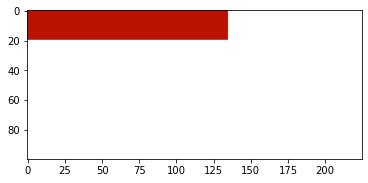

1
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 1, Southwest
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 227
Setting new episode.
Previous action was None
Point is (140, 90)


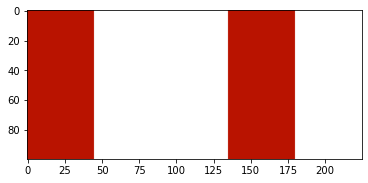

3
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Point never used
Action Not Possible
Clearing
EPISODE 228
Setting new episode.
Previous action was None
Point is (200, 405)


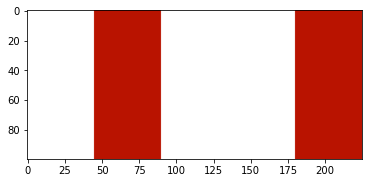

3
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 229
Setting new episode.
Previous action was None
Point is (20, 0)


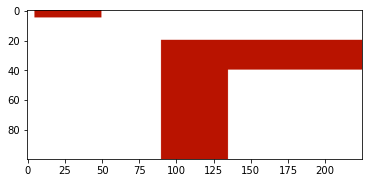

0
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 230
Setting new episode.
Previous action was None
Point is (320, 180)


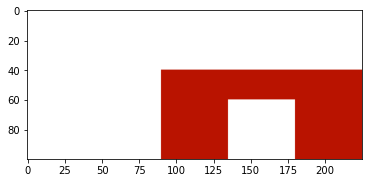

5
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 5, Northeast
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 231
Setting new episode.
Previous action was None
Point is (180, 270)


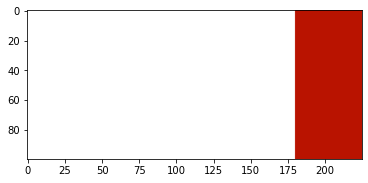

1
Point never used
Point never used
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action is 1, Southwest
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 232
Setting new episode.
Previous action was None
Point is (300, 0)


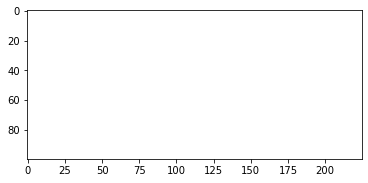

0
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 233
Setting new episode.
Previous action was None
Point is (180, 225)


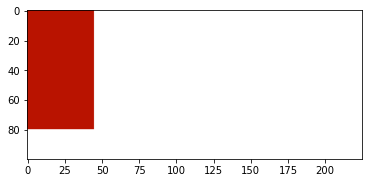

0
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 0, South
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 234
Setting new episode.
Previous action was None
Point is (80, 360)


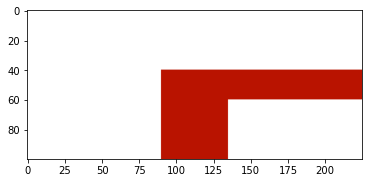

3
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 235
Setting new episode.
Previous action was None
Point is (460, 0)


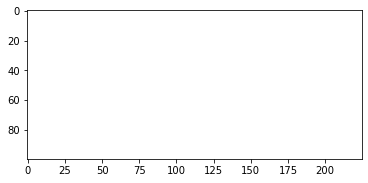

7
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 236
Setting new episode.
Previous action was None
Point is (240, 180)


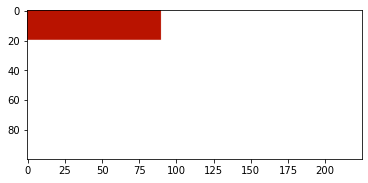

1
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 1, Southwest
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 237
Setting new episode.
Previous action was None
Point is (300, 45)


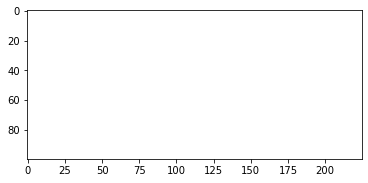

2
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Action Not Possible
Clearing
EPISODE 238
Setting new episode.
Previous action was None
Point is (180, 45)


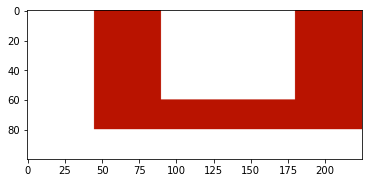

7
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Action is 7, Southeast
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 239
Setting new episode.
Previous action was None
Point is (260, 45)


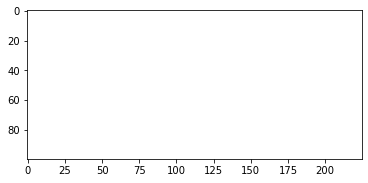

0
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Action Not Possible
Clearing
EPISODE 240
Setting new episode.
Previous action was None
Point is (400, 90)


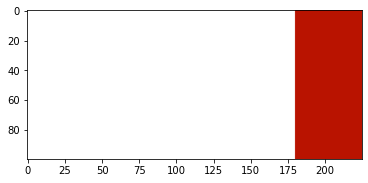

3
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 241
Setting new episode.
Previous action was None
Point is (100, 270)


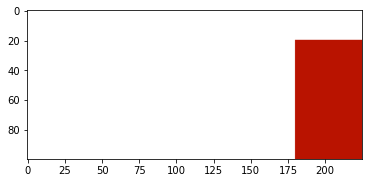

5
Point never used
Point never used
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 242
Setting new episode.
Previous action was None
Point is (380, 90)


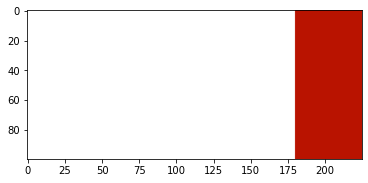

5
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Termination point is outside of the border
Action is 5, Northeast
Moves remaining, 7
SSD result is 0.0
Match
Previous action was 5
Point is (380, 90)


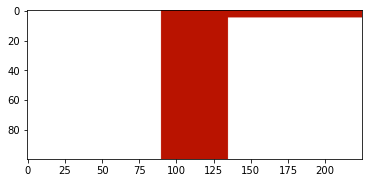

1
Point never used
Early close attempt possible. Remove.
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action Not Possible
Clearing
EPISODE 243
Setting new episode.
Previous action was None
Point is (240, 360)


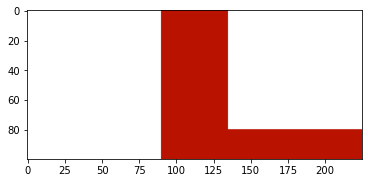

5
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 244
Setting new episode.
Previous action was None
Point is (380, 45)


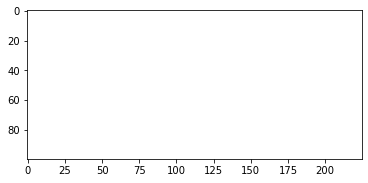

6
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Termination point is outside of the border
Action is 6, East
Moves remaining, 7
SSD result is 120.0
No match, next epsiode
Clearing
EPISODE 245
Setting new episode.
Previous action was None
Point is (120, 180)


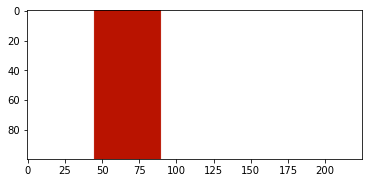

4
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 4, North
Moves remaining, 7
SSD result is 164.0
No match, next epsiode
Clearing
EPISODE 246
Setting new episode.
Previous action was None
Point is (400, 45)


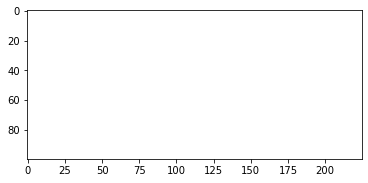

5
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Termination point is outside of the border
Termination point is outside of the border
Action is 5, Northeast
Moves remaining, 7
SSD result is 120.0
No match, next epsiode
Clearing
EPISODE 247
Setting new episode.
Previous action was None
Point is (120, 135)


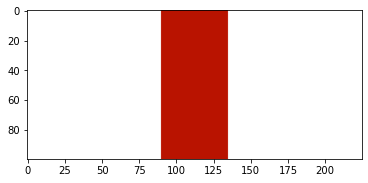

3
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 3, Northwest
Moves remaining, 7
SSD result is 164.0
No match, next epsiode
Clearing
EPISODE 248
Setting new episode.
Previous action was None
Point is (100, 270)


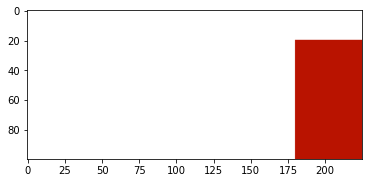

4
Point never used
Point never used
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action is 4, North
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 249
Setting new episode.
Previous action was None
Point is (440, 90)


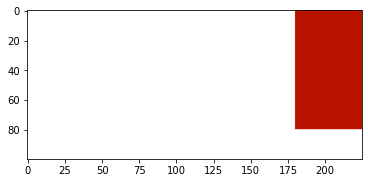

2
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 250
Setting new episode.
Previous action was None
Point is (220, 315)


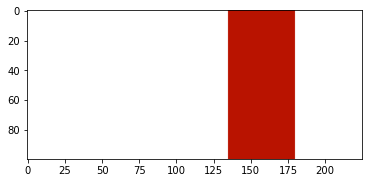

3
Termination point is outside of the border
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action is 3, Northwest
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 251
Setting new episode.
Previous action was None
Point is (0, 180)


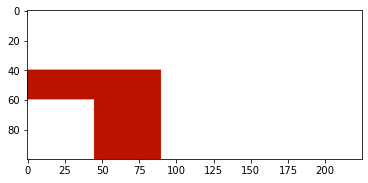

3
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 252
Setting new episode.
Previous action was None
Point is (40, 90)


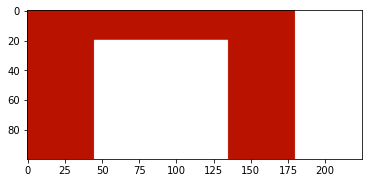

7
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Action is 7, Southeast
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 253
Setting new episode.
Previous action was None
Point is (320, 495)


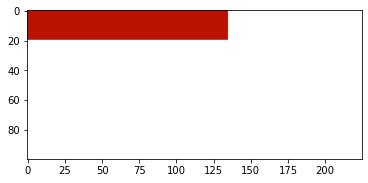

4
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Action Not Possible
Clearing
EPISODE 254
Setting new episode.
Previous action was None
Point is (200, 0)


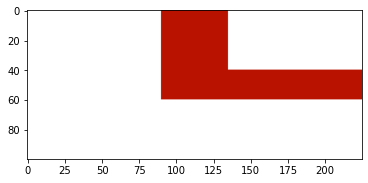

5
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 255
Setting new episode.
Previous action was None
Point is (60, 135)


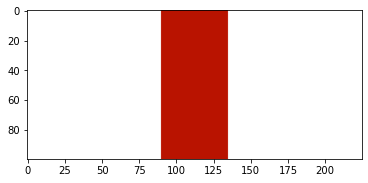

2
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 2, West
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 256
Setting new episode.
Previous action was None
Point is (180, 90)


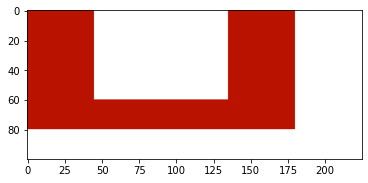

5
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Point never used
Action is 5, Northeast
Moves remaining, 7
SSD result is 129.33333333333334
No match, next epsiode
Clearing
EPISODE 257
Setting new episode.
Previous action was None
Point is (460, 360)


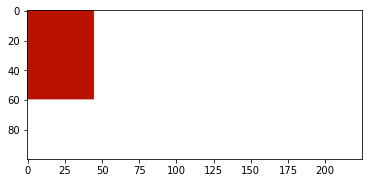

6
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 258
Setting new episode.
Previous action was None
Point is (380, 495)


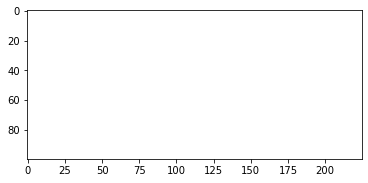

6
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Action Not Possible
Clearing
EPISODE 259
Setting new episode.
Previous action was None
Point is (80, 315)


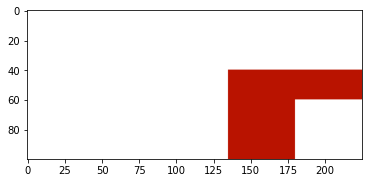

5
Termination point is outside of the border
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 260
Setting new episode.
Previous action was None
Point is (460, 405)


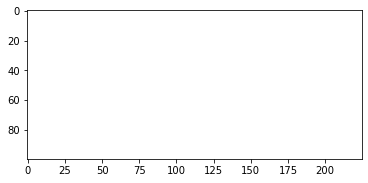

7
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 261
Setting new episode.
Previous action was None
Point is (80, 90)


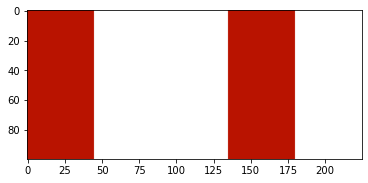

4
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Point never used
Action is 4, North
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 262
Setting new episode.
Previous action was None
Point is (220, 450)


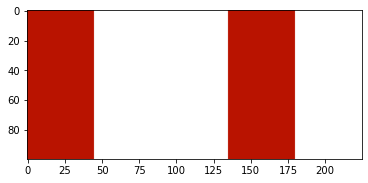

5
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 263
Setting new episode.
Previous action was None
Point is (220, 45)


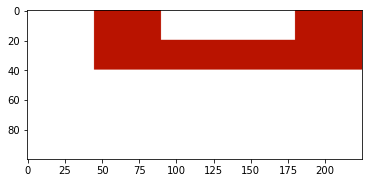

4
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Action Not Possible
Clearing
EPISODE 264
Setting new episode.
Previous action was None
Point is (20, 405)


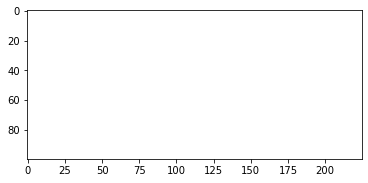

0
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 265
Setting new episode.
Previous action was None
Point is (100, 360)


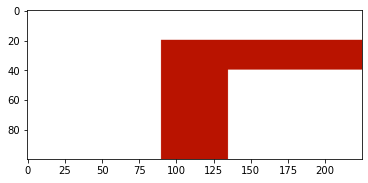

3
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 266
Setting new episode.
Previous action was None
Point is (100, 495)


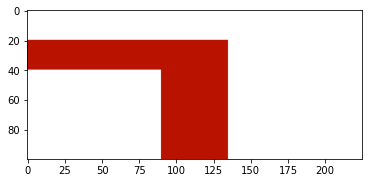

3
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Action Not Possible
Clearing
EPISODE 267
Setting new episode.
Previous action was None
Point is (300, 270)


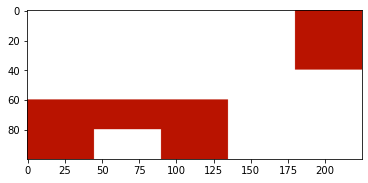

5
Point never used
Point never used
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 268
Setting new episode.
Previous action was None
Point is (80, 180)


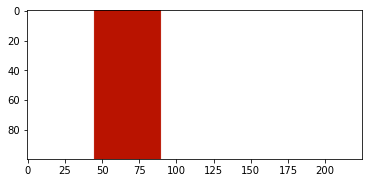

4
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 4, North
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 269
Setting new episode.
Previous action was None
Point is (220, 270)


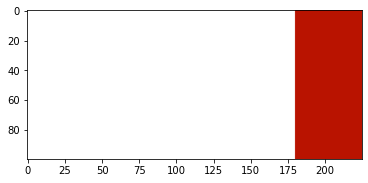

7
Point never used
Point never used
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 270
Setting new episode.
Previous action was None
Point is (0, 270)


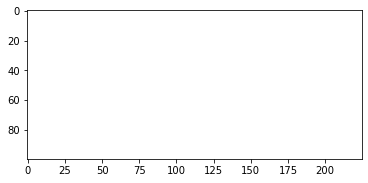

5
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 271
Setting new episode.
Previous action was None
Point is (20, 360)


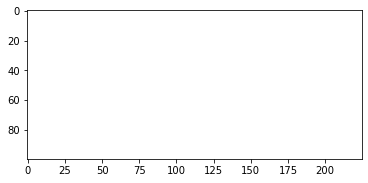

7
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 272
Setting new episode.
Previous action was None
Point is (420, 0)


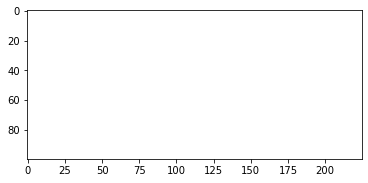

5
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 273
Setting new episode.
Previous action was None
Point is (240, 0)


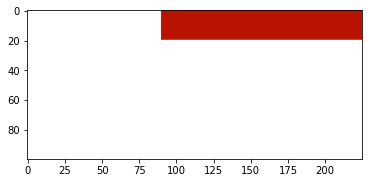

5
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 274
Setting new episode.
Previous action was None
Point is (380, 90)


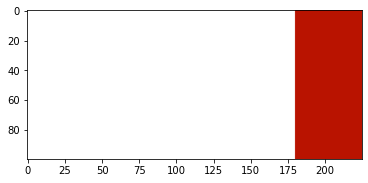

4
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Termination point is outside of the border
Action is 4, North
Moves remaining, 7
SSD result is 0.0
Match
Previous action was 4
Point is (380, 90)


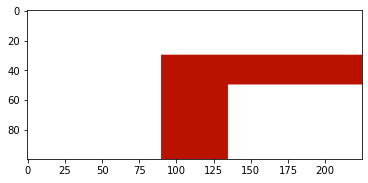

0
Early close attempt possible. Remove.
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Point never used
Action Not Possible
Clearing
EPISODE 275
Setting new episode.
Previous action was None
Point is (360, 0)


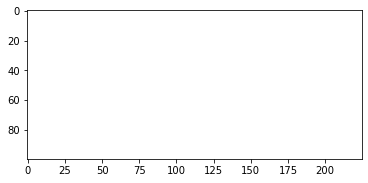

3
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 276
Setting new episode.
Previous action was None
Point is (100, 450)


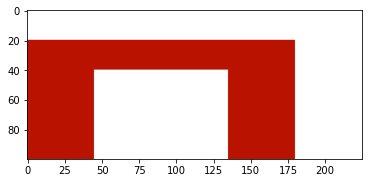

5
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 277
Setting new episode.
Previous action was None
Point is (400, 360)


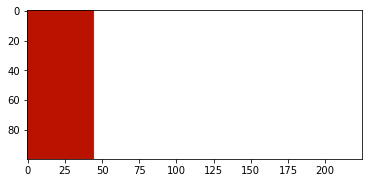

5
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 278
Setting new episode.
Previous action was None
Point is (0, 360)


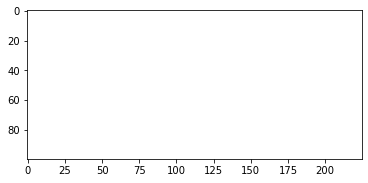

5
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 279
Setting new episode.
Previous action was None
Point is (360, 405)


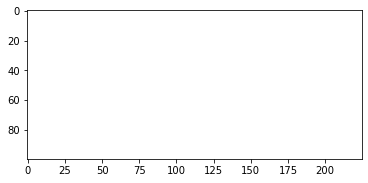

3
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 280
Setting new episode.
Previous action was None
Point is (280, 225)


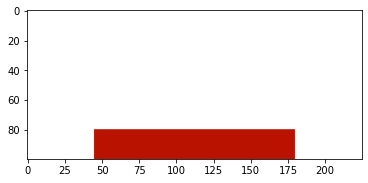

3
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 3, Northwest
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 281
Setting new episode.
Previous action was None
Point is (380, 360)


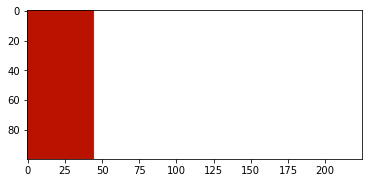

4
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 282
Setting new episode.
Previous action was None
Point is (300, 135)


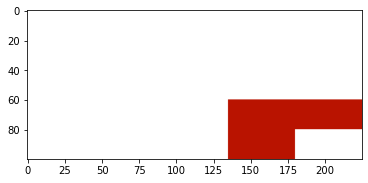

2
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 2, West
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 283
Setting new episode.
Previous action was None
Point is (420, 270)


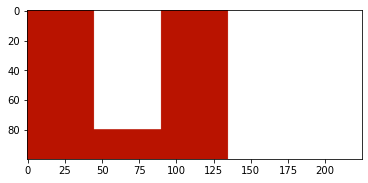

0
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 284
Setting new episode.
Previous action was None
Point is (20, 405)


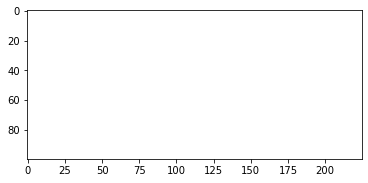

5
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 285
Setting new episode.
Previous action was None
Point is (360, 135)


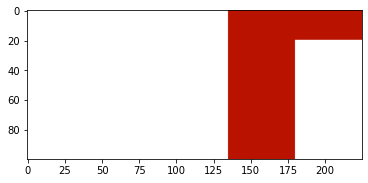

3
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 3, Northwest
Moves remaining, 7
SSD result is 69.33333333333333
Match
Previous action was 3
Point is (360, 135)


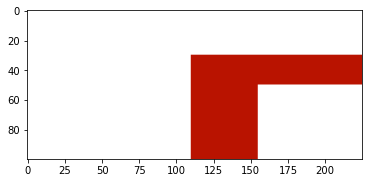

5
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Early close attempt possible. Remove.
Action is 5, Northeast
Moves remaining, 7
SSD result is 53.333333333333336
Match
Previous action was 5
Point is (340, 90)


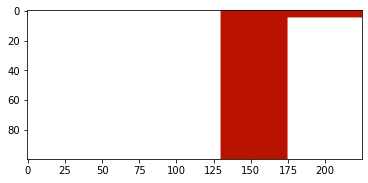

6
Point never used
Point already used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 6, East
Moves remaining, 7
SSD result is 53.333333333333336
Match
Previous action was 6
Point is (320, 135)


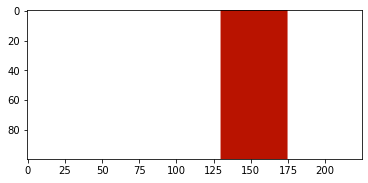

1
Point never used
Point never used
Point already used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 1, Southwest
Moves remaining, 7
SSD result is 69.33333333333333
Match
Previous action was 1
Point is (320, 180)


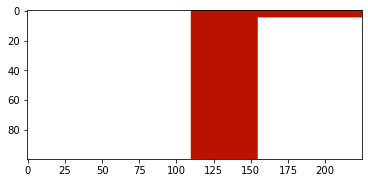

0
Point never used
Point already used
Point never used
Point already used
Point already used
Point never used
Point never used
Action is 0, South
Moves remaining, 7
SSD result is 0.0
Match
Episode origin point visited. Loop created. Next Episode
Clearing
EPISODE 286
Setting new episode.
Previous action was None
Point is (400, 315)


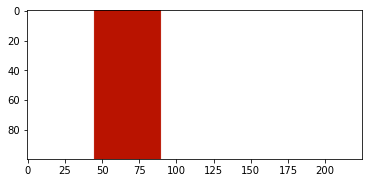

0
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 287
Setting new episode.
Previous action was None
Point is (60, 270)


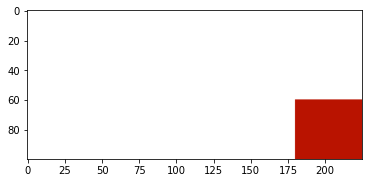

2
Point never used
Point never used
Point never used
Point never used
Point never used
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action is 2, West
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 288
Setting new episode.
Previous action was None
Point is (320, 450)


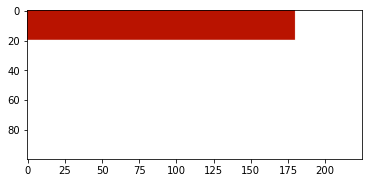

3
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 289
Setting new episode.
Previous action was None
Point is (380, 225)


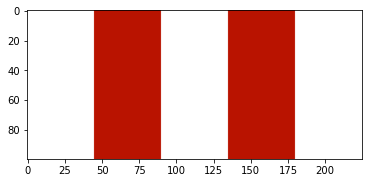

0
Termination point is outside of the border
Termination point is outside of the border
Point never used
Point never used
Point never used
Point never used
Point never used
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 290
Setting new episode.
Previous action was None
Point is (440, 450)


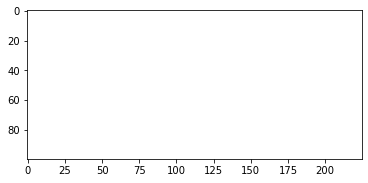

1
Point is within buffer edge of border
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 291
Setting new episode.
Previous action was None
Point is (40, 270)


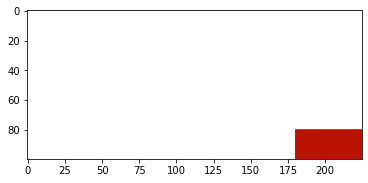

2
Point never used
Point never used
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Action is 2, West
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 292
Setting new episode.
Previous action was None
Point is (120, 90)


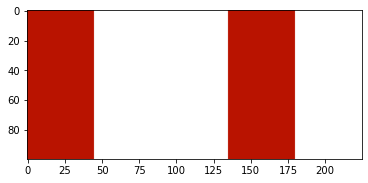

0
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Point never used
Action is 0, South
Moves remaining, 7
SSD result is 60.0
Match
Previous action was 0
Point is (120, 90)


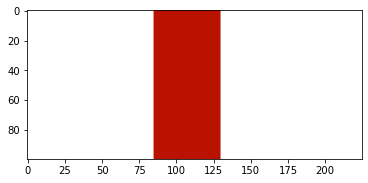

4
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Early close attempt possible. Remove.
Point never used
Point never used
Point never used
Action Not Possible
Clearing
EPISODE 293
Setting new episode.
Previous action was None
Point is (300, 180)


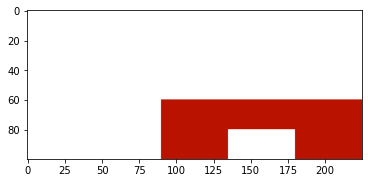

5
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Point never used
Action is 5, Northeast
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 294
Setting new episode.
Previous action was None
Point is (320, 450)


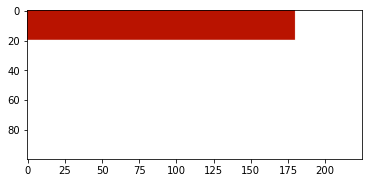

2
Point is within buffer edge of border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 295
Setting new episode.
Previous action was None
Point is (20, 180)


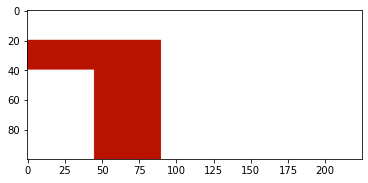

7
Point never used
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Action is 7, Southeast
Moves remaining, 7
SSD result is 113.33333333333333
No match, next epsiode
Clearing
EPISODE 296
Setting new episode.
Previous action was None
Point is (60, 0)


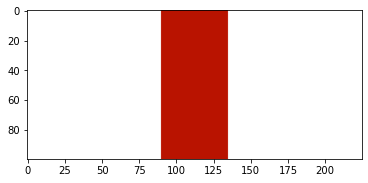

7
Point is within buffer edge of border
Point is not on image
Point is not on image
Point is not on image
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 297
Setting new episode.
Previous action was None
Point is (160, 360)


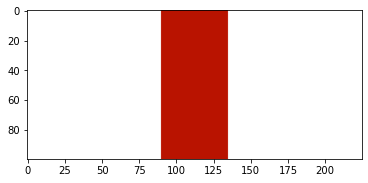

4
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Action Not Possible
Clearing
EPISODE 298
Setting new episode.
Previous action was None
Point is (300, 405)


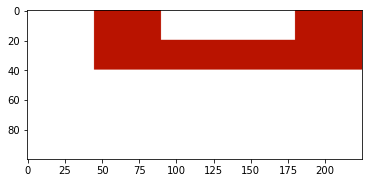

3
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Termination point is outside of the border
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Action Not Possible
Clearing
EPISODE 299
Setting new episode.
Previous action was None
Point is (300, 90)


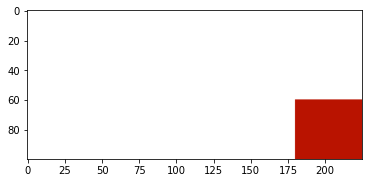

3
Point never used
Point is within buffer edge of border
Point is within buffer edge of border
Point is within buffer edge of border
Point never used
Point never used
Point never used
Point never used
Action Not Possible
Clearing


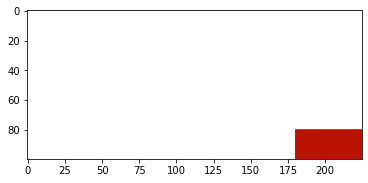

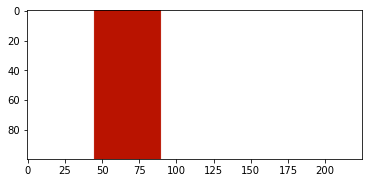

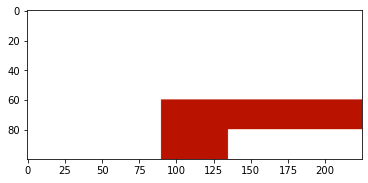

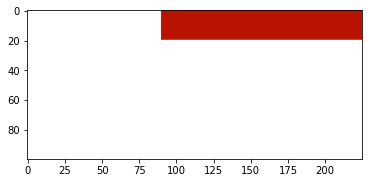

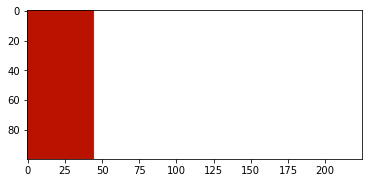

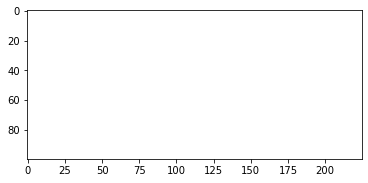

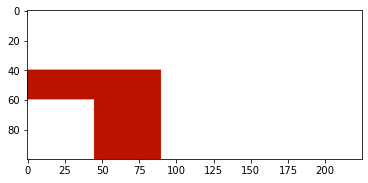

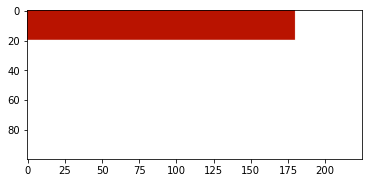

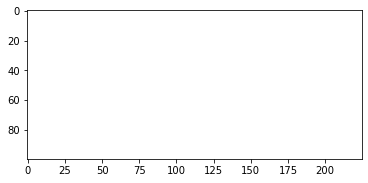

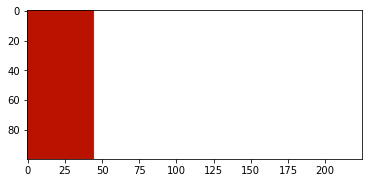

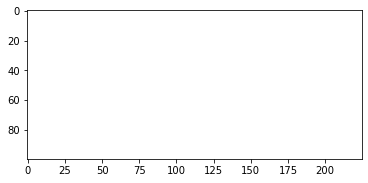

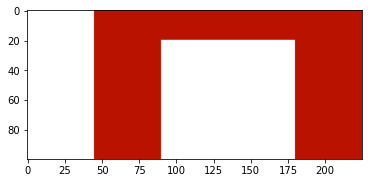

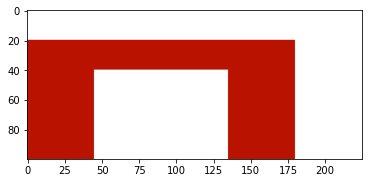

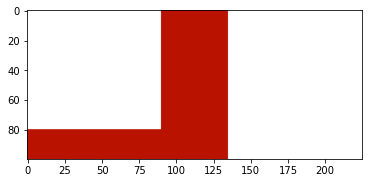

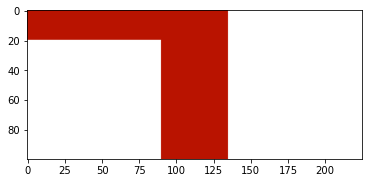

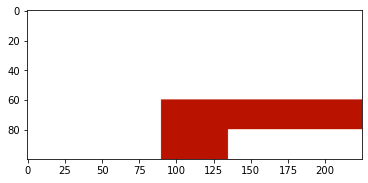

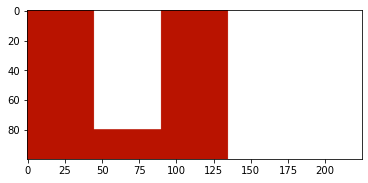

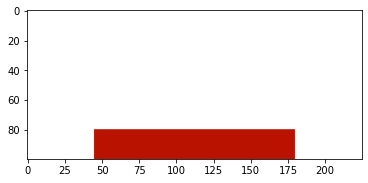

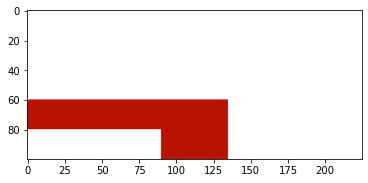

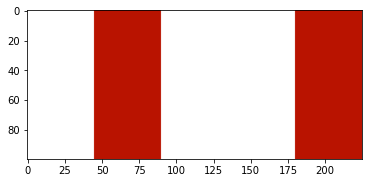

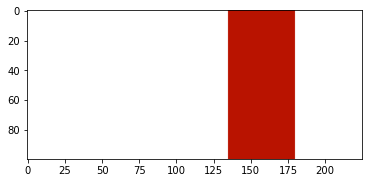

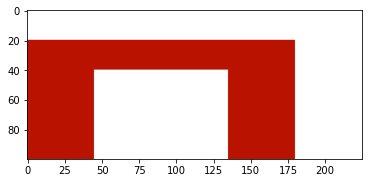

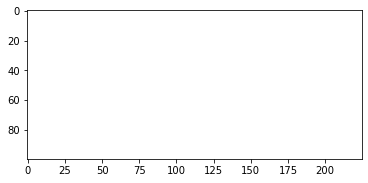

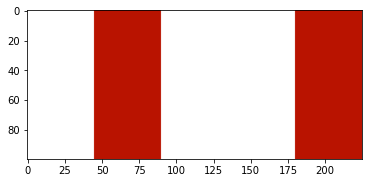

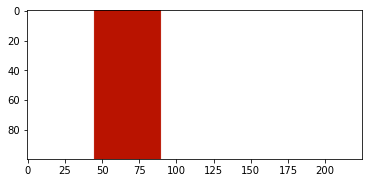

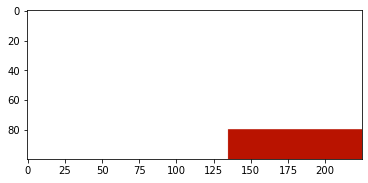

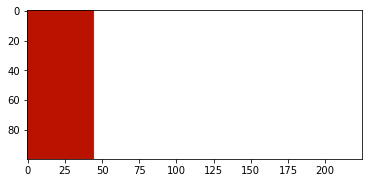

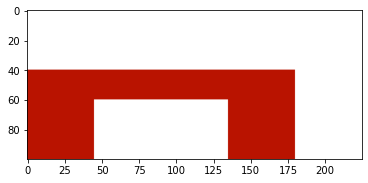

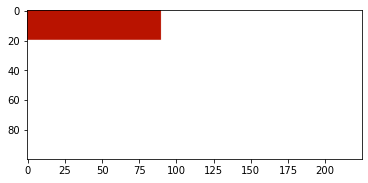

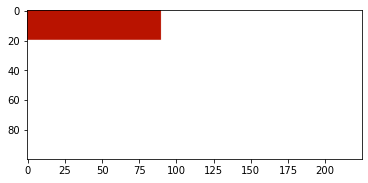

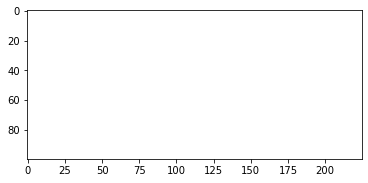

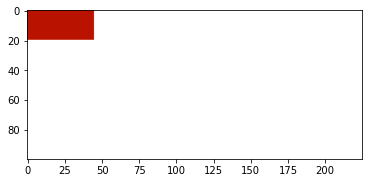

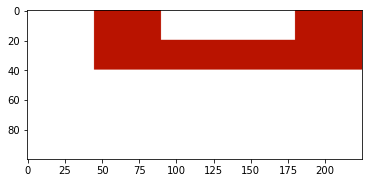

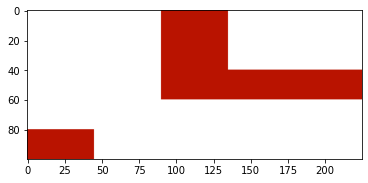

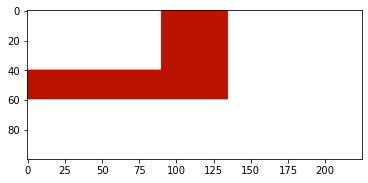

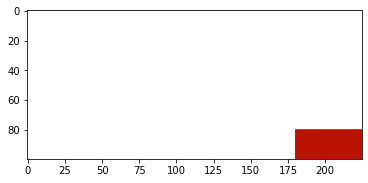

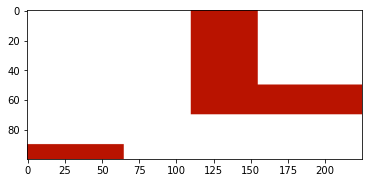

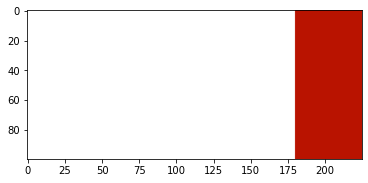

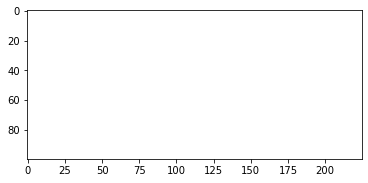

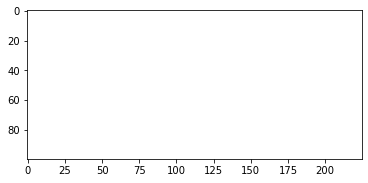

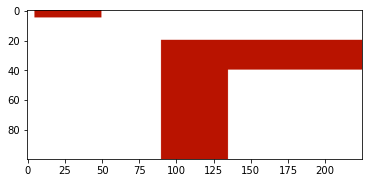

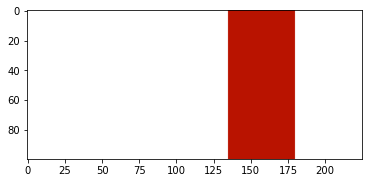

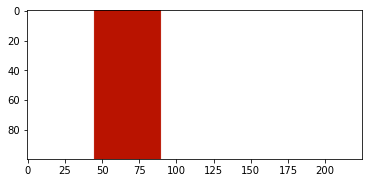

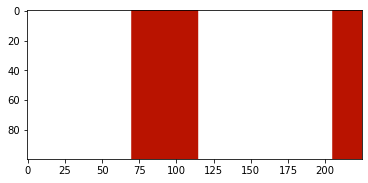

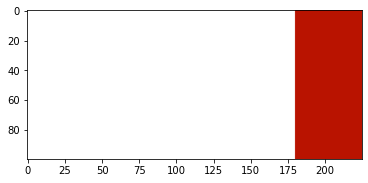

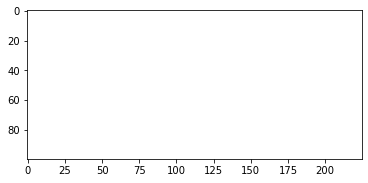

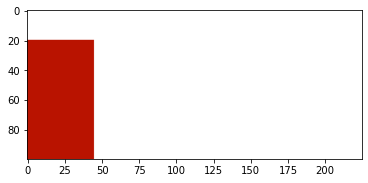

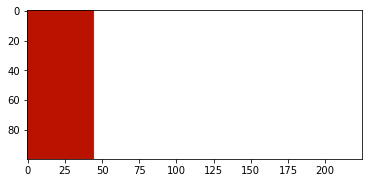

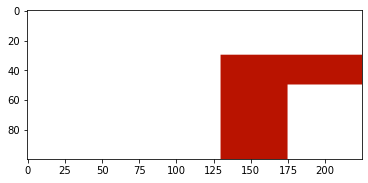

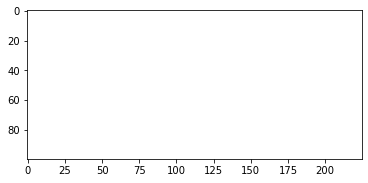

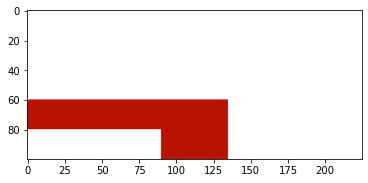

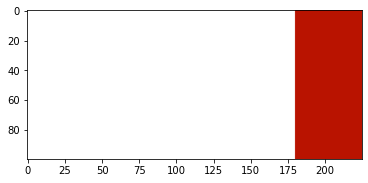

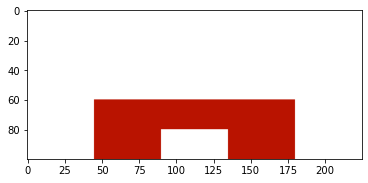

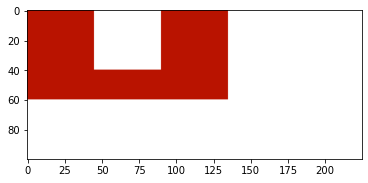

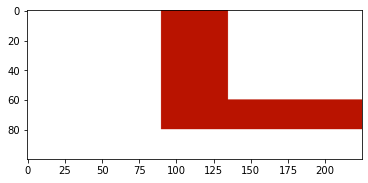

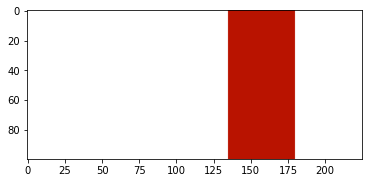

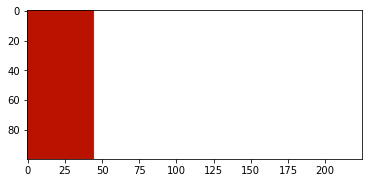

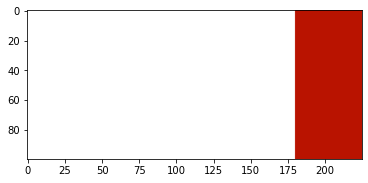

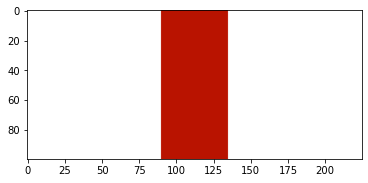

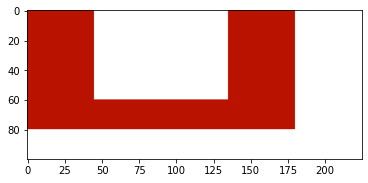

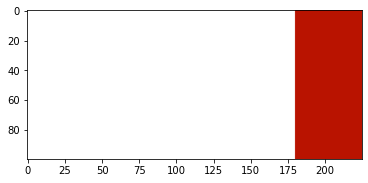

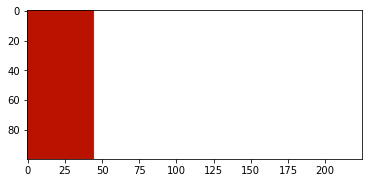

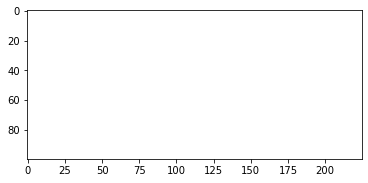

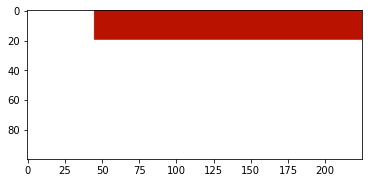

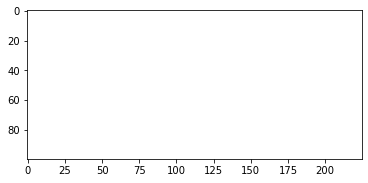

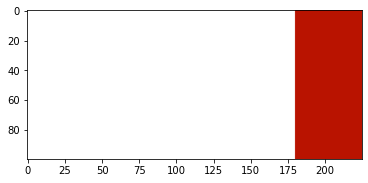

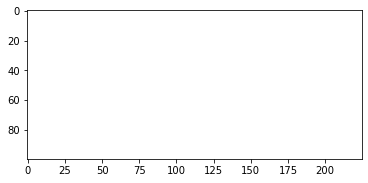

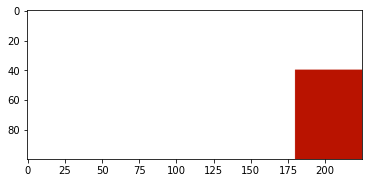

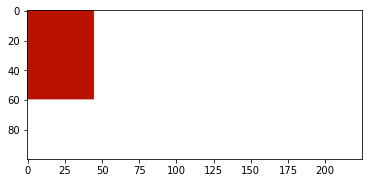

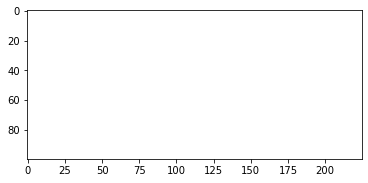

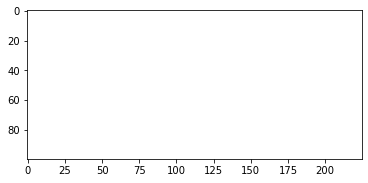

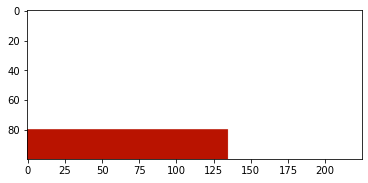

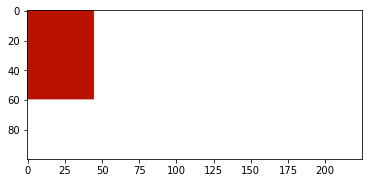

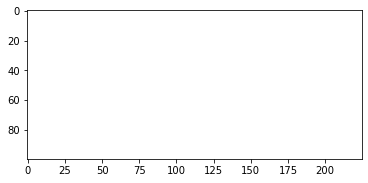

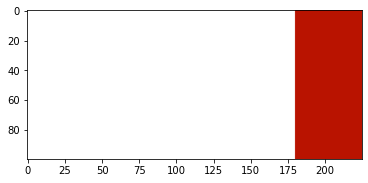

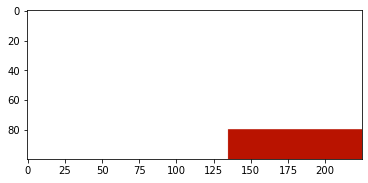

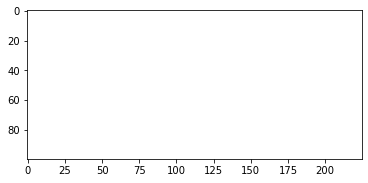

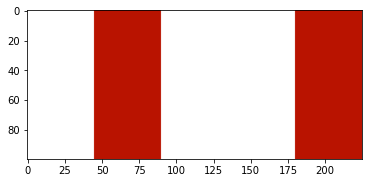

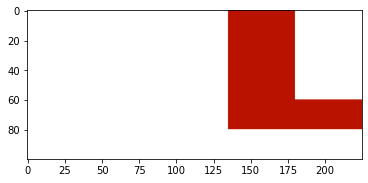

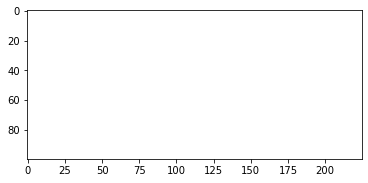

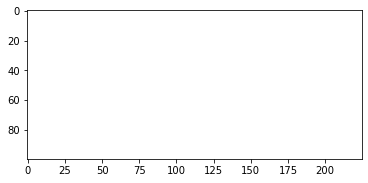

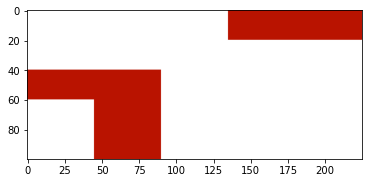

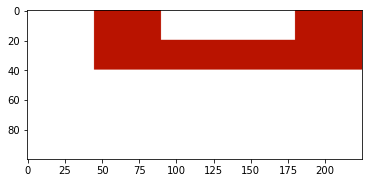

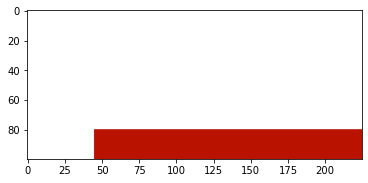

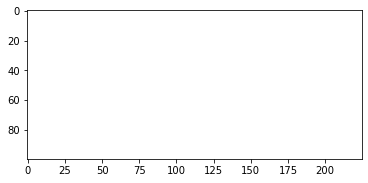

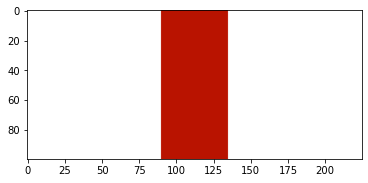

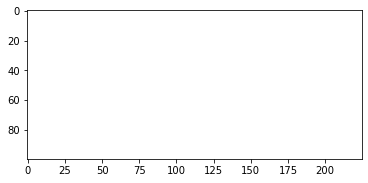

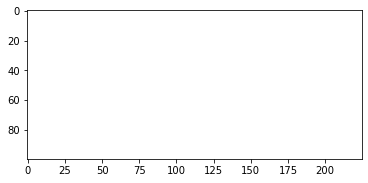

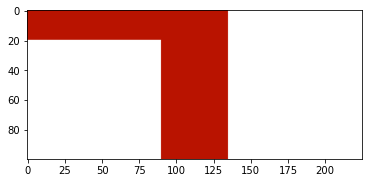

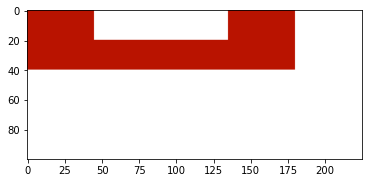

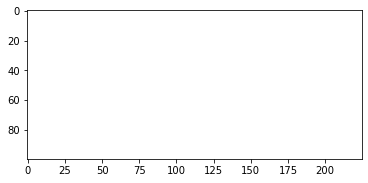

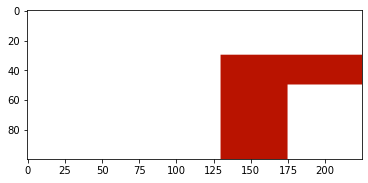

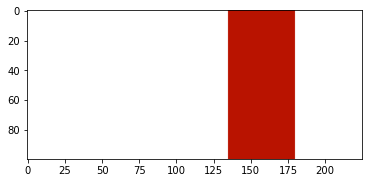

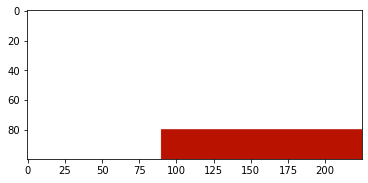

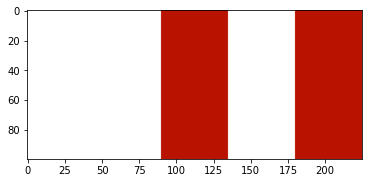

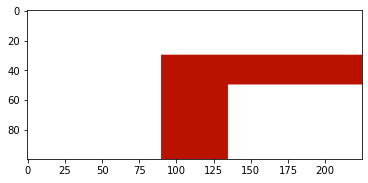

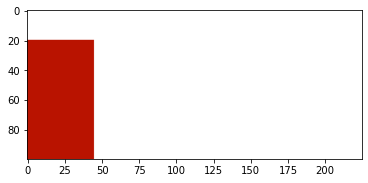

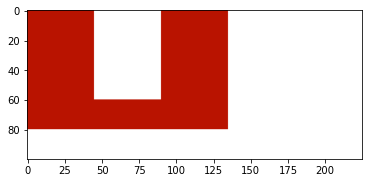

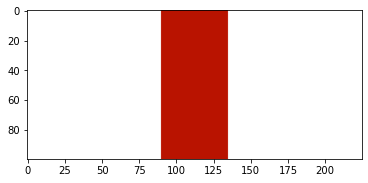

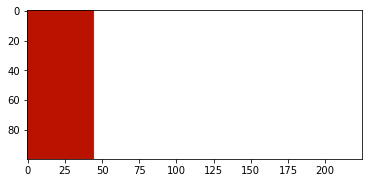

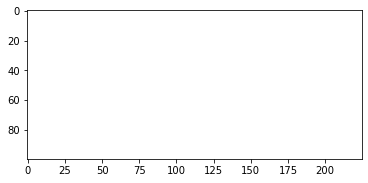

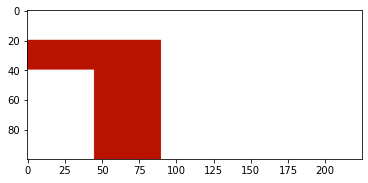

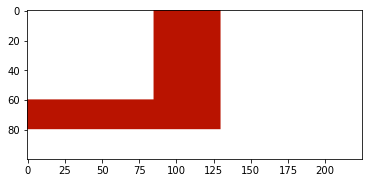

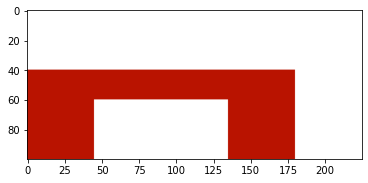

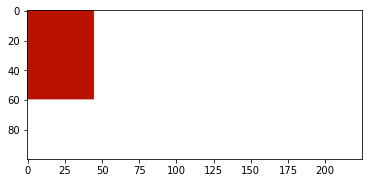

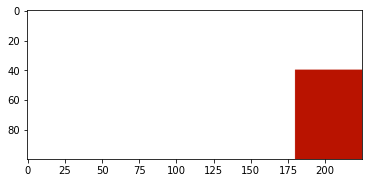

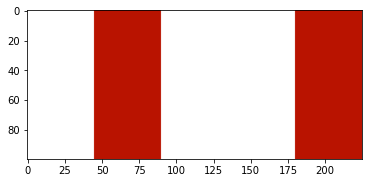

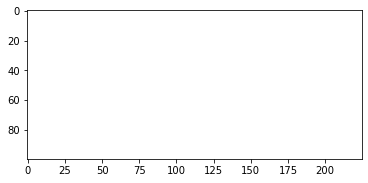

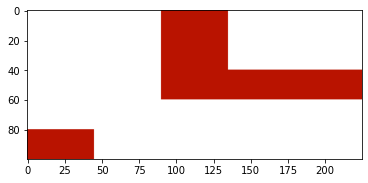

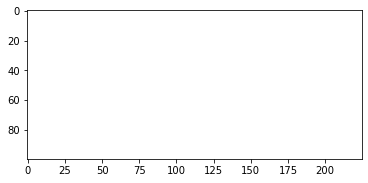

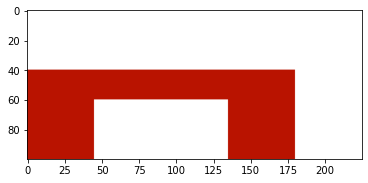

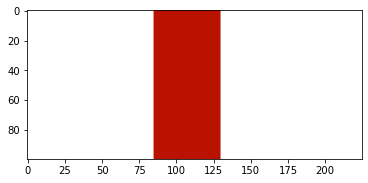

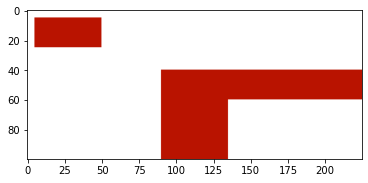

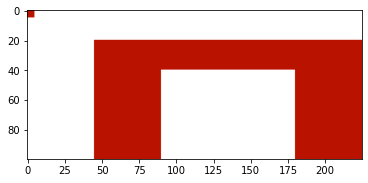

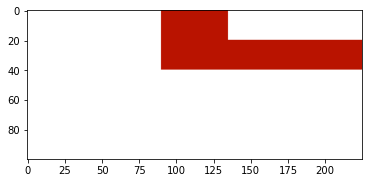

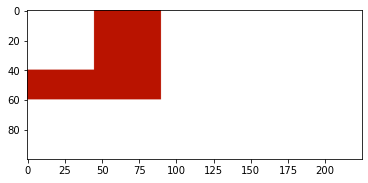

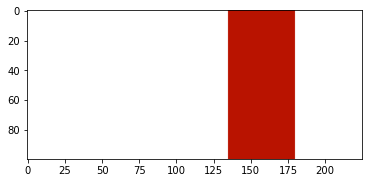

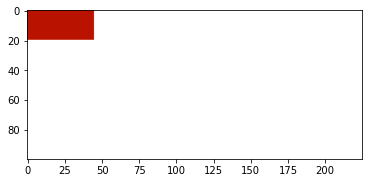

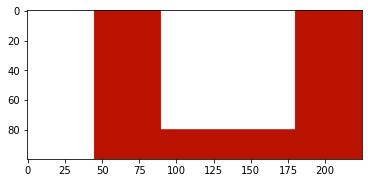

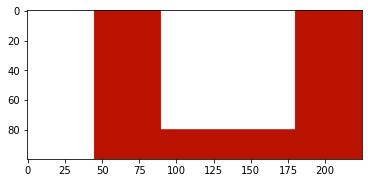

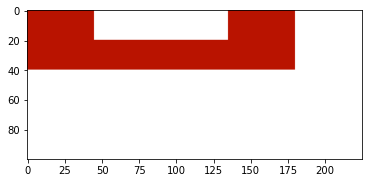

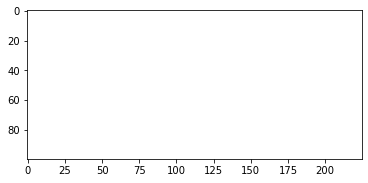

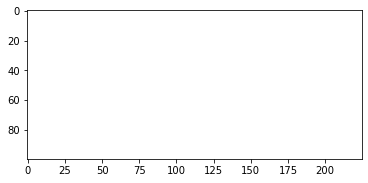

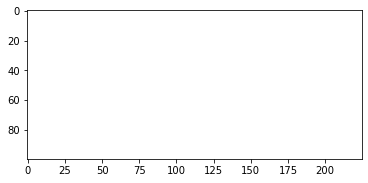

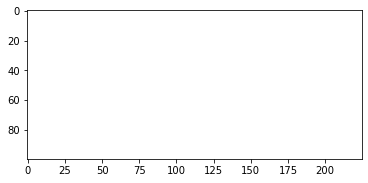

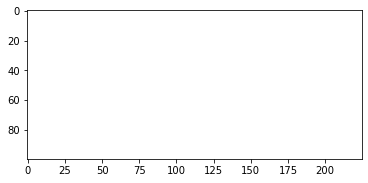

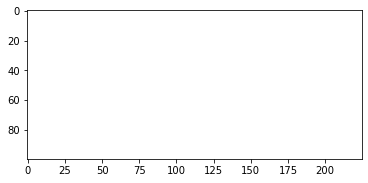

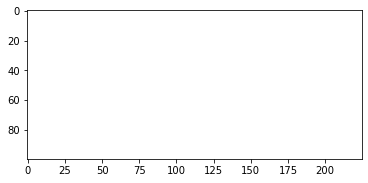

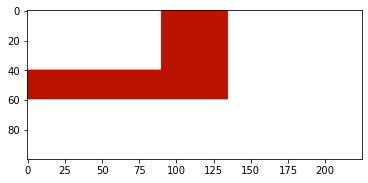

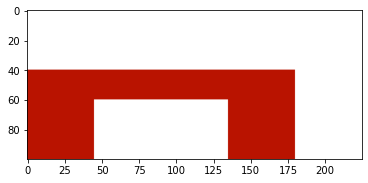

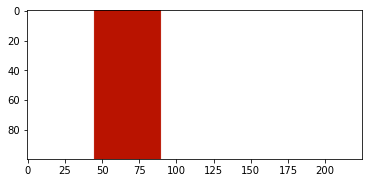

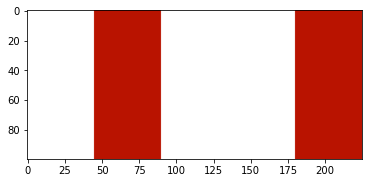

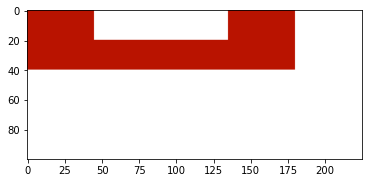

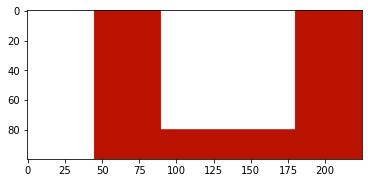

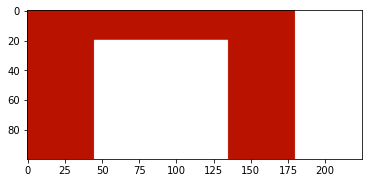

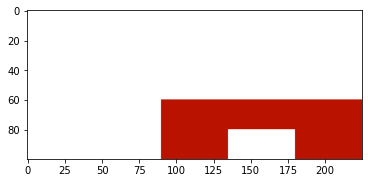

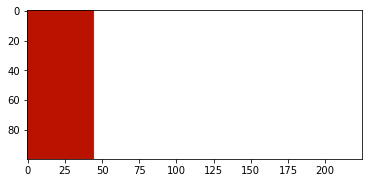

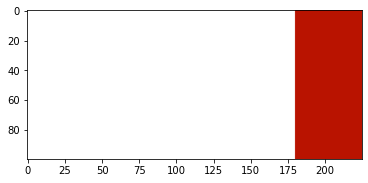

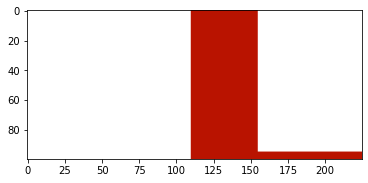

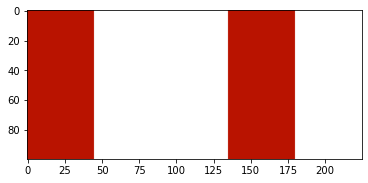

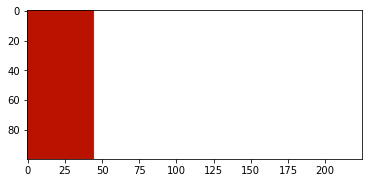

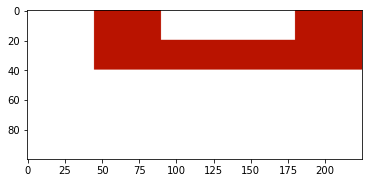

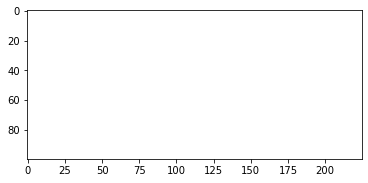

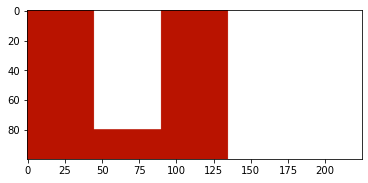

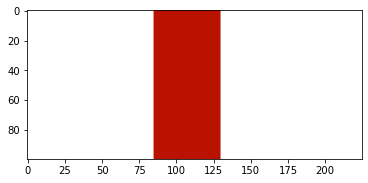

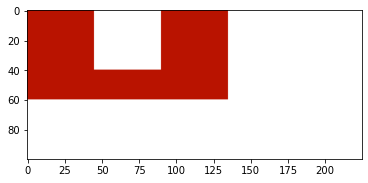

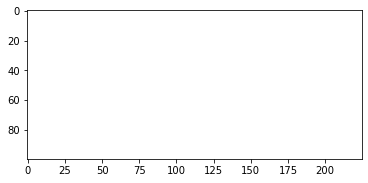

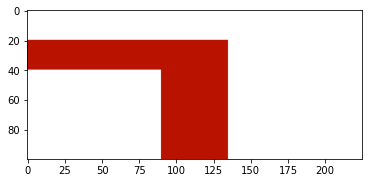

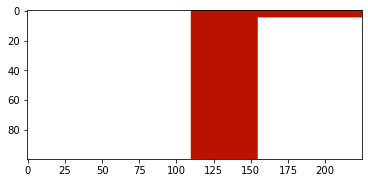

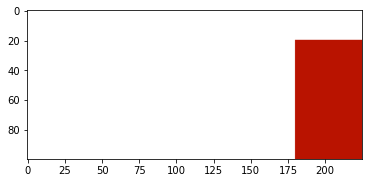

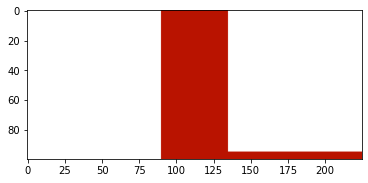

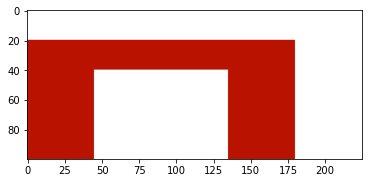

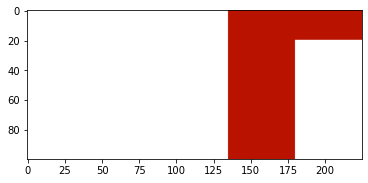

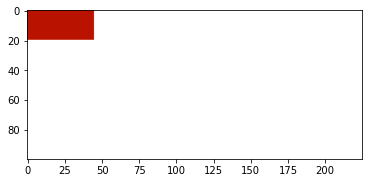

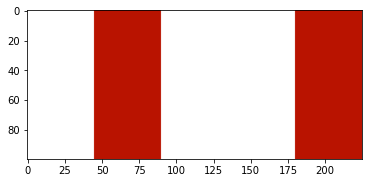

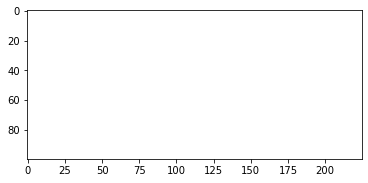

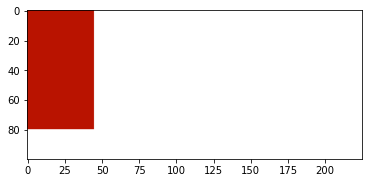

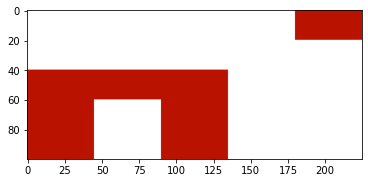

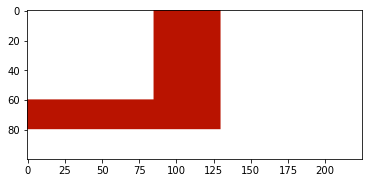

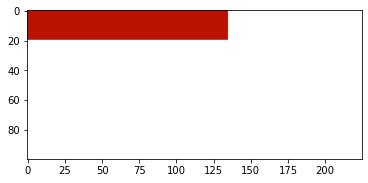

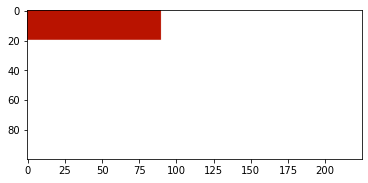

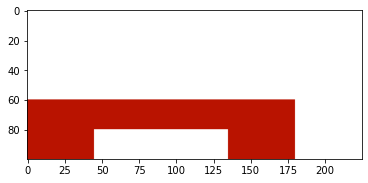

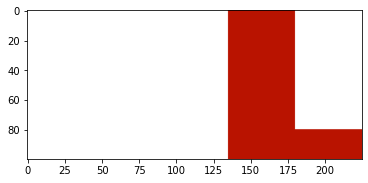

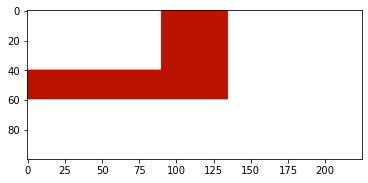

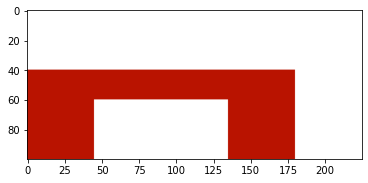

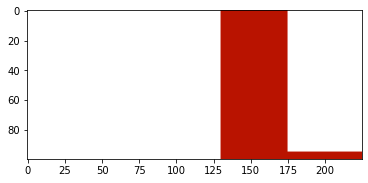

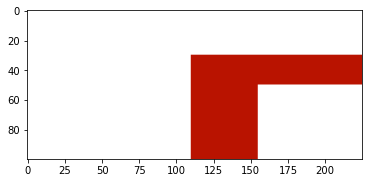

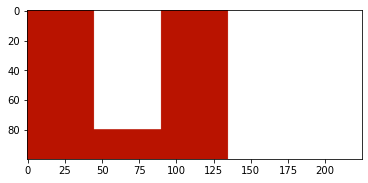

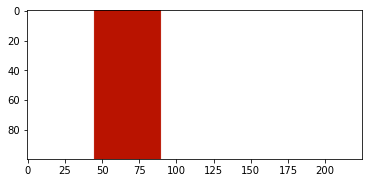

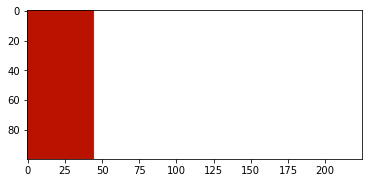

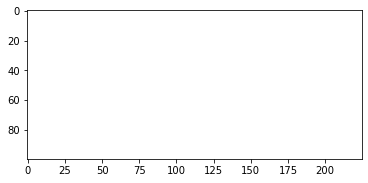

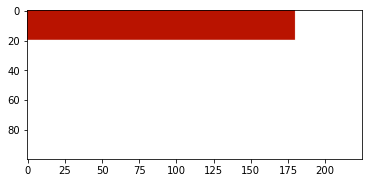

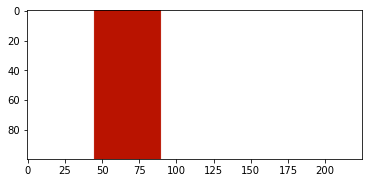

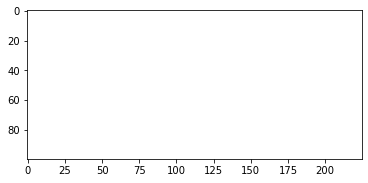

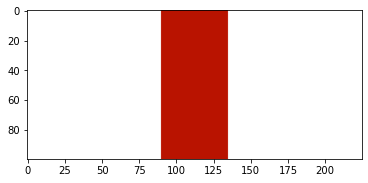

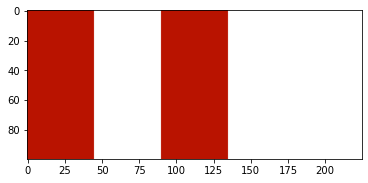

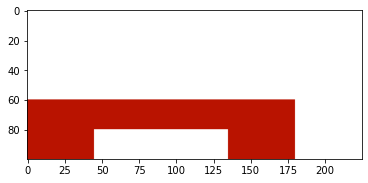

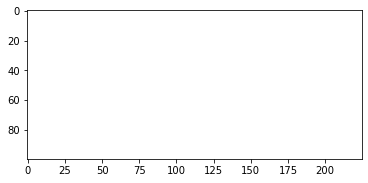

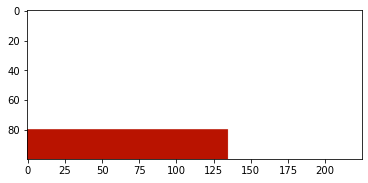

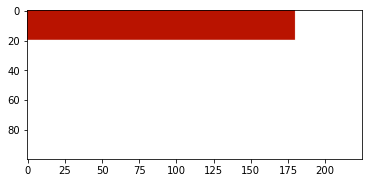

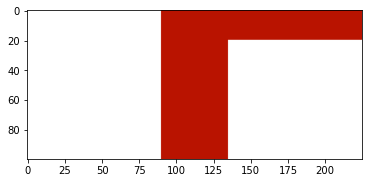

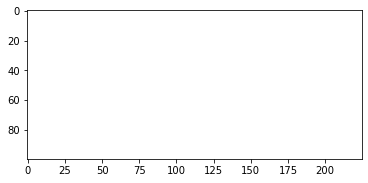

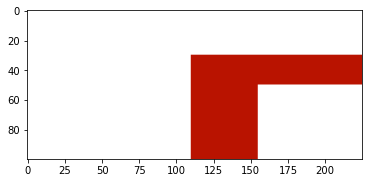

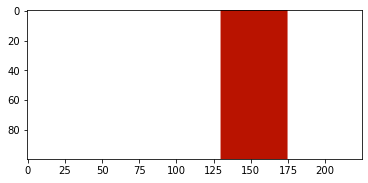

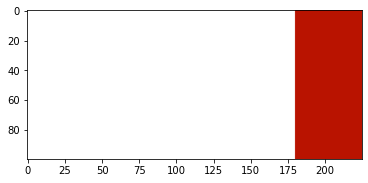

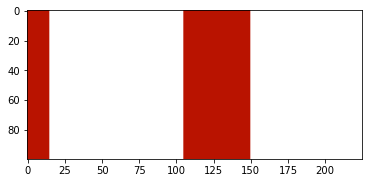

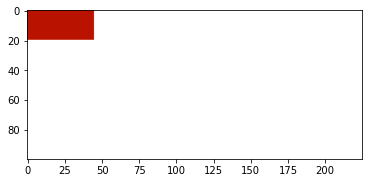

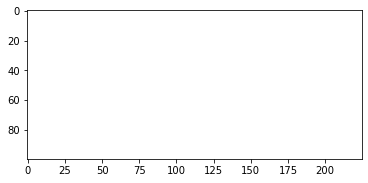

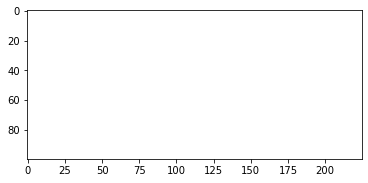

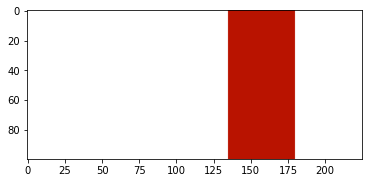

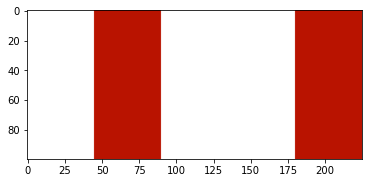

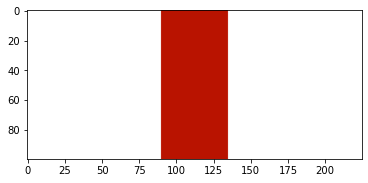

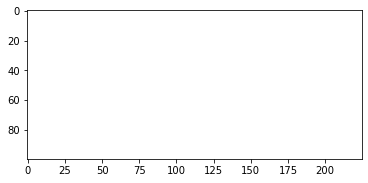

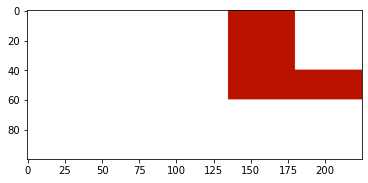

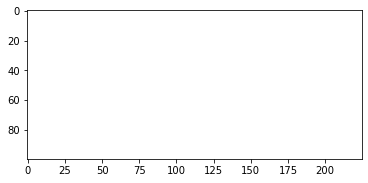

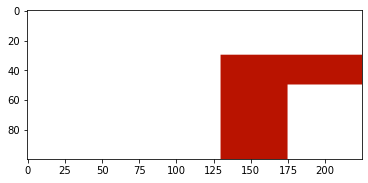

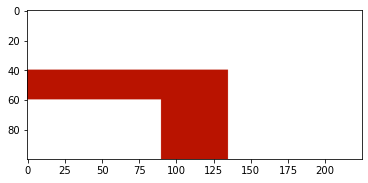

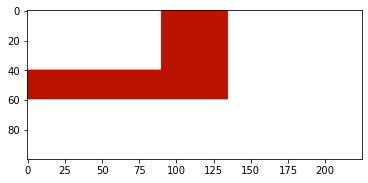

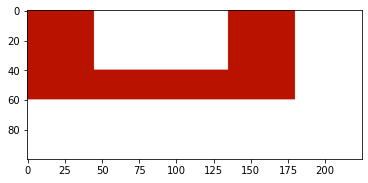

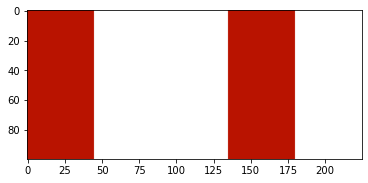

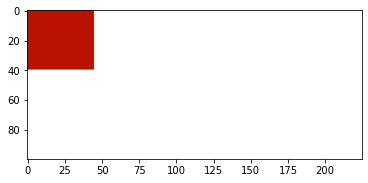

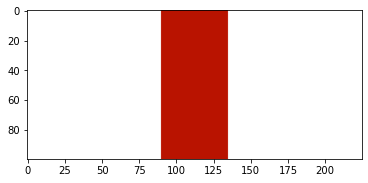

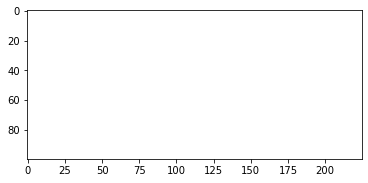

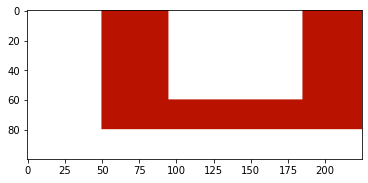

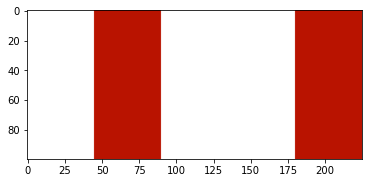

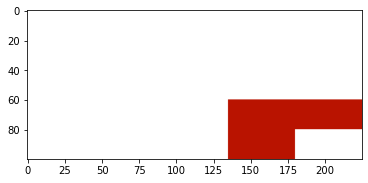

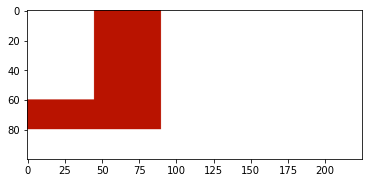

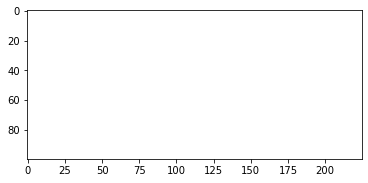

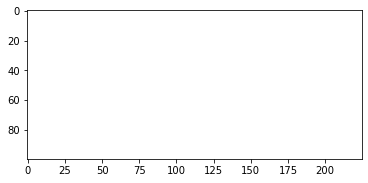

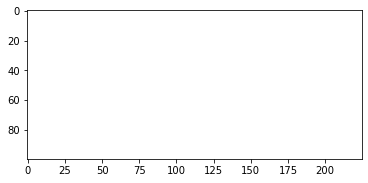

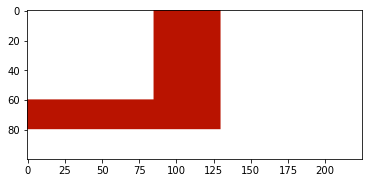

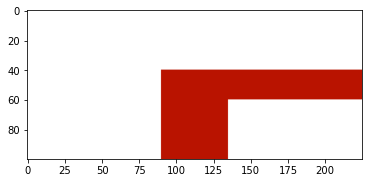

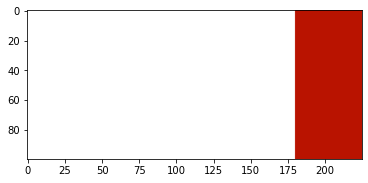

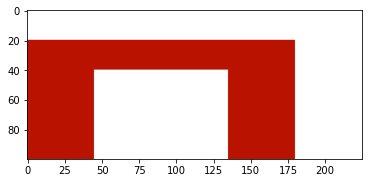

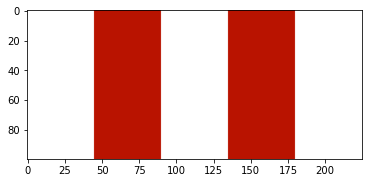

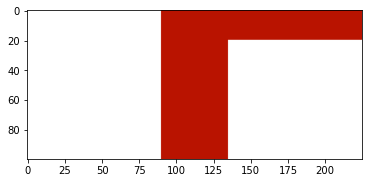

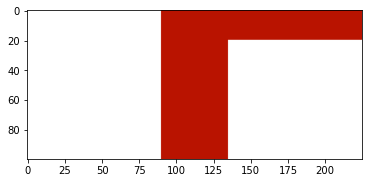

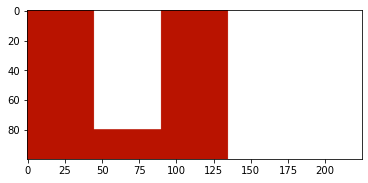

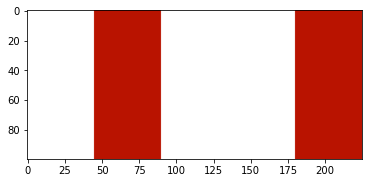

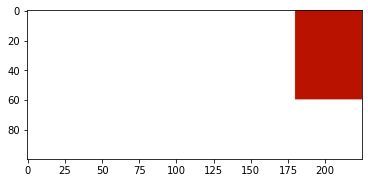

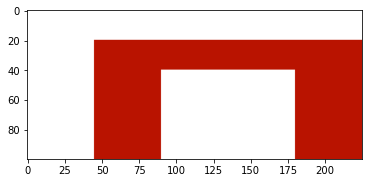

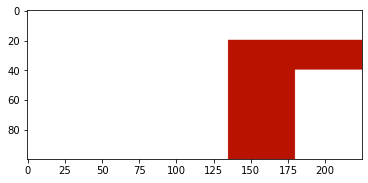

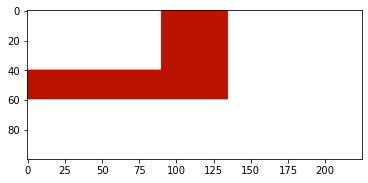

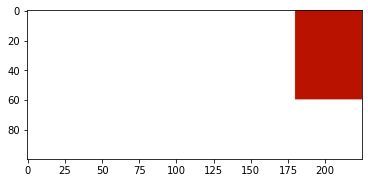

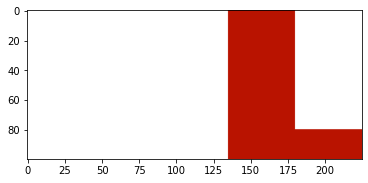

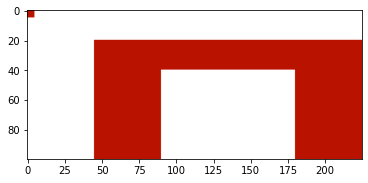

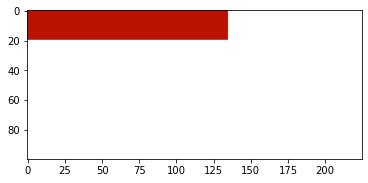

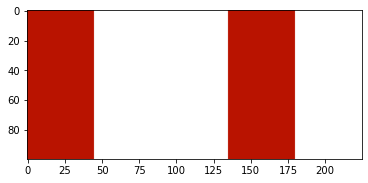

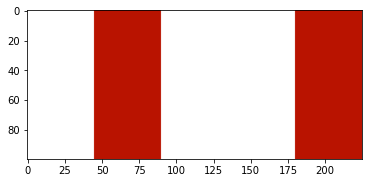

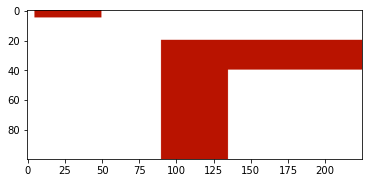

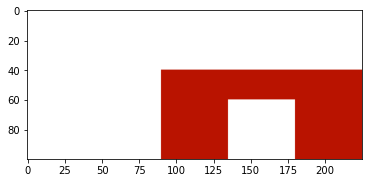

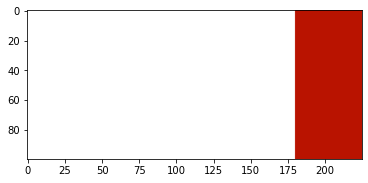

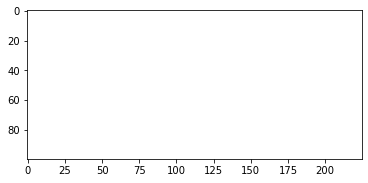

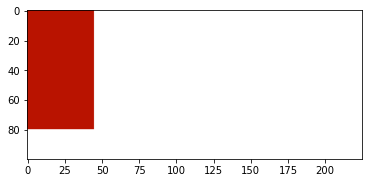

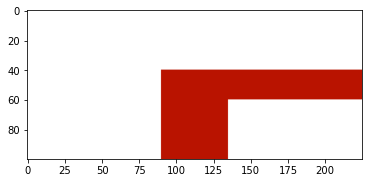

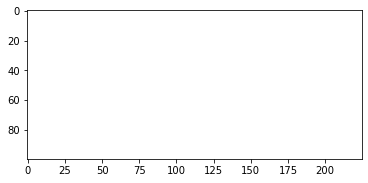

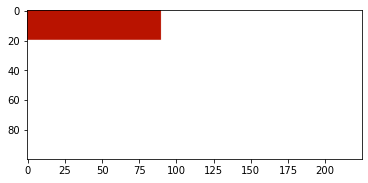

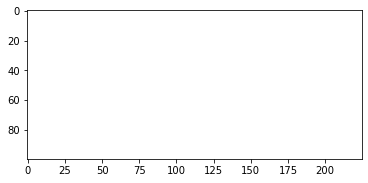

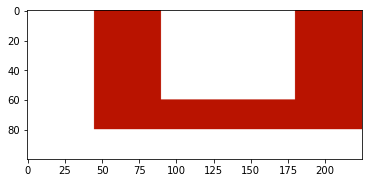

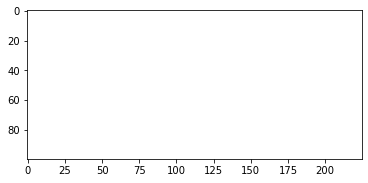

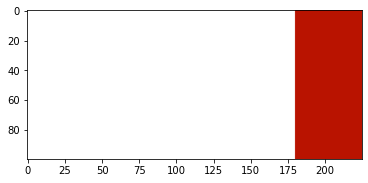

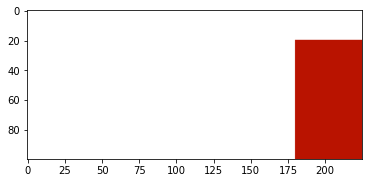

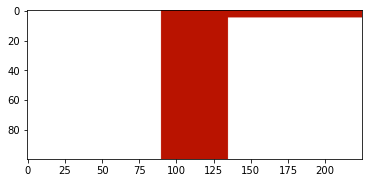

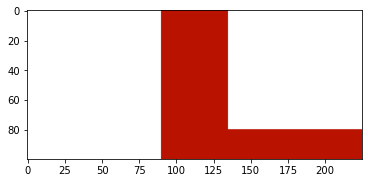

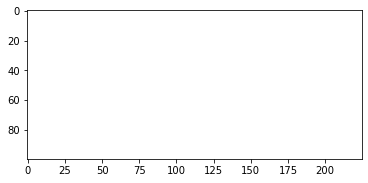

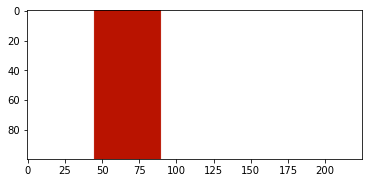

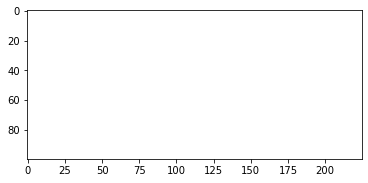

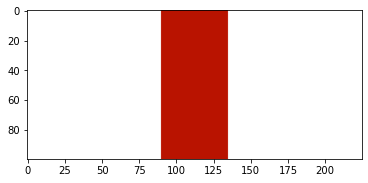

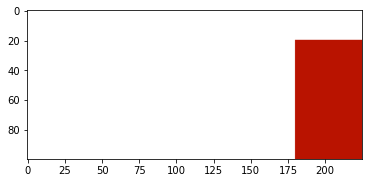

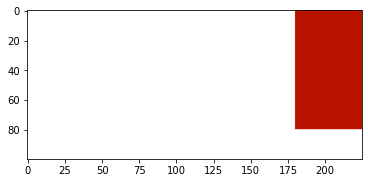

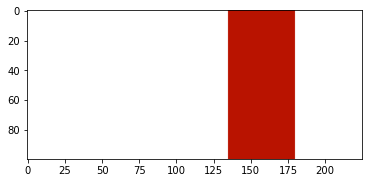

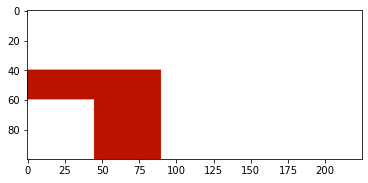

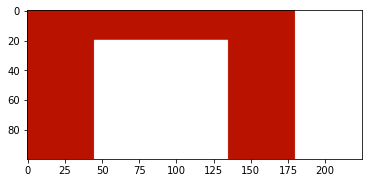

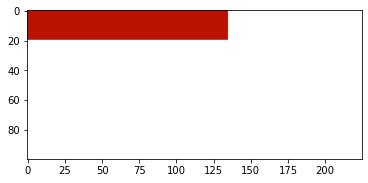

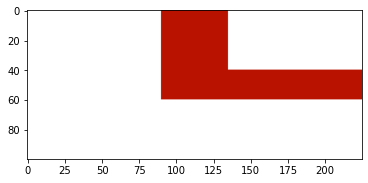

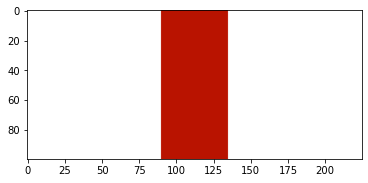

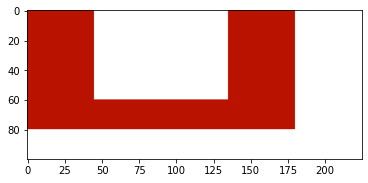

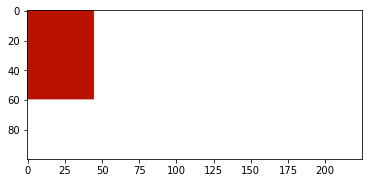

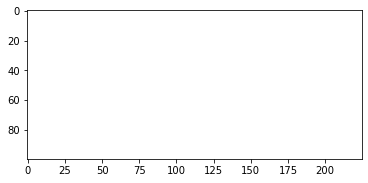

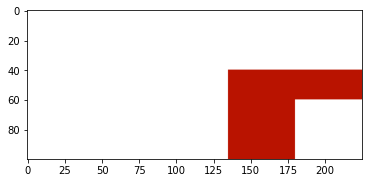

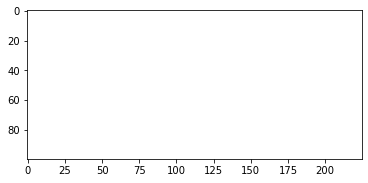

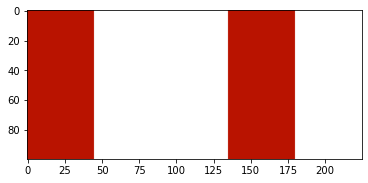

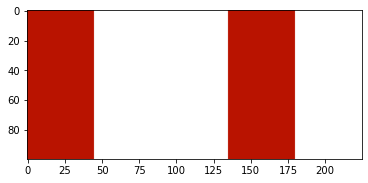

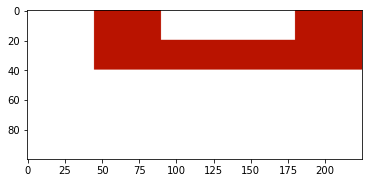

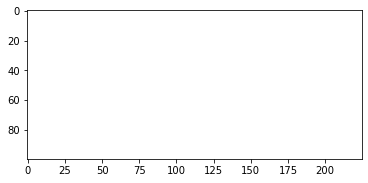

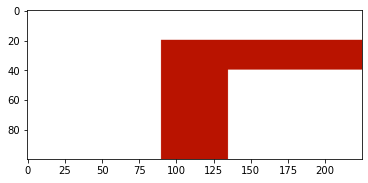

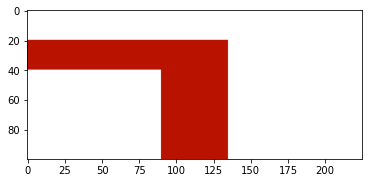

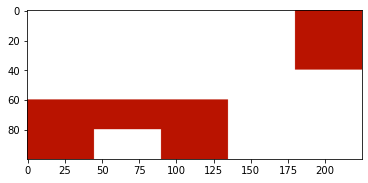

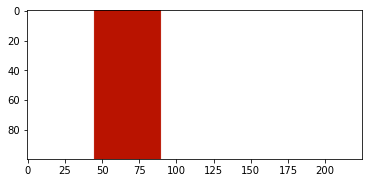

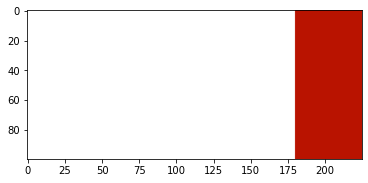

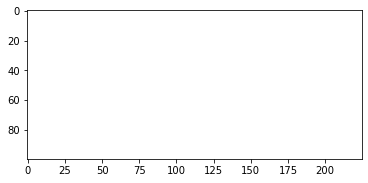

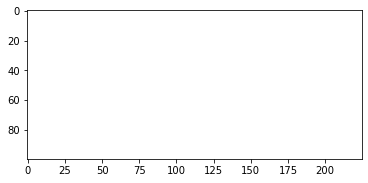

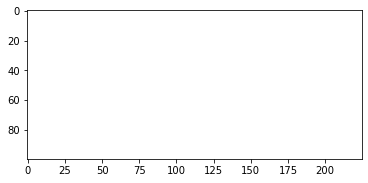

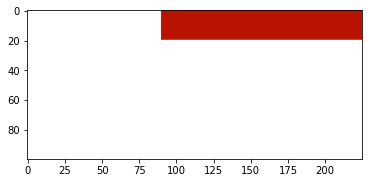

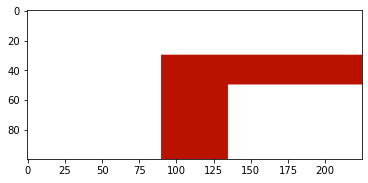

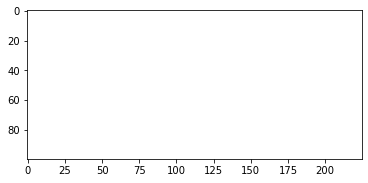

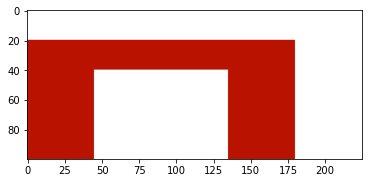

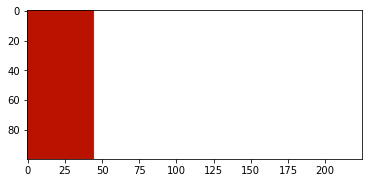

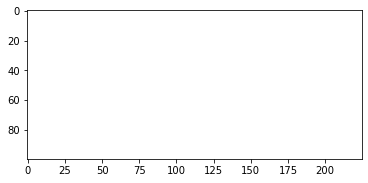

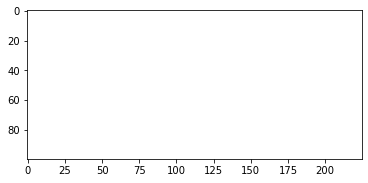

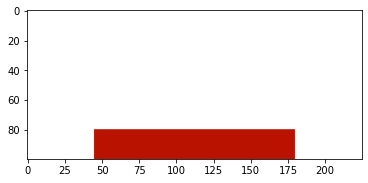

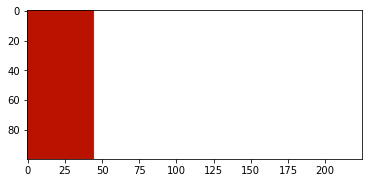

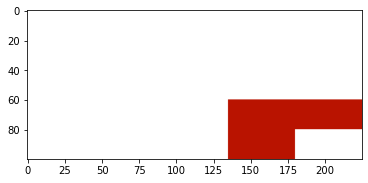

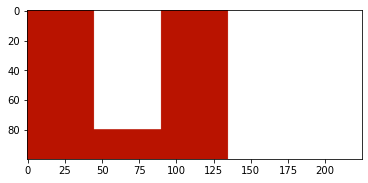

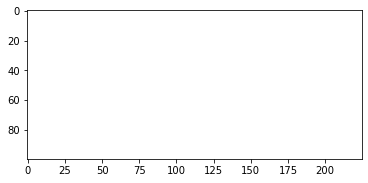

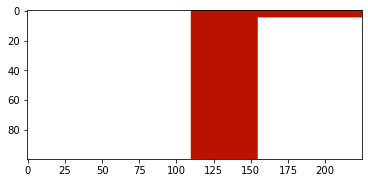

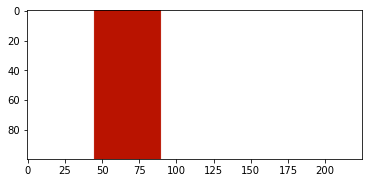

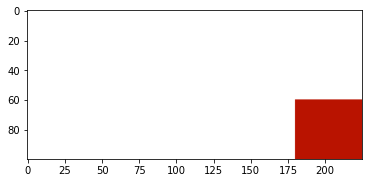

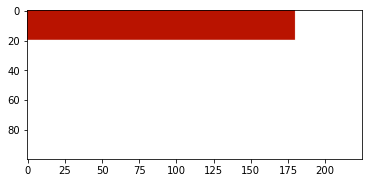

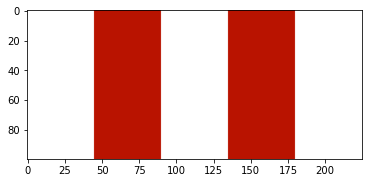

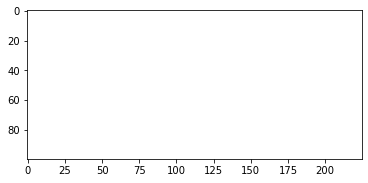

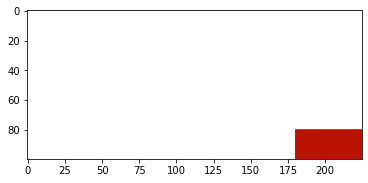

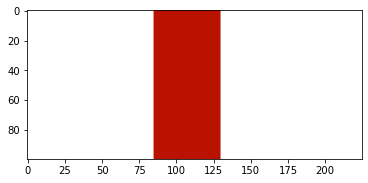

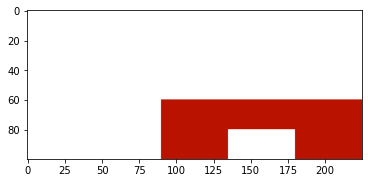

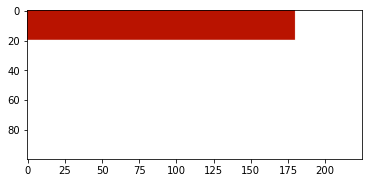

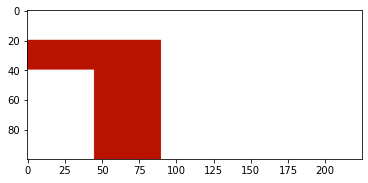

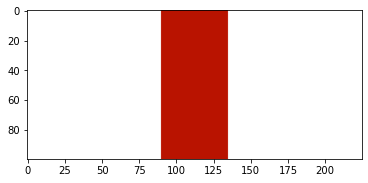

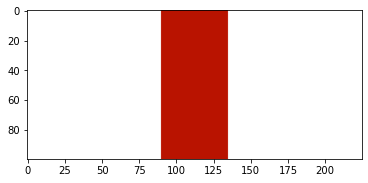

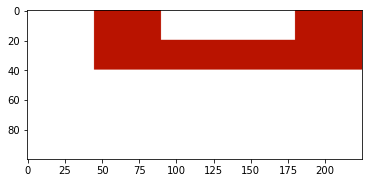

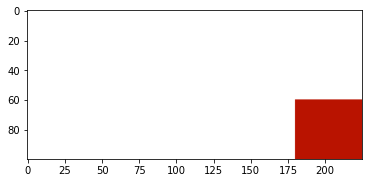

In [244]:
env = TemplateMatchingEnv(path_testing_image_red,
                          (5,5,20,45),
                          obs_shape_mult=(5,5),
                          compare_method='SSD',
                          sim_threshold=SIMILARTY_THRESHOLD,
                          print_st=True)

show = True
# rewards = []
log = {"Points":{},
       "Reward":{},
       "Results":{},
       "Closed":{}}

for episode in np.arange(0,300):
    if show==True:
        print(f"EPISODE {episode}")
    if show==True:
        fig,ax = plt.subplots()
    env.reset()
    while True:
        # Take a random action
        if show==True:
            print(f"Previous action was {env.previous_action}")
            print(f"Point is {env.previous_point}")
            ax.imshow(env.frame_array)
            # ax.set_title(f"Episode {episode}")
            # gpd.GeoSeries(Point((env.window_x,env.window_y))).plot(ax=ax)
            display.display(plt.gcf())
        # action = random.choice(list(set([x for x in range(0, env.action_space.n)])
        #                             - set([action_rules(env.previous_action)])))
        action = env.action_space.sample()
        print(action)
        obs, reward, done, info = env.step(action) 
        # img = plt.imshow(env.render(mode='rgb_array'))
        # img.set_data(env.render(mode='rgb_array'))
                
        if done == True:
            log['Points'][episode] = env.log_points
            log['Reward'][episode] = env.ep_return
            log['Results'][episode] = env.log_res
            log['Closed'][episode] = env.log_closed
            # display.clear_output(wait=True)
            if show==True:
                print("Clearing")
            if show==True:
                time.sleep(0.25)
            break
    fig = None
env.close()
# print(f"Maximum reward achieved {max(rewards)}")


### Analysis

In [245]:
df_reward = pd.DataFrame([log['Reward']]).transpose().reset_index().rename(columns={'index':"Episode",0:"Reward"}).set_index('Episode')
df_closed = pd.DataFrame([log['Closed']]).transpose().reset_index().rename(columns={'index':"Episode",0:"Closed"}).set_index('Episode')
df_results = pd.DataFrame([log['Results']]).transpose().reset_index().rename(columns={'index':"Episode",0:"Results"}).set_index('Episode')
df_points = pd.DataFrame([log['Points']]).transpose().reset_index().rename(columns={'index':"Episode",0:"Points"}).set_index('Episode')

df = pd.concat([df_reward,df_closed,df_results,df_points],axis=1)
df

,Reward,Closed,Results,Points
Episode,,,,
0,0,False,[113.33333333333333],"[(280, 90), (260, 135)]"
1,0,False,[113.33333333333333],"[(60, 180), (80, 225)]"
2,0,False,[],"[(60, 360)]"
3,0,False,[],"[(240, 0)]"
4,0,False,[113.33333333333333],"[(40, 225), (60, 225)]"
...,...,...,...,...
295,0,False,[113.33333333333333],"[(20, 180), (40, 225)]"
296,0,False,[],"[(60, 0)]"
297,0,False,[],"[(160, 360)]"


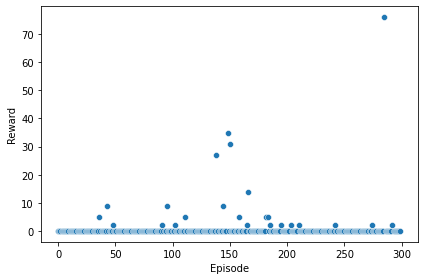

In [246]:

#[df['Reward']==df.max()['Reward']]

sns.scatterplot(data=df, x="Episode", y="Reward")
plt.tight_layout()

In [247]:
df.sort_values(by='Reward',ascending=False)

,Reward,Closed,Results,Points
Episode,,,,
285,76,True,"[69.33333333333333, 53.333333333333336, 53.333...","[(360, 135), (340, 90), (320, 135), (320, 180)..."
148,35,False,"[53.333333333333336, 69.33333333333333, 0.0, 6...","[(340, 90), (320, 135), (340, 180), (360, 225)..."
150,31,True,"[69.33333333333333, 0.0, 0.0]","[(360, 180), (340, 225), (360, 225), (360, 180)]"
138,27,False,"[0.0, 0.0, 0.0, 69.33333333333333, 0.0, 69.333...","[(340, 45), (360, 90), (360, 135), (360, 180),..."
166,14,False,"[69.33333333333333, 69.33333333333333, 0.0, 69...","[(320, 225), (340, 180), (340, 135), (360, 135..."
...,...,...,...,...
101,0,False,[],"[(20, 180)]"
100,0,False,[113.33333333333333],"[(260, 180), (260, 135)]"
99,0,False,[113.33333333333333],"[(100, 225), (100, 270)]"


<AxesSubplot:>

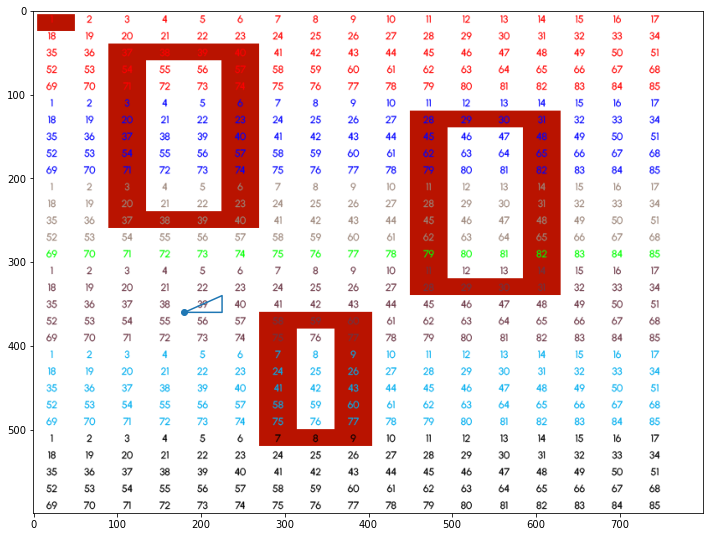

In [254]:
# look at path
fig,ax = plt.subplots(figsize=(12,12))
test_arr = cv2.cvtColor(cv2.imread(os.path.join(os.getcwd(),path_testing_image_red_grid)), cv2.COLOR_BGR2RGB)
ax.imshow(test_arr)#crop_image(test_image_norm,0,0,400,800)) #y,x,h,w


# line_string = ["LINESTRING (-1.15.12 9.9, -1.15.13 9.93)", "LINESTRING (-2.15.12 8.9, -2.15.13 8.93)"]
# invalid geometry - modified
points_rev = [(x[1],x[0]) for x in log['Points'][150]]
gpd.GeoSeries(LineString(points_rev)).plot(ax=ax)
gpd.GeoSeries(Point(points_rev[0])).plot(ax=ax)


### Training

In [258]:
env = TemplateMatchingEnv(path_testing_image_red,
                          (5,5,20,45),
                          obs_shape_mult=(5,5),
                          compare_method='SSD',
                          sim_threshold=SIMILARTY_THRESHOLD,
                          print_st=False)

env_checker.check_env(env)

In [ ]:
env = TemplateMatchingEnv(path_testing_image_red,
                          (5,5,20,45),
                          obs_shape_mult=(5,5),
                          compare_method='SSD',
                          sim_threshold=SIMILARTY_THRESHOLD,
                          print_st=False)

# The algorithms require a vectorized environment to run
print("Vectorize")
env = DummyVecEnv([lambda: env])
print("Policy")
model = DQN("CnnPolicy",
            env,
            verbose=1,
            seed=42,
            buffer_size=10000)
print("Learn")
model.learn(total_timesteps=4000)
model.save(os.path.join(os.getcwd(),'models','dqn_template_matching'))

del model # remove to demonstrate saving and loading


KeyboardInterrupt: 

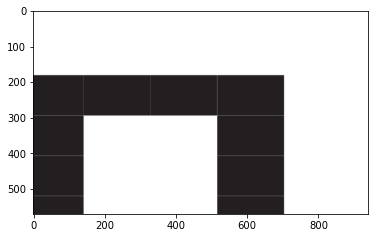

In [10]:
# model = DQN.load(os.path.join(os.getcwd(),'models','dqn_template_matching'))

obs = env.reset()
while True:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    env.render()
    if done:
      obs = env.reset()


### Array Mask

In [ ]:

# dist_over = int(env.updated_point[1]-env.window_y / env.T_HEIGHT)

def embed(big_arr, small_arr, y_offset, x_offset):
    big_arr[y_offset:y_offset+small_arr.shape[0],
            x_offset:x_offset+small_arr.shape[1]] = small_arr
    return big_arr

def nan_array(height,width,mult_height,mult_width):
    arr = np.empty((height*mult_height,
                    width*mult_width,
                    3))
    arr[:] = np.nan
    return arr

def partial_array(next_origin_y,height,next_origin_x,width,mult_height,mult_width,image_array):
    if next_origin_y < 0:
        inc_over_y = int(next_origin_y / height)
    else:
        inc_over_y = 0
    if next_origin_x < 0 :
        inc_over_x = int(next_origin_x / width)
    else:
        inc_over_x = 0
    reset_origin_y = next_origin_y - (inc_over_y * height)
    reset_origin_x = next_origin_x + (inc_over_x * width)
    par_arr = crop_image(image_array,
                        reset_origin_y,
                        reset_origin_x,
                        height*(mult_height + inc_over_y),
                        width*(mult_width + inc_over_x))
    
    nan_arr = nan_array(height,width,mult_height,mult_width)
    print()
    
    embeded_arr = embed(nan_arr,
                        par_arr,
                        nan_arr.shape[0] - height*(mult_height + inc_over_y),
                        nan_arr.shape[1] - width*(mult_width + inc_over_x))
    return embeded_arr,par_arr


next_origin_y = env.updated_point[1]-env.window_y
next_termination_y = next_origin_y + env.obs_shape_mult_height * env.T_HEIGHT
next_origin_x = env.updated_point[0]-env.window_x
next_termination_x = next_origin_x + env.obs_shape_mult_width * env.T_WIDTH

e_arr,par_arr = partial_array(next_origin_y,
                        env.T_HEIGHT,
                        next_origin_x,
                        env.T_WIDTH,
                        env.obs_shape_mult_height,
                        env.obs_shape_mult_width,
                        env.image_array)

# (next_origin_y - env.T_HEIGHT)
e_arr
fig,ax = plt.subplots(1,2)
ax[0].imshow(e_arr)
# ax[1].imshow(par_arr)


### Old Build

In [220]:
class TemplateMatchingEnv2(gym.Env):
    def __init__(self, image, template, obs_shape_mult=(3,3),sim_threshold=1000):
        super(TemplateMatchingEnv, self).__init__()
        self.image = image
        # self.reward_range = (0, 100000000)
        self.sim_threshold = sim_threshold
        
        # load template details
        self.template_array = template
        self.T_HEIGHT, self.T_WIDTH, self.T_DEPTH = self.template_array.shape
        # print(f"T_Height is {self.T_HEIGHT}")
        # print(f"T_Width is {self.T_WIDTH}")
        # set observation shape 
        self.obs_space_height = self.T_HEIGHT*obs_shape_mult[0]
        self.obs_space_width = self.T_WIDTH*obs_shape_mult[1]
        # print(f"Obs_num_cols is {self.obs_space_width}")
        # print(f"Obs_num_rows is {self.obs_space_height}")
        
        self.obs_shape_mult_height = obs_shape_mult[0]
        self.obs_shape_mult_width = obs_shape_mult[1]
        
        # Define a 2-D observation space
        self.observation_shape = (self.obs_space_height,
                                  self.obs_space_width,
                                  3)

        self.observation_space = spaces.Box(low = np.zeros(self.observation_shape), 
                                            high = np.ones(self.observation_shape),
                                            dtype = np.float16)
        
        # Action to choose the next agent location 
        # 0 -> 8 corresponds to the list of neighbor frames 
        self.action_space = spaces.Discrete(8)
        
        # Create a canvas to render the environment images upon 
        self.canvas = np.ones(self.observation_shape) * 1
        
        # Define elements present inside the environment
        self.elements = []
        
        # Maximum moves the frame can make before resetting
        self.max_moves = 8
        
    def draw_elements_on_canvas(self):
        # Init the canvas 
        self.canvas = np.ones(self.observation_shape) * 1

        # Draw the frame on canvas
        # for elem in self.elements:
        # elem_shape = self.frame.icon.shape
        # x,y = self.frame.x, self.frame.y
        self.canvas = self.image_array
        # self.canvas[y:y + elem_shape[0], x:x + elem_shape[1]] = self.frame.icon

        text = f"Turns Remaining: {self.moves_left} | Rewards: {self.ep_return}"

        # Put the info on canvas 
        # self.canvas = cv2.putText(self.canvas, text, (10,20), font,  
        #         0.8, (0,0,0), 1, cv2.LINE_AA)

    def reset(self):
        print('Reset')
        # Reset the Canvas 
        self.canvas = np.ones(self.observation_shape) * 1
        self.image_array = None
        self.previous_action = None
        self.moves_taken = 0
        self.points = []
        self.moves = []
        self.actions = np.arange(0,self.action_space.n)
        
        # Reset the moves allowed
        self.moves_left = self.max_moves

        # Reset the reward
        self.ep_return  = 0

        # Intialise the frame
        
        # origin point for frame
        self.frame_y_origin = int(np.floor(self.obs_shape_mult_height/2)) * self.T_HEIGHT
        self.frame_x_origin = int(np.floor(self.obs_shape_mult_width/2)) * self.T_WIDTH
        # print(self.frame_y_origin,self.frame_x_origin)
        
        # crop image to observation space
        self.image_height, self.image_width, self.image_depth = self.image.shape
        self.height_buffer = self.T_HEIGHT*(self.obs_shape_mult_height+1)
        self.width_buffer = self.T_WIDTH*(self.obs_shape_mult_width+1)
        self.y_max = self.image_height-(self.height_buffer)
        self.x_max = self.image_width-(self.width_buffer)
        
        self.lin_y = np.linspace(0,self.image_height,int(np.floor(
            self.image_height/self.T_HEIGHT)),dtype="int16")
        self.lin_x = np.linspace(0,self.image_width,int(np.floor(
            self.image_width/self.T_WIDTH)),dtype="int16")
        
        
        self.random_y_origin = random.choice(self.lin_y[self.lin_y<+self.y_max]) # random.randint(0, self.y_max)
        self.random_x_origin = random.choice(self.lin_x[self.lin_x<+self.x_max]) # random.randint(0, self.x_max)
        self.episode_origin = (self.random_y_origin,self.random_x_origin)
        # self.previous_point = self.episode_origin
        self.points.append(self.episode_origin)
        # print(self.random_y_origin,self.random_x_origin)
        
        self.image_array = crop_image(self.image,
                                      self.random_y_origin,
                                      self.random_x_origin,
                                      self.obs_space_height,
                                      self.obs_space_width)
        self.I_HEIGHT, self.I_WIDTH, self.I_DEPTH = self.image_array.shape



        # Initialise the analysis frame
        self.frame = Frame('frame',
                           self.y_max,
                           self.x_max,
                           self.frame_y_origin,
                           self.frame_x_origin,
                           self.T_HEIGHT,
                           self.T_WIDTH)
        self.frame.set_position(self.frame_y_origin,self.frame_x_origin)

        # Intialise the elements 
        self.elements = [self.image_array,self.frame]

        # Draw elements on the canvas
        self.draw_elements_on_canvas()

        # return the observation
        return self.canvas 
        
    def render(self, mode = "human"):
        assert mode in ["human", "rgb_array"], "Invalid mode, must be either \"human\" or \"rgb_array\""
        if mode == "human":
            plt.imshow(self.canvas)
        
        elif mode == "rgb_array":
            return self.canvas
    
    def close(self):
        cv2.destroyAllWindows()
    
    
    
    def test_ssd_match(self):
    
        self.frame_array = crop_image(self.image_array,
                                 self.frame_y_origin,
                                 self.frame_x_origin,
                                 self.T_HEIGHT,
                                 self.T_WIDTH)
        
        self.ssd_ = Sum_of_squared_differences(self.frame_array,self.template_array)
        # result_.append(ssd_) # log results
        res = self.ssd_
        print(f"SSD result is {res}")
        if res>self.sim_threshold:
            return True

        return False
        
    def generate_possible_pts(self):
        all_moves = [(self.T_HEIGHT,0),
                          (self.T_HEIGHT,self.T_WIDTH*-1),
                          (0,self.T_WIDTH*-1),
                          (self.T_HEIGHT*-1,self.T_WIDTH*-1),
                          (self.T_HEIGHT*-1,0),
                          (self.T_HEIGHT*-1,self.T_WIDTH),
                          (0,self.T_WIDTH),
                          (self.T_HEIGHT,self.T_WIDTH)]
        self.poss_pts = [tuple_addition(self.previous_point,pt) for pt in all_moves]
        return self.poss_pts
    
    def update_after_move(self):
        
        # store some data
        self.previous_action = self.action
        self.updated_point = tuple_addition(self.previous_point,self.movement)
        self.points.append(self.updated_point)
        self.moves.append(self.get_action_meanings()[self.action])
        # move the image array   
        self.image_array = crop_image(self.image,
                                      self.random_y_origin + self.movement[0],#self.frame_y
                                      self.random_x_origin + self.movement[1],#self.frame_x
                                      self.obs_space_height,
                                      self.obs_space_width)
    
    def step(self):
        self.possible_actions = self.actions
        # Flag that marks the termination of an episode
        done = False
        # Assert that it is a valid action 
        # assert self.action_space.contains(action), "Invalid Action"

        if self.moves_taken < 1:
            self.previous_point = self.episode_origin
        else:
            self.previous_point = self.updated_point

        # Decrease the moves left 
        self.moves_left -= 1 
        self.moves_taken += 1 
        print(f"Moves left, {self.moves_left}")
        
        for n,pt in enumerate(self.generate_possible_pts()):
            if pt==self.episode_origin:
                pass
            elif pt in self.points:
                np.delete(env.possible_actions,[n])
                
        if len(self.possible_actions)==0:
            print('No actions possible')
            done = True
            
        self.action = random.choice(self.possible_actions)
        
        # apply the action to the frame
        print(f"Action is {self.action}, {self.get_action_meanings()[self.action]}")
        if self.action == 0: # south
            self.movement = (self.T_HEIGHT,0)
        elif self.action == 1: # southwest
            self.movement = (self.T_HEIGHT,self.T_WIDTH*-1)
        elif self.action == 2: # west
            self.movement = (0,self.T_WIDTH*-1)
            #self.frame.move(0,T_WIDTH*-1)
        elif self.action == 3: # northwest
            self.movement = (self.T_HEIGHT*-1,self.T_WIDTH*-1)
        elif self.action == 4: # north
            self.movement = (self.T_HEIGHT*-1,0)
        elif self.action == 5: # northeast
            self.movement = (self.T_HEIGHT*-1,self.T_WIDTH)
        elif self.action == 6: # east
            self.movement = (0,self.T_WIDTH)
        elif self.action == 7: # southeast
            self.movement = (self.T_HEIGHT,self.T_WIDTH)
        
        self.update_after_move()
        match_ = self.test_ssd_match() # crop is done in function
        if match_ is True:
            print("Match")
            # Reward for a match.
            reward_a = 1
            # Reward for contiguous matches.
            reward_b = 1 * self.moves_taken
            reward = reward_a+reward_b
            
            if self.points[0] == self.points[-1]:
                print('Episode origin point visited. Loop created. Next Episode')
                reward += self.moves_taken**2
                
                # Increment the episodic return
                self.ep_return += reward

                # Draw elements on the canvas
                self.draw_elements_on_canvas()
                self.moves_left = 0
                done = True
            else:
                # Reset the moves allowed
                self.moves_left = self.max_moves
        else:
            print('No match, next epsiode')
            reward = 0
            done = True
        
        
        
        # Increment the episodic return
        self.ep_return += reward

        # Draw elements on the canvas
        self.draw_elements_on_canvas()

        # If out of moves, end the episode.
        if self.moves_left == 0:
            done = True

        return self.canvas, reward, done, []
    
        

In [ ]:

class TemplateMatchingEnv_1(gym.Env):
  """A template matching environment for OpenAI gym"""
  metadata = {'render.modes': ['human']}
  def __init__(self, image_array, template_array):
    super(TemplateMatchingEnv, self).__init__()
    self.image_array = image_array
    self.template_array = template_array
    self.I_HEIGHT, self.I_WIDTH = image_array.shape
    self.T_HEIGHT, self.T_WIDTH = template_array.shape
    self.reward_range = (0, int(np.ceil((self.I_HEIGHT/self.T_HEIGHT)*2 + (self.I_WIDTH/self.T_WIDTH)*2)))
    
    # Action to choose the next agent location 
    # 0 -> 8 corresponds to the lsit of neighbor frames 
    self.action_space = spaces.Discrete(8, start=0)
    
    # Setting the observation space to be a frame of the whole image 
    # observation is also set to look at RGB
    self.observation_shape = (self.T_HEIGHT*10,self.T_WIDTH*10 , 1)
    self.observation_space = spaces.Box(low=0, high=255, shape=self.observation_shape, dtype=np.uint8)
  
  def reset(self):
    # Reset the state of the environment to an initial state
    # Set the current step to a random point within the data frame
    self.current_step = (random.randint(0, self.I_HEIGHT-self.T_HEIGHT),
                         random.randint(0, self.I_WIDTH-self.T_WIDTH)) # (y,x)
    return self._next_observation()
  
  def _next_observation(self):
    # Get the surrounding boxes
    # need to control for the edge conditions:
    rois = find_regions_interest(self.image_array,
                                 self.current_step[1],
                                 self.current_step[0],
                                 self.T_WIDTH,
                                 self.T_HEIGHT)
    return rois
  
  def step(self, action):
    # Execute one time step within the environment
    self._take_action(action)
    self.current_step += 1
    if self.current_step > len(self.df.loc[:, 'Open'].values) - 6:
      self.current_step = 0
    delay_modifier = (self.current_step / MAX_STEPS)
    
    reward = self.balance * delay_modifier
    done = self.net_worth <= 0
    obs = self._next_observation()
    print(obs)
    return obs, reward, done, {}

  def _take_action(self, action):
    # Set the current price to a random price within the time step
    current_price = random.uniform(
      self.df.loc[self.current_step, "Open"],
      self.df.loc[self.current_step, "Close"])
    action_type = action[0]
    amount = action[1]
    # if action_type < 1:
    #   # Buy amount % of balance in shares
    #   total_possible = self.balance / current_price
    #   shares_bought = total_possible * amount
    #   prev_cost = self.cost_basis * self.shares_held
    #   additional_cost = shares_bought * current_price
    #   self.balance -= additional_cost
    #   self.cost_basis = (prev_cost + additional_cost) / 
    #                           (self.shares_held + shares_bought)
    #   self.shares_held += shares_bought
    # elif actionType < 2:
    #   # Sell amount % of shares held
    #   shares_sold = self.shares_held * amount . 
    #   self.balance += shares_sold * current_price
    #   self.shares_held -= shares_sold
    #   self.total_shares_sold += shares_sold
    #   self.total_sales_value += shares_sold * current_price
    # self.netWorth = self.balance + self.shares_held * current_price
    # if self.net_worth > self.max_net_worth:
    #   self.max_net_worth = net_worth
    # if self.shares_held == 0:
    #   self.cost_basis = 0

In [ ]:
def train(env, agent, replay_buffer, T=20000, n_theta=100):
    '''
    env (VectorizedEnvWrapper): vectorized gym.Env
    agent (DeepQLearner)
    buffer (ReplayBuffer)
    T (int): total number of training timesteps
    batch_size: number of
    '''
    

    # for plotting
    returns = []
    episode_rewards = 0

    s_t = env.reset()
    for t in range(T):
        # synchronize Q and Q_
        if t%n_theta == 0:
            agent.synchronize()

        a_t = agent.act(s_t)
        s_t_next, r_t, d_t = env.step(a_t)

        # store data into replay buffer
        replay_buffer.remember(s_t, a_t, r_t, s_t_next, d_t)
        s_t = s_t_next

        # learn by sampling from replay buffer
        for batch in replay_buffer.sample():
            agent.update(*batch)

        # for plotting
        episode_rewards += r_t
        for i in range(env.num_envs):
            if d_t[i]:
                returns.append(episode_rewards[i])
                episode_rewards[i] = 0

        # epsilon decay
        agent.decay_epsilon(t/T)

    plot_returns(returns)
    return agent

def plot_returns(returns, window=10):
    '''
    Returns (iterable): list of returns over time
    window: window for rolling mean to smooth plotted curve
    '''
    sns.lineplot(
        data=pd.DataFrame(returns).rolling(window=window).mean()[window-1::window]
    )

In [ ]:
%%time

# global variables
SIMILARTY_THRESHOLD = 3362500
MAX_STEPS = 100
TOTAL_EPISODES = 2000

# load data
image =
template =


# The algorithms require a vectorized environment to run
env = VectorizedEnvWrapper(TemplateMatchingEnv(image, template), num_envs=4)
agent = DeepQLearner(env, alpha=1e-3, gamma=0.95)
replay_buffer = ReplayBuffer(batch_size=1)
agent = train(env, agent, replay_buffer, T=20000)

### Trash

In [ ]:

## SCript to run the RL

# global variables
SIMILARTY_THRESHOLD = 0
MAX_STEPS = 2000
TOTAL_EPISODES = 2000

# load data
image =
template =


# The algorithms require a vectorized environment to run
env = TemplateMatchingEnv(image, template)
model = DQN("CnnPolicy", env, verbose=1)
model.learn(total_timesteps=MAX_STEPS)

model.save("/models/cnn_templatematch")  
model = DQN.load("/models/cnn_templatematch") 


# iterate the RL 
obs = env.reset()
for episode in np.arange(0,TOTAL_EPISODES): 
  action, _states = model.predict(obs, deterministic=True) # do something to illict an action 
  obs, rewards, done, info = env.step(action) # take a step based on the new action
  env.render()

NameError: name 'pd' is not defined